# Group project - Calf health

This project aims to develop a predictive model to assess the **likelihood of calves becoming sick** based on various features from multiple data sources. By analyzing blood sample data, slaughterhouse records, individual treatment histories, and additional relevant factors, the model seeks to identify patterns and insights that can inform interventions and improve calf health management practices.

## Importing required libraries

The necessary libraries for data manipulation, machine learning, and evaluation metrics are imported:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score

print("pandas version:", pd.__version__)            # version used: 2.2.3
print("seaborn version:", sns.__version__)            # version used: 0.13.2
print("matplotlib version:", plt.matplotlib.__version__)       # version used: 3.9.2
print("pyreadstat version:", pyreadstat.__version__)  # version used: 1.2.7
print("numpy version:", np.__version__)       # version used: 2.1.1
print("sklearn version:", sklearn.__version__)       # version used: 1.5.2

pandas version: 2.2.3
seaborn version: 0.13.2
matplotlib version: 3.9.2
pyreadstat version: 1.2.7
numpy version: 2.0.2
sklearn version: 1.5.2


## Data processing and preparation methods

In this section, the methods employed to process and prepare the datasets for analysis are outlined. The primary objective is to **create a comprehensive dataset** that integrates various sources of information related to calf health, including blood sample results, slaughterhouse data, individual treatment records, and additional features such as arrival weights and genetic details.

Each method focuses on loading, filtering, and merging relevant datasets.

### Loading blood and slaughterhouse data
The `load_group_data` function loads two key datasheets from an Excel file: one containing **blood sample data**, where hemoglobin and serum iron values are measured multiple times over several weeks/months, and another containing **slaughterhouse (SLH) data** from calves. A unique identifier for each calf is created (in the blood sample data) by combining its country and life number, allowing for accurate merging with other datasets.

In [2]:
def load_group_data(file, name_blood, name_slh):
    df_blood = pd.read_excel(file, sheet_name=name_blood)
    df_slh = pd.read_excel(file, sheet_name=name_slh)
    df_blood['cow_id'] = df_blood['Land'] + ' ' + df_blood['Levensnr'].astype(str)
    return df_blood, df_slh

### Identifying matching calf IDs
The `get_same_cows_ids` function identifies calf IDs that are present in both the blood sample and slaughterhouse (SLH) datasets. This ensures that subsequent analysis includes only calves for whom **both** types of data are available.


In [3]:
def get_same_cows_ids(df_blood, df_slh):
    cow_ids_blood = set(df_blood['cow_id'])
    cow_ids_slh = set(df_slh['ID nummer'])
    return  cow_ids_blood.intersection(cow_ids_slh)

### Combining data for matching calves
The `combine_matching_cows` function merges the blood sample dataset and the slaughterhouse (SLH) dataset based on the matching calf IDs identified earlier.

In [4]:
def combine_matching_cows(df_blood, df_slh, same_cows_ids):
    df_blood_filtered = df_blood[df_blood['cow_id'].isin(same_cows_ids)]
    df_slh_filtered = df_slh[df_slh['ID nummer'].isin(same_cows_ids)]
    
    df_combined = pd.merge(df_blood_filtered, df_slh_filtered, left_on='cow_id', right_on='ID nummer', how='inner')
    
    return df_combined

### Loading stallijst data
The `load_stallijst_data` function loads additional calf-related data from a stallijst sheet in the Excel file. This dataset includes important features such as fur color and the number of days spent at the veal farm, which may be relevant for predicting the health outcomes of the calves.

In [5]:
def load_stallijst_data(file, name_stallijst):
    df_stallijst = pd.read_excel(file, sheet_name=name_stallijst)
    
    return df_stallijst

### Combining stallijst data with combined dataset
The `combine_stallijst` function merges the previously combined dataset (blood + SLH) with the stallijst data using the calf ID as the key. This step enhances the dataset by adding further relevant information about each calf, providing a richer context for analysis.

In [6]:
def combine_stallijst(df_combined, df_stallijst):
    df_final_combined = pd.merge(df_combined, df_stallijst, left_on='Levensnr', right_on='Calf ID', how='inner')
    
    return df_final_combined

### Loading arrival weights data
The `load_arrival_weights` function retrieves data on the weights of calves upon their arrival at the veal farm. This dataset also includes details such as arrival dates and merchant information, which can be significant for understanding calf health. For instance, the length of time a calf spent at the dairy farm—potentially extended due to prior illness—can be inferred from the arrival date.

In [7]:
def load_arrival_weights(file, name_arrival_weights):
    df_arrival_weights = pd.read_excel(file, sheet_name=name_arrival_weights)
    
    return df_arrival_weights

### Adding arrival weight data
The `add_arrival_weight` function merges the combined dataset (blood + SLH + stallijst) with the arrival weights data based on matching arrival dates and merchant details. This step enhances the dataset by adding further relevant information about each calf, providing a richer context for analysis.

In [8]:
def add_arrival_weight(df_existing, df_arrival_weights):
    df_merged = pd.merge(df_existing, df_arrival_weights[['Stable', 'Handelaar', 'Arrival date', 'Arrival weight']],
                         left_on=['Merchant', 'Arrival Date at Veal Farm'],
                         right_on=['Handelaar', 'Arrival date'],
                         how='left')
    
    return df_merged

### Loading individual treatments data
The `load_individual_treatments` function retrieves data on the individual treatments administered to calves, including the corresponding treatment dates. This information is vital for predicting the health status of each calf, as it provides the target value indicating which calves became sick and which did not.

In [9]:
def load_individual_treatments(file, name_individual_treatments):
    df_individual_treatments = pd.read_excel(file, sheet_name=name_individual_treatments)
    
    return df_individual_treatments

### Adding sick status to the dataset
The `add_sick_status` function assesses the treatment data to identify whether each calf has been sick. It does this by determining the earliest recorded treatment date for each calf and labeling them as `Sick` (1) if they have a treatment date or `Not Sick` (0) otherwise. This new target variable (added to the combined dataset) is essential for training the predictive model, as it indicates the health outcomes to be predicted.

In [10]:
def add_sick_status(df_existing, df_individual_treatments):
    df_individual_treatments['Datum'] = pd.to_datetime(df_individual_treatments['Datum'], errors='coerce')
    
    df_earliest_sickness = df_individual_treatments.groupby('Lev.nr')['Datum'].min().reset_index()
    
    df_merged = pd.merge(df_existing, df_earliest_sickness, left_on='Calf ID + Country', right_on='Lev.nr', how='left')
    
    df_merged['Sick'] = df_merged['Datum'].apply(lambda x: 1 if pd.notna(x) else 0)
    
    df_merged.rename(columns={'Datum': 'Sickness Date'}, inplace=True)
    
    return df_merged

# Antens farm

## Group 2348201

In [34]:
df_blood, df_slh = load_group_data(
    'Structured data.xlsx', name_blood=0, name_slh=1
)

In [35]:
same_cows_2348201 = get_same_cows_ids(df_blood, df_slh)

In [36]:
len(same_cows_2348201)

549

**There are 549 same cows in both datasets**

## Group 2242208

In [42]:
df_blood_2242208, df_slh_2242208 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2242208 - blood samples',
    name_slh='Group 2242208 Slaughterhouse'
)

In [45]:
same_cows_2242208 = get_same_cows_ids(df_blood_2242208, df_slh_2242208)

In [46]:
len(same_cows_2242208)

491

**There are 491 same cows in both datasets**

## Group 2211207 

In [48]:
df_blood_2211207, df_slh_2211207 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2211207 - blood samples',
    name_slh='Group 2211207 Slaughterhouse',
)

In [49]:
same_cows_2211207 = get_same_cows_ids(df_blood_2211207, df_slh_2211207)

In [50]:
len(same_cows_2211207)

91

**There are 91 same cows in both datasets**

## Group 2133206

In [51]:
df_blood_2133206, df_slh_2133206 = load_group_data(
    'Structured data.xlsx',
    name_blood='Group 2133206 - blood samples',
    name_slh='Group 2133206 Slaughterhouse',
)

In [52]:
same_cows_2133206 = get_same_cows_ids(df_blood_2133206, df_slh_2133206) 

In [53]:
len(same_cows_2133206)

511

**There are 511 same cows in both datasets**

# Stagri farm

## Group 2338338

In [55]:
df_blood_2338338, df_slh_2338338 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2338338 - blood samples',
    name_slh='Group 2338338 Slaughterhouse',
)

In [57]:
same_cows_2338338 = get_same_cows_ids(df_blood_2338338, df_slh_2338338) 

In [58]:
len(same_cows_2338338)

898

## Group 2309337

In [60]:
df_blood_2309337, df_slh_2309337 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2309337 - blood samples',
    name_slh='Group 2309337 Slaughterhouse',
)

In [61]:
same_cows_2309337 = get_same_cows_ids(df_blood_2309337, df_slh_2309337) 

In [63]:
len(same_cows_2309337)

152

## Group 2232336

In [64]:
df_blood_2232336, df_slh_2232336 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2232336 - blood samples',
    name_slh='Group 2232336 Slaughterhouse',
)

In [65]:
same_cows_2232336 = get_same_cows_ids(df_blood_2232336, df_slh_2232336) 

In [66]:
len(same_cows_2232336)

278

## Group 2128334

In [ ]:
df_blood_2128334, df_slh_2128334 = load_group_data(
    'Stagri structured data.xlsx',
    name_blood='Group 2128334 - blood samples',
    name_slh='Group 2128334 Slaughterhouse',
)

In [68]:
same_cows_2128334 = get_same_cows_ids(df_blood_2128334, df_slh_2128334) 

In [69]:
len(same_cows_2128334)

354

## Individual treatments data

In [72]:
treatments = pd.read_excel('Stagri structured data.xlsx', sheet_name='Individual treatments')

In [77]:
treatments.shape

(1484, 15)

In [79]:
treatments['Levensnummer'].unique().shape

(1484,)

In [75]:
cows_in_all_dfs = (same_cows_2338338 | same_cows_2309337 | same_cows_2232336 | same_cows_2128334).intersection(set(treatments['Levensnummer']))

In [76]:
len(cows_in_all_dfs)

898

# Borne farm

One of the three farms from which Maarten (our client) has provided data is the `Borne` farm. In this section, the data for each group of calves is analyzed to identify correlations between the available features and the likelihood of illness. The goal is to develop a predictive model for calf health.

While most data is consistent across the different groups, there are exceptions in the **slaughter data**, where two datasheets are available for some groups with differing features. As a result, two datasets will be created (`SlaughterhouseS` & `SlaughterhouseP`), with the primary distinction being the slaughter data used. Both datasets will be individually evaluated for correlations and used to train the predictive model.

## Group 2412242

This section covers the data processing and analysis for **Group 2412242** from the `Borne` Farm.

### Group 2412242 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [666]:
df_blood_2412242, df_slh_2412242 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2412242 - blood samples',
    name_slh='Group 2412242 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [667]:
same_cows_2412242 = get_same_cows_ids(df_blood_2412242, df_slh_2412242) 

In [668]:
len(same_cows_2412242)

913

The blood sample data and slaughterhouse data are then combined:

In [669]:
df_combined_2412242 = combine_matching_cows(df_blood_2412242, df_slh_2412242, same_cows_2412242)
print(df_combined_2412242.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [670]:
df_stallijst_2412242 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2412242 Stallijst'
)

df_final_combined_2412242 = combine_stallijst(df_combined_2412242, df_stallijst_2412242)

print(df_final_combined_2412242.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [671]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2412242, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [672]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [673]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [674]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 133


Matching columns in the dataset are identified:

In [675]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [676]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [677]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [678]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               10             1.095290
HB3                              880            96.385542
S2                                10             1.095290
S3                               880            96.385542
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      718            78.641840
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex           

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [679]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

HB1  HB2  HB3   S2   S3 Type  Vetbedekking  Kleur  Gewicht Geboorte datum  \
0  5.2  5.6  0.0  0.0  0.0   O-            20      5    131.9      20-2-2024   
1  5.2  0.0  0.0  0.0  0.0   O+            20     10    131.5      20-2-2024   
2  6.5  7.5  0.0  0.0  0.0   O-            20      3    132.4      24-2-2024   
3  5.6  6.0  0.0  0.0  0.0   O+            30      8    139.8      21-2-2024   
4  5.2  6.4  0.0  0.0  0.0   R-            10      6    114.9      20-2-2024   

  Slacht datum  Afwijkingen     Calf ID Calf ID + Country County ID  Merchant  \
0    1-10-2024            0  1082701836     DE 1082701836        DE  Boerkamp   
1    30-9-2024            0  1604746632     DE 1604746632        DE  Boerkamp   
2    1-10-2024            0  1082702209     DE 1082702209        DE  Boerkamp   
3    1-10-2024            0  1406905850     DE 1406905850        DE  Boerkamp   
4    1-10-2024            1  1604746630     DE 1604746630        DE  Boerkamp   

   Sex Color Letter         Fur Color Arrival Date at Veal Farm  \
0    1            Z         Zwartbont                2024-03-26   
1    0            U  Eenkleurig bruin                2024-03-27   
2    1            Z         Zwartbont                2024-03-26   
3    0            U  Eenkleurig bruin                2024-03-27   
4    1            U  Eenkleurig bruin                2024-03-27   

   Days at diary farm    Stable  Arrival weight Sickness Date  Sick  
0                  35  Vd Borne            57.0           NaT     0  
1                  36  Vd Borne            54.5           NaT     0  
2                  31  Vd Borne            57.0           NaT     0  
3                  35  Vd Borne            54.5           NaT     0  
4                  36  Vd Borne            54.5           NaT     0

This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [680]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID + Calf ID',
       'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [681]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2412242_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2412242_pali.columns)

pd.set_option('display.max_columns', None)

df_final_cleaned_2412242_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


Country ID + Calf ID Country ID       Calf ID Birth Date  Sex    Stable  \
354      IE 219066050570         IE  219066050570  24-2-2024    0  Vd Borne   
652      IE 213475592045         IE  213475592045  10-2-2024    1  Vd Borne   
769      IE 223115386824         IE  223115386824  10-2-2024    0  Vd Borne   
141      IE 217730722247         IE  217730722247  13-2-2024    1  Vd Borne   
24         DE 1505311653         DE    1505311653  21-2-2024    1  Vd Borne   

     Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
354                  28                2024-03-23           44.30   
652                  41                2024-03-22           50.60   
769                  42                2024-03-23           44.30   
141                  44                2024-03-28           51.30   
24                   35                2024-03-27           52.29   

                    Merchant  Fur Color Color Letter  Hemoglobin 1  \
354                klaremelk  Zwartbont            Z           7.8   
652  Van Beek Kalvermesterij  Zwartbont            Z           5.2   
769                klaremelk  Zwartbont            Z           6.4   
141                 lochimex  Zwartbont            Z           6.5   
24                Pali BV BA  Zwartbont            Z           5.4   

     Hemoglobin 2  Hemoglobin 3  Serum 2  Serum 3 Sickness Date  Sick  \
354           6.5           0.0      0.0      0.0           NaT     0   
652           4.2           0.0      0.0      0.0    2024-08-04     1   
769           5.2           0.0      0.0      0.0           NaT     0   
141           4.4           0.0      0.0      0.0           NaT     0   
24            6.0           0.0      0.0      0.0           NaT     0   

    Slaughter Date  Slaughter Weight  Fat Covering  Meat Color Type  \
354      26-9-2024              99.9            20           7   O0   
652      27-9-2024             153.2            30           7   O+   
769      26-9-2024             123.8            30           4   O0   
141      24-9-2024             148.2            20           7   O0   
24       30-9-2024             162.2            30           9   O0   

     Abnormalities  
354              0  
652              0  
769              1  
141              0  
24               0

In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [682]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          1     1         0    0
2          0     0         0    1
3          1     1         0    0
4          1     2         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

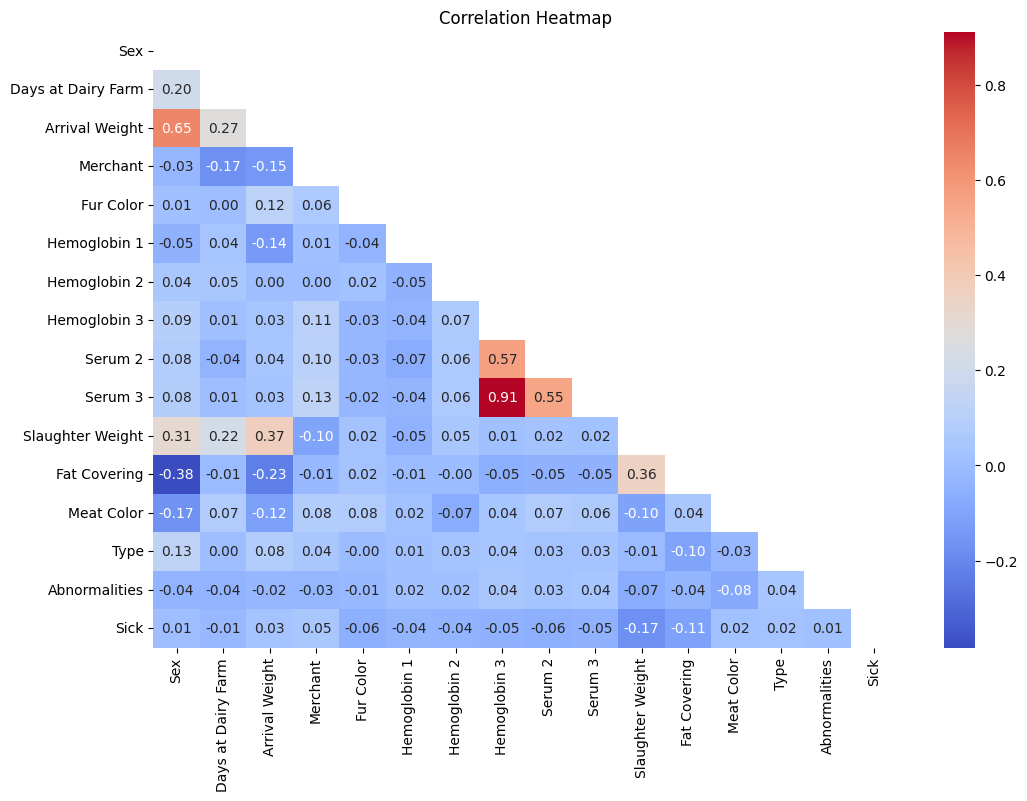

In [683]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2336241

This section covers the data processing and analysis for **Group 2336241** from the `Borne` Farm.

### Group 2336241 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [684]:
df_blood_2336241, df_slh_2336241 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2336241 - blood samples',
    name_slh='Group 2336241 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [685]:
same_cows_2336241 = get_same_cows_ids(df_blood_2336241, df_slh_2336241) 

In [686]:
len(same_cows_2336241)

440

The blood sample data and slaughterhouse data are then combined:

In [687]:
df_combined_2336241 = combine_matching_cows(df_blood_2336241, df_slh_2336241, same_cows_2336241)
print(df_combined_2336241.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [688]:
df_stallijst_2336241 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2336241 Stallijst'
)

df_final_combined_2336241 = combine_stallijst(df_combined_2336241, df_stallijst_2336241)

print(df_final_combined_2336241.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [689]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2336241, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [690]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [691]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [692]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 33


Matching columns in the dataset are identified:

In [693]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [694]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [695]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'X', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [696]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.227273
HB3                              421            95.681818
S2                                 1             0.227273
S3                               421            95.681818
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      302            68.636364
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [697]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

HB1  HB2  HB3   S2    S3 Type  Vetbedekking  Kleur  Gewicht Geboorte datum  \
0  4.0  5.2  5.4  0.0  21.0   O0            30      6    172.3       4-8-2023   
1  4.2  6.5  0.0  0.0   0.0   O0            30      6    143.5       8-8-2023   
2  6.5  6.3  0.0  0.0   0.0   O-            20      6    140.5       6-8-2023   
3  4.8  6.5  0.0  0.0   0.0   O-            20      5    135.7       7-8-2023   
4  4.2  6.6  0.0  0.0   0.0   O+            20      5    137.9       7-8-2023   

  Slacht datum  Afwijkingen     Calf ID County ID  Merchant  Sex Color Letter  \
0     6-3-2024            1  1272852854        DE  Boerkamp    1            Z   
1     6-3-2024            0  1272867460        DE  Boerkamp    0            Z   
2     8-3-2024            1  1273641162        DE  Boerkamp    1            Z   
3     5-3-2024            1  1406949406        DE  lochimex    1            U   
4     5-3-2024            0  1505435824        DE  Boerkamp    1            U   

          Fur Color Arrival Date at Veal Farm  Days at diary farm  \
0         Zwartbont                2023-09-06                  33   
1         Zwartbont                2023-09-06                  29   
2         Zwartbont                2023-09-06                  31   
3  Eenkleurig bruin                2023-09-06                  30   
4  Eenkleurig bruin                2023-09-06                  30   

  Calf ID + Country    Stable  Arrival weight Sickness Date  Sick  
0     DE 1272852854  Vd Borne           54.76           NaT     0  
1     DE 1272867460  Vd Borne           54.76           NaT     0  
2     DE 1273641162  Vd Borne           54.76           NaT     0  
3     DE 1406949406  Vd Borne           49.70           NaT     0  
4     DE 1505435824  Vd Borne           54.76           NaT     0

This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [698]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Country ID + Calf ID', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [699]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date',
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2336241_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2336241_pali.columns)

df_final_cleaned_2336241_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


Country ID + Calf ID Country ID     Calf ID Birth Date  Sex    Stable  \
246        DE 1604707328         DE  1604707328   8-8-2023    1  Vd Borne   
159        FR 5374331410         FR  5374331410  20-8-2023    1  Vd Borne   
329        DE 1307003158         DE  1307003158   1-8-2023    1  Vd Borne   
437        FR 3524576312         FR  3524576312  16-8-2023    1  Vd Borne   
266        DE 1604711617         DE  1604711617   6-8-2023    1  Vd Borne   

     Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
246                  29                2023-09-06           49.70   
159                  17                2023-09-06           43.00   
329                  35                2023-09-05           51.06   
437                  21                2023-09-06           43.00   
266                  31                2023-09-06           49.70   

                    Merchant  Fur Color Color Letter  Hemoglobin 1  \
246                 lochimex  Zwartbont            Z           4.8   
159               Pali BV BA  Zwartbont            Z           4.5   
329  Van Beek Kalvermesterij  Zwartbont            Z           5.6   
437               Pali BV BA  Zwartbont            Z           4.0   
266                 lochimex  Zwartbont            Z           5.0   

     Hemoglobin 2  Hemoglobin 3  Serum 2  Serum 3 Sickness Date  Sick  \
246           5.2           0.0      0.0      0.0           NaT     0   
159           5.9           0.0      0.0      0.0           NaT     0   
329           5.0           0.0      0.0      0.0           NaT     0   
437           5.5           0.0      0.0      0.0           NaT     0   
266           5.7           0.0      0.0      0.0           NaT     0   

    Slaughter Date  Slaughter Weight  Fat Covering  Meat Color Type  \
246       6-3-2024             152.4            20           6   O0   
159       6-3-2024             127.4            20           5   O-   
329       8-3-2024             178.0            30           5   R-   
437       7-3-2024             138.8            20           5   O-   
266       6-3-2024             121.7            20           6   O-   

     Abnormalities  
246              0  
159              0  
329              1  
437              0  
266              1

In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [700]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    0
2          0     1         0    1
3          1     1         1    1
4          1     2         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

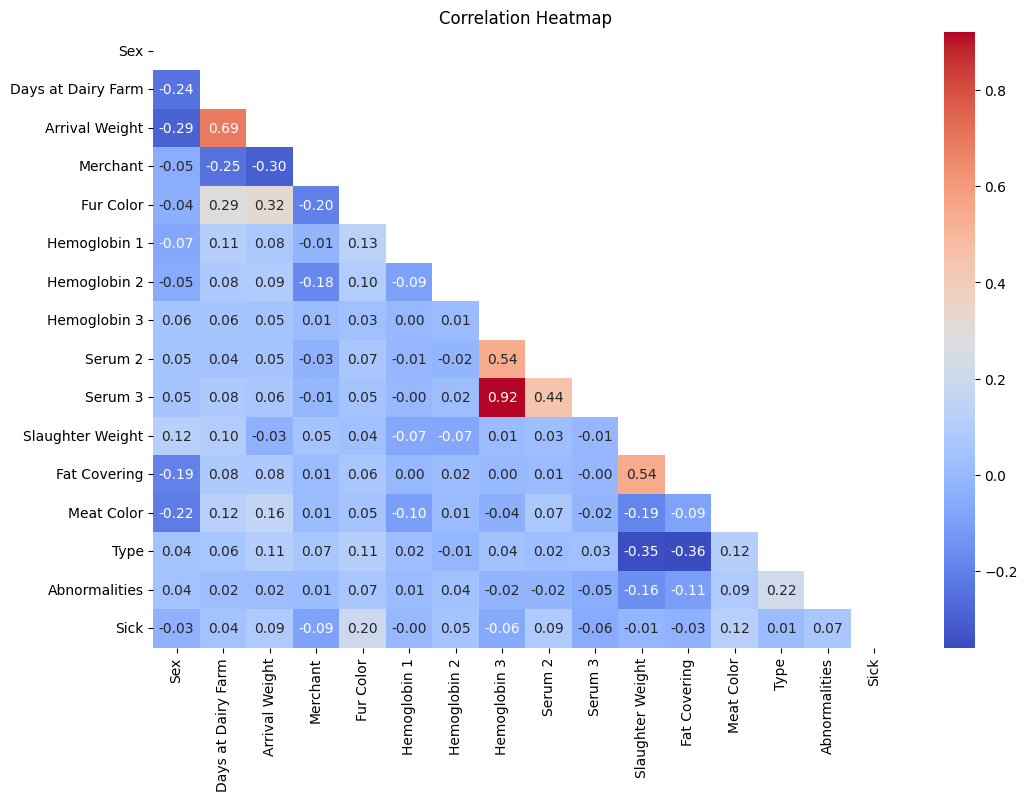

In [701]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2308249

This section covers the data processing and analysis for **Group 2308249** from the `Borne` Farm.

### Group 2308249 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [702]:
df_blood_2308249, df_slh_2308249 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2308249 - blood samples',
    name_slh='Group 2308249 Slaughterhouse',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [703]:
same_cows_2308249 = get_same_cows_ids(df_blood_2308249, df_slh_2308249) 

In [704]:
len(same_cows_2308249)

546

The blood sample data and slaughterhouse data are then combined:

In [705]:
df_combined_2308249 = combine_matching_cows(df_blood_2308249, df_slh_2308249, same_cows_2308249)
print(df_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [706]:
df_stallijst_2308249 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2308249 Stallijst'
)

df_final_combined_2308249 = combine_stallijst(df_combined_2308249, df_stallijst_2308249)

print(df_final_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [707]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2308249, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [708]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [709]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
       'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [710]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 158


Matching columns in the dataset are identified:

In [711]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [712]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'WerkNr', 'Gewicht',
       'Soort', 'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse',
       'Slacht Datum', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [713]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [714]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                4             0.732601
HB3                              520            95.238095
HB4                              520            95.238095
S2                                 4             0.732601
S3                               520            95.238095
S4                               520            95.238095
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Slacht Datum                       0             0.000000
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant      

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `HB4`, `S2`, `S3`, and `S4`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [715]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['HB4'] = df_final_cleaned['HB4'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)
df_final_cleaned['S4'] = df_final_cleaned['S4'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

HB1  HB2  HB3  HB4   S2   S3   S4  Gewicht  Soort  Kleur  Vet  \
0  6.4  6.2  0.0  0.0  0.0  0.0  0.0    112.0     13      6    2   
1  5.7  5.1  0.0  0.0  0.0  0.0  0.0    128.9     11      6    2   
2  6.7  5.6  0.0  0.0  0.0  0.0  0.0    108.2     12      7    2   
3  5.2  5.2  0.0  0.0  0.0  0.0  0.0    129.0     11      1    2   
4  6.2  6.4  0.0  0.0  0.0  0.0  0.0     90.9     14      6    1   

         Geboortedatum Slacht Datum       Calf ID Calf ID + Country County ID  \
0  2023-01-02 00:00:00    8/23/2023  222680862571   IE 222680862571        IE   
1  2023-07-02 00:00:00    8/23/2023  214158682440   IE 214158682440        IE   
2  2023-07-02 00:00:00    8/22/2023  223849832428   IE 223849832428        IE   
3  2023-07-02 00:00:00    8/22/2023  217152272253   IE 217152272253        IE   
4  2023-05-02 00:00:00    8/23/2023  219154364201   IE 219154364201        IE   

                  Merchant  Sex Color Letter  Fur Color  \
0  Van Beek Kalvermesterij    1            Z  Zwartbont   
1  Van Beek Kalvermesterij    1            Z  Zwartbont   
2  Van Beek Kalvermesterij    1            Z  Zwartbont   
3  Van Beek Kalvermesterij    1            Z  Zwartbont   
4  Van Beek Kalvermesterij    1            Z  Zwartbont   

  Arrival Date at Veal Farm  Days at diary farm    Stable  Arrival weight  \
0                2023-02-25                  24  Vd Borne            46.7   
1                2023-02-25                  18  Vd Borne            46.7   
2                2023-02-25                  18  Vd Borne            46.7   
3                2023-02-25                  18  Vd Borne            46.7   
4                2023-02-25                  20  Vd Borne            46.7   

  Sickness Date  Sick  
0    2023-03-28     1  
1           NaT     0  
2    2023-01-03     1  
3    2023-01-03     1  
4           NaT     0

This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [716]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'HB4': 'Hemoglobin 4',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'S4': 'Serum 4',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Slacht Datum': 'Slaughter Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Slaughter Weight', 'Type',
       'Meat Color', 'Fat', 'Birth Date', 'Slaughter Date', 'Calf ID',
       'Country ID + Calf ID', 'Country ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at Dairy Farm',
       'Stable', 'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [717]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2308249_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2308249_s.columns)

df_final_cleaned_2308249_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight', 'Fat',
       'Meat Color', 'Type'],
      dtype='object')


Country ID + Calf ID Country ID       Calf ID           Birth Date  Sex  \
370      IE 222046941491         IE  222046941491  2023-04-02 00:00:00    1   
288      IE 225399744866         IE  225399744866  2023-01-02 00:00:00    1   
538      IE 212381682127         IE  212381682127  2023-03-02 00:00:00    1   
223      IE 215009633215         IE  215009633215  2023-04-02 00:00:00    1   
467      IE 227221662084         IE  227221662084            1/30/2023    1   

       Stable  Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
370  Vd Borne                  16                2023-02-20            50.7   
288  Vd Borne                  19                2023-02-20            50.7   
538  Vd Borne                  17                2023-02-20            50.7   
223  Vd Borne                  16                2023-02-20            46.0   
467  Vd Borne                  21                2023-02-20            50.7   

                   Merchant  Fur Color Color Letter  Hemoglobin 1  \
370                lochimex  Zwartbont            Z           6.5   
288                lochimex  Zwartbont            Z           6.6   
538                lochimex  Zwartbont            Z           4.7   
223  Cor van Dijk veehandel  Zwartbont            Z           5.3   
467                lochimex  Zwartbont            Z           4.8   

     Hemoglobin 2  Hemoglobin 3  Serum 2  Serum 3 Sickness Date  Sick  \
370           6.9           0.0      0.0      0.0           NaT     0   
288           5.2           0.0      0.0      0.0           NaT     0   
538           5.7           0.0      0.0      0.0           NaT     0   
223           7.9           0.0      0.0      0.0           NaT     0   
467           6.5           0.0      0.0      0.0           NaT     0   

    Slaughter Date  Slaughter Weight  Fat  Meat Color  Type  
370      8/22/2023             144.9    3           4    11  
288      8/22/2023             104.0    2           6    12  
538      8/22/2023             137.2    3           4    11  
223      8/22/2023             111.4    2           6    11  
467      8/22/2023             130.5    2           7    12

In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [718]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Merchant', 'Sex']].head(5))

   Fur Color  Merchant  Sex
0          0         0    1
1          0         0    1
2          0         0    1
3          0         0    1
4          0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

Number of 1's (female): 546
Number of 0's (male): 0


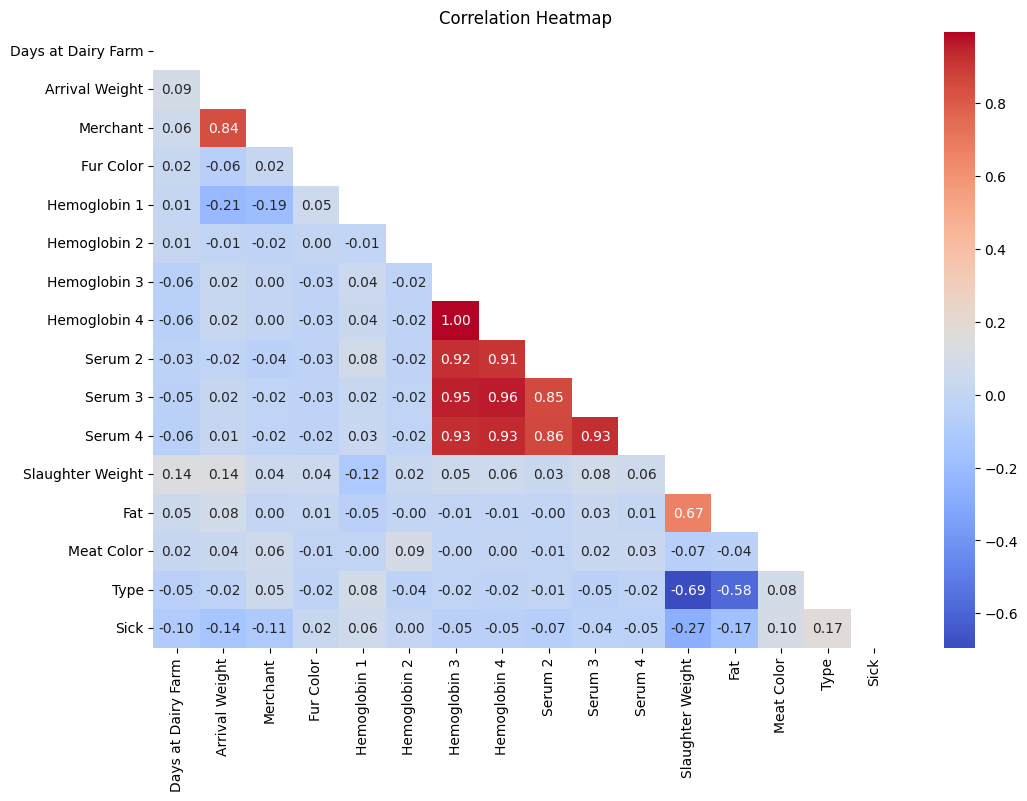

In [719]:
numeric_df = df_final_cleaned[['Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4', 'Serum 2', 
                               'Serum 3', 'Serum 4', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

sex_counts = df_final_cleaned['Sex'].value_counts()
print(f"Number of 1's (female): {sex_counts.get(1, 0)}")
print(f"Number of 0's (male): {sex_counts.get(0, 0)}")

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2308249 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [720]:
df_blood_2308249, df_slh_2308249P = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2308249 - blood samples',
    name_slh='Group 2308249 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [721]:
same_cows_2308249P = get_same_cows_ids(df_blood_2308249, df_slh_2308249P) 

In [722]:
len(same_cows_2308249P)

626

The blood sample data and slaughterhouse data are then combined:

In [723]:
df_combined_2308249 = combine_matching_cows(df_blood_2308249, df_slh_2308249P, same_cows_2308249P)
print(df_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [724]:
df_stallijst_2308249 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2308249 Stallijst'
)

df_final_combined_2308249 = combine_stallijst(df_combined_2308249, df_stallijst_2308249)

print(df_final_combined_2308249.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [725]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2308249, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [726]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [727]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4',
       'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking',
       'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum',
       'Slacht datum', 'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [728]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 123


Matching columns in the dataset are identified:

In [729]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [730]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Volgnr.', 'Koppel',
       'Type', 'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [731]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'HB4', 'S2', 'S3', 'S4', 'Type', 'Vetbedekking',
       'Kleur', 'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen',
       'Calf ID', 'Calf ID + Country', 'County ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Arrival weight', 'Sickness Date',
       'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [732]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               12             1.916933
HB3                              597            95.367412
HB4                              598            95.527157
S2                                12             1.916933
S3                               597            95.367412
S4                               598            95.527157
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      517            82.587859
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID     

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `HB4`, `S2`, `S3`, and `S4`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [733]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['HB4'] = df_final_cleaned['HB4'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)
df_final_cleaned['S4'] = df_final_cleaned['S4'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

HB1  HB2  HB3  HB4   S2   S3   S4 Type  Vetbedekking  Kleur  Gewicht  \
0  6.3  6.0  0.0  0.0  0.0  0.0  0.0   O0            20      4    123.0   
1  5.9  4.7  0.0  0.0  0.0  0.0  0.0   O0            20      4    120.0   
2  4.3  5.2  0.0  0.0  0.0  0.0  0.0   O0            20      4    128.5   
3  6.0  5.5  0.0  0.0  0.0  0.0  0.0   O-            20      5    107.9   
4  5.9  6.3  0.0  0.0  0.0  0.0  0.0   O0            30      5    142.4   

  Geboorte datum Slacht datum  Afwijkingen       Calf ID Calf ID + Country  \
0       5-2-2023    24-8-2023            0  217760131203   IE 217760131203   
1       8-2-2023    24-8-2023            1  222187992727   IE 222187992727   
2       7-2-2023    24-8-2023            0  224114582723   IE 224114582723   
3       1-2-2023    24-8-2023            0  215791893047   IE 215791893047   
4       4-2-2023    24-8-2023            0  224974482092   IE 224974482092   

  County ID                 Merchant  Sex Color Letter  Fur Color  \
0        IE  Van Beek Kalvermesterij    1            Z  Zwartbont   
1        IE  Van Beek Kalvermesterij    1            Z  Zwartbont   
2        IE  Van Beek Kalvermesterij    1            Z  Zwartbont   
3        IE  Van Beek Kalvermesterij    1            Z  Zwartbont   
4        IE  Van Beek Kalvermesterij    1            Z  Zwartbont   

  Arrival Date at Veal Farm  Days at diary farm    Stable  Arrival weight  \
0                2023-02-25                  20  Vd Borne            46.7   
1                2023-02-25                  17  Vd Borne            46.7   
2                2023-02-25                  18  Vd Borne            46.7   
3                2023-02-25                  24  Vd Borne            46.7   
4                2023-02-25                  21  Vd Borne            46.7   

  Sickness Date  Sick  
0           NaT     0  
1           NaT     0  
2           NaT     0  
3    2023-03-25     1  
4           NaT     0

This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [734]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'HB4': 'Hemoglobin 4',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'S4': 'Serum 4',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Type', 'Fat Covering', 'Meat Color',
       'Slaughter Weight', 'Birth Date', 'Slaughter Date', 'Abnormalities',
       'Calf ID', 'Country ID + Calf ID', 'Country ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Stable', 'Arrival Weight', 'Sickness Date',
       'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [735]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3',
    'Hemoglobin 4', 
    'Serum 2', 
    'Serum 3',
    'Serum 4',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2308249_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2308249_pali.columns)

df_final_cleaned_2308249_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4',
       'Serum 2', 'Serum 3', 'Serum 4', 'Sickness Date', 'Sick',
       'Slaughter Date', 'Slaughter Weight', 'Fat Covering', 'Meat Color',
       'Type', 'Abnormalities'],
      dtype='object')


Country ID + Calf ID Country ID       Calf ID Birth Date  Sex    Stable  \
106      IE 217760181190         IE  217760181190   2-2-2023    1  Vd Borne   
151      IE 218098751887         IE  218098751887   4-2-2023    1  Vd Borne   
46       IE 224114552687         IE  224114552687   3-2-2023    1  Vd Borne   
43       IE 213634892721         IE  213634892721  31-1-2023    1  Vd Borne   
182      IE 217906674757         IE  217906674757  20-1-2023    1  Vd Borne   

     Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
106                  23                2023-02-25            46.7   
151                  16                2023-02-20            46.0   
46                   22                2023-02-25            46.7   
43                   25                2023-02-25            46.7   
182                  31                2023-02-20            46.0   

                    Merchant  Fur Color Color Letter  Hemoglobin 1  \
106  Van Beek Kalvermesterij  Zwartbont            Z           5.4   
151   Cor van Dijk veehandel  Zwartbont            Z           5.3   
46   Van Beek Kalvermesterij  Zwartbont            Z           5.0   
43   Van Beek Kalvermesterij  Zwartbont            Z           5.7   
182   Cor van Dijk veehandel  Zwartbont            Z           6.5   

     Hemoglobin 2  Hemoglobin 3  Hemoglobin 4  Serum 2  Serum 3  Serum 4  \
106           5.0           0.0           0.0      0.0      0.0      0.0   
151           7.7           0.0           0.0      0.0      0.0      0.0   
46            5.0           0.0           0.0      0.0      0.0      0.0   
43            6.2           0.0           0.0      0.0      0.0      0.0   
182           8.0           5.7           5.3     17.0     25.0     18.0   

    Sickness Date  Sick Slaughter Date  Slaughter Weight  Fat Covering  \
106           NaT     0      22-8-2023             124.5            30   
151           NaT     0      22-8-2023             108.8            20   
46            NaT     0      24-8-2023             114.8            20   
43            NaT     0      24-8-2023             144.6            20   
182           NaT     0      22-8-2023             153.8            20   

     Meat Color Type  Abnormalities  
106           4   O0              0  
151           5   O-              0  
46            3   O-              0  
43            4   O0              0  
182           4   O0              0

In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [736]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    1
2          0     0         0    1
3          0     1         0    1
4          0     0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

Number of 1's (female): 626
Number of 0's (male): 0


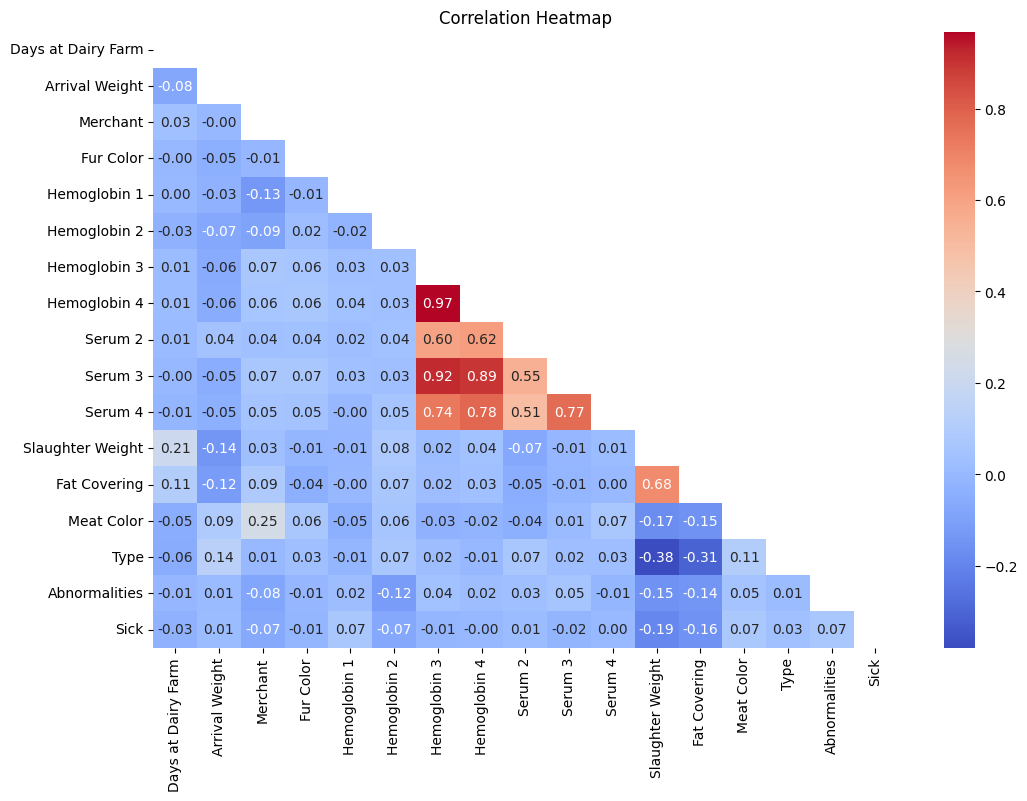

In [737]:
numeric_df = df_final_cleaned[['Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Hemoglobin 4', 'Serum 2', 
                               'Serum 3', 'Serum 4', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

sex_counts = df_final_cleaned['Sex'].value_counts()
print(f"Number of 1's (female): {sex_counts.get(1, 0)}")
print(f"Number of 0's (male): {sex_counts.get(0, 0)}")

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2229248

This section covers the data processing and analysis for **Group 2229248** from the `Borne` Farm.

### Group 2229248 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [738]:
df_blood_2229248, df_slh_2229248 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2229248 - blood samples',
    name_slh='Group 2229248 Slaughterhouse',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [739]:
same_cows_2229248 = get_same_cows_ids(df_blood_2229248, df_slh_2229248) 

In [740]:
len(same_cows_2229248)

303

The blood sample data and slaughterhouse data are then combined:

In [741]:
df_combined_2229248 = combine_matching_cows(df_blood_2229248, df_slh_2229248, same_cows_2229248)
print(df_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [742]:
df_stallijst_2229248 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2229248 Stallijst'
)

df_final_combined_2229248 = combine_stallijst(df_combined_2229248, df_stallijst_2229248)

print(df_final_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [743]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2229248, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [744]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [745]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [746]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 93


Matching columns in the dataset are identified:

In [747]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [748]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'WerkNr', 'Gewicht', 'Soort', 'Kleur',
       'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Slacht Datum',
       'Calf ID', 'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [749]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Slacht Datum', 'Calf ID', 'Calf ID + Country',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [750]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                2             0.660066
HB3                              280            92.409241
S2                                 2             0.660066
S3                               280            92.409241
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Slacht Datum                       0             0.000000
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [751]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

HB1  HB2  HB3   S2   S3  Gewicht  Soort  Kleur  Vet        Geboortedatum  \
0  5.4  6.8  0.0  0.0  0.0    129.6     12      5    2            7/13/2022   
1  7.1  7.2  0.0  0.0  0.0    133.5     12      5    2            7/16/2022   
2  6.3  5.9  0.0  0.0  0.0    147.2     11      4    3            7/17/2022   
3  6.5  6.1  0.0  0.0  0.0    173.5     11      4    3            7/16/2022   
4  6.5  6.1  0.0  0.0  0.0    162.3     12      4    3  2022-08-07 00:00:00   

  Slacht Datum     Calf ID Calf ID + Country County ID  Merchant  Sex  \
0   2023-06-02  1406655252     DE 1406655252        DE  lochimex    1   
1   2023-06-02  1406681809     DE 1406681809        DE  lochimex    1   
2   2023-06-02  1406572274     DE 1406572274        DE  lochimex    1   
3   2023-06-02  1406701934     DE 1406701934        DE  lochimex    1   
4   2023-06-02  1406572597     DE 1406572597        DE  lochimex    1   

  Color Letter         Fur Color Arrival Date at Veal Farm  \
0            Z         Zwartbont                2022-08-03   
1            Z         Zwartbont                2022-08-03   
2            U  Eenkleurig bruin                2022-08-03   
3            Z         Zwartbont                2022-08-03   
4            Z         Zwartbont                2022-08-03   

   Days at diary farm    Stable  Arrival weight Sickness Date  Sick  
0                  21  Vd Borne            41.0           NaT     0  
1                  18  Vd Borne            41.0           NaT     0  
2                  17  Vd Borne            41.0           NaT     0  
3                  18  Vd Borne            41.0           NaT     0  
4                  26  Vd Borne            41.0           NaT     0

This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [752]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Slacht Datum': 'Slaughter Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Slaughter Weight', 'Type', 'Meat Color', 'Fat', 'Birth Date',
       'Slaughter Date', 'Calf ID', 'Country ID + Calf ID', 'Country ID',
       'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [753]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2229248_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2229248_s.columns)

df_final_cleaned_2229248_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight', 'Fat',
       'Meat Color', 'Type'],
      dtype='object')


Country ID + Calf ID Country ID     Calf ID           Birth Date  Sex  \
102        DE 1504793808         DE  1504793808  2022-09-07 00:00:00    1   
30         DE 1406770051         DE  1406770051  2022-10-07 00:00:00    1   
80         DE 1269773951         DE  1269773951  2022-08-07 00:00:00    1   
104        DE 1604541459         DE  1604541459  2022-04-07 00:00:00    1   
120        DE 1406700971         DE  1406700971  2022-04-07 00:00:00    1   

       Stable  Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
102  Vd Borne                  17                2022-07-26            46.0   
30   Vd Borne                  17                2022-07-27            42.0   
80   Vd Borne                  19                2022-07-27            42.0   
104  Vd Borne                  22                2022-07-26            46.0   
120  Vd Borne                  23                2022-07-27            42.0   

                    Merchant         Fur Color Color Letter  Hemoglobin 1  \
102  Van Beek Kalvermesterij         Zwartbont            Z           5.6   
30                  lochimex  Eenkleurig bruin            U           6.6   
80                  lochimex  Eenkleurig bruin            U           5.6   
104  Van Beek Kalvermesterij         Zwartbont            Z           5.9   
120                 lochimex          Roodbont            R           5.8   

     Hemoglobin 2  Hemoglobin 3  Serum 2  Serum 3 Sickness Date  Sick  \
102           6.9           0.0      0.0      0.0           NaT     0   
30            6.3           0.0      0.0      0.0    2022-08-14     1   
80            6.1           0.0      0.0      0.0           NaT     0   
104           6.1           0.0      0.0      0.0           NaT     0   
120           6.7           0.0      0.0      0.0           NaT     0   

    Slaughter Date  Slaughter Weight  Fat  Meat Color  Type  
102     2023-09-02            147.80    3           6    11  
30      2023-06-02            140.10    2           4    14  
80      2023-08-02            161.60    2           6    10  
104     2023-09-02            132.00    1           5    13  
120     2023-09-02            148.39    2           6    11

In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [754]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Merchant', 'Sex']].head(5))

   Fur Color  Merchant  Sex
0          0         0    1
1          0         0    1
2          1         0    1
3          0         0    1
4          0         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

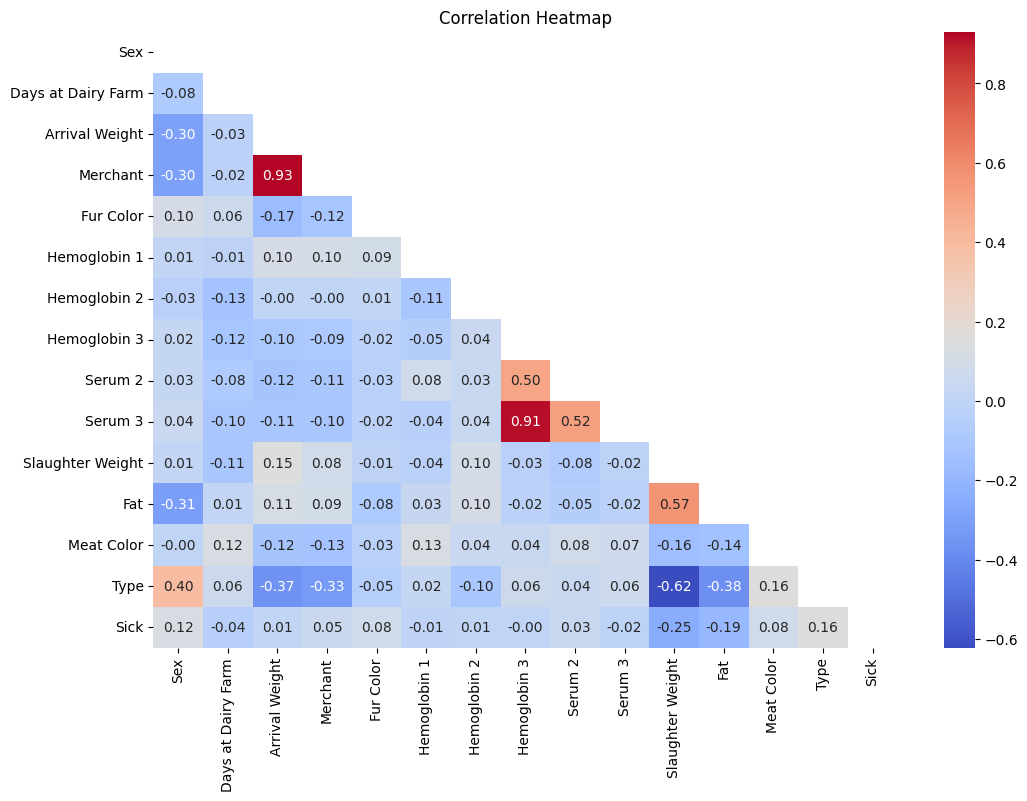

In [755]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2229248 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [756]:
df_blood_2229248, df_slh_2229248P = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2229248 - blood samples',
    name_slh='Group 2229248 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [757]:
same_cows_2229248P = get_same_cows_ids(df_blood_2229248, df_slh_2229248P) 

In [758]:
len(same_cows_2229248P)

120

The blood sample data and slaughterhouse data are then combined:

In [759]:
df_combined_2229248 = combine_matching_cows(df_blood_2229248, df_slh_2229248P, same_cows_2229248P)
print(df_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [760]:
df_stallijst_2229248 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2229248 Stallijst'
)

df_final_combined_2229248 = combine_stallijst(df_combined_2229248, df_stallijst_2229248)

print(df_final_combined_2229248.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [761]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2229248, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [762]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [763]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Birth Date', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Stable', 'Handelaar', 'Arrival date',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [764]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 47


Matching columns in the dataset are identified:

In [765]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [766]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'Calf ID + Country', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Stable',
       'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [767]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'Calf ID + Country', 'County ID', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [768]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.840336
HB3                              116            97.478992
S2                                 1             0.840336
S3                               116            97.478992
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                       84            70.588235
Calf ID                            0             0.000000
Calf ID + Country                  0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex           

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [769]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

HB1  HB2  HB3   S2   S3 Type  Vetbedekking  Kleur  Gewicht Geboorte datum  \
0  6.0  5.2  0.0  0.0  0.0   O-            20      5    124.3      14-7-2022   
1  7.3  5.7  0.0  0.0  0.0   O-            30      6    128.5      17-7-2022   
2  6.2  5.3  0.0  0.0  0.0   P0            20      5    122.8       5-7-2022   
3  5.7  6.4  0.0  0.0  0.0   O+            30      6    160.6      17-7-2022   
4  5.4  5.3  0.0  0.0  0.0   O-            20      5    124.2      14-7-2022   

  Slacht datum  Afwijkingen     Calf ID Calf ID + Country County ID  \
0     6-2-2023            0  1406570666     DE 1406570666        DE   
1     6-2-2023            1  1406686947     DE 1406686947        DE   
2     6-2-2023            1  1406570654     DE 1406570654        DE   
3     6-2-2023            0  1604557390     DE 1604557390        DE   
4     6-2-2023            0  1406570665     DE 1406570665        DE   

     Merchant  Sex Color Letter  Fur Color Arrival Date at Veal Farm  \
0  Pali BV BA    0            Z  Zwartbont                2022-08-03   
1  Pali BV BA    0            Z  Zwartbont                2022-08-03   
2  Pali BV BA    0            Z  Zwartbont                2022-08-03   
3  Pali BV BA    1            Z  Zwartbont                2022-08-03   
4  Pali BV BA    0            Z  Zwartbont                2022-08-03   

   Days at diary farm    Stable  Arrival weight Sickness Date  Sick  
0                  20  Vd Borne            43.0    2022-08-29     1  
1                  17  Vd Borne            43.0           NaT     0  
2                  29  Vd Borne            43.0           NaT     0  
3                  17  Vd Borne            43.0    2022-08-30     1  
4                  20  Vd Borne            43.0    2022-10-15     1

This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [770]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID + Calf ID',
       'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [771]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2229248_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2229248_pali.columns)

df_final_cleaned_2229248_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


Country ID + Calf ID Country ID     Calf ID Birth Date  Sex    Stable  \
96        DE 1406545557         DE  1406545557  19-7-2022    1  Vd Borne   
44        DE 1406496841         DE  1406496841  14-7-2022    1  Vd Borne   
68        DE 1269728102         DE  1269728102  13-7-2022    1  Vd Borne   
57        DE 1505105598         DE  1505105598  12-7-2022    1  Vd Borne   
22        DE 1406686953         DE  1406686953  19-7-2022    1  Vd Borne   

    Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
96                  15                2022-08-03            49.0   
44                  20                2022-08-03            41.0   
68                  21                2022-08-03            41.0   
57                  15                2022-07-27            42.0   
22                  15                2022-08-03            43.0   

                   Merchant  Fur Color Color Letter  Hemoglobin 1  \
96  Van Beek Kalvermesterij  Zwartbont            Z           6.2   
44                 lochimex  Zwartbont            Z           5.9   
68                 lochimex  Zwartbont            Z           6.3   
57                 lochimex  Zwartbont            Z           5.2   
22               Pali BV BA   Roodbont            R           7.0   

    Hemoglobin 2  Hemoglobin 3  Serum 2  Serum 3 Sickness Date  Sick  \
96           5.9           0.0      0.0      0.0           NaT     0   
44           5.7           0.0      0.0      0.0           NaT     0   
68           5.9           0.0      0.0      0.0    2022-07-08     1   
57           5.8           0.0      0.0      0.0    2022-04-09     1   
22           7.4           0.0      0.0      0.0           NaT     0   

   Slaughter Date  Slaughter Weight  Fat Covering  Meat Color Type  \
96       6-2-2023             168.4            30           6   R0   
44       6-2-2023             157.8            30           5   O-   
68       6-2-2023             129.9            20           3   P+   
57       3-2-2023              81.3            10           7   P0   
22       3-2-2023             114.6            10           7   P+   

    Abnormalities  
96              0  
44              0  
68              0  
57              1  
22              0

In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [772]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    0
1          0     0         0    0
2          0     1         0    0
3          0     2         0    1
4          0     0         0    0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

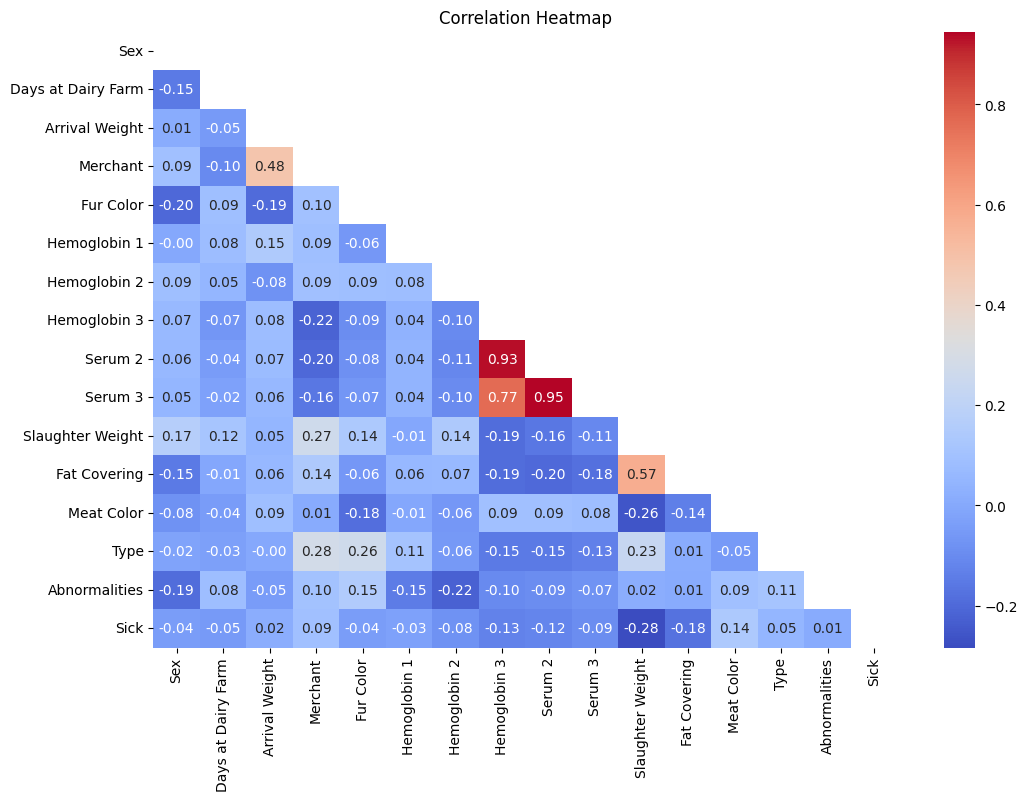

In [773]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Group 2151247

This section covers the data processing and analysis for **Group 2151247** from the `Borne` Farm.

### Group 2151247 S

Will be part of the SlaughterhouseS dataset.

The blood and slaughterhouse data are loaded using the following code:

In [774]:
df_blood_2151247, df_slh_2151247 = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2151247 - blood samples',
    name_slh='Group 2151247 Slaughterhouse',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [775]:
same_cows_2151247 = get_same_cows_ids(df_blood_2151247, df_slh_2151247) 

In [776]:
len(same_cows_2151247)

518

The blood sample data and slaughterhouse data are then combined:

In [777]:
df_combined_2151247 = combine_matching_cows(df_blood_2151247, df_slh_2151247, same_cows_2151247)
print(df_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [778]:
df_stallijst_2151247 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2151247 Stallijst'
)

df_final_combined_2151247 = combine_stallijst(df_combined_2151247, df_stallijst_2151247)

print(df_final_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [779]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2151247, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [780]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'ID nummer', 'WerkNr', 'Gewicht', 'Soort',
       'Kleur', 'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Hoofd',
       'Tong', 'Darmen', 'Long', 'Hartzwezerik', 'Keelzwezerik', 'Hart',
       'Nieren', 'Lever', 'Kalf', 'Overziener', 'Antibiotica', 'Bacteriologie',
       'Prostaat', 'Spuitnek', 'Spuitborst', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [781]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'ID nummer', 'WerkNr', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


**No slaughter dates present for this group.**

The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [782]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 184


Matching columns in the dataset are identified:

In [783]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [784]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'WerkNr', 'Gewicht', 'Soort', 'Kleur',
       'Vet', 'Geboortedatum', 'Leeftijdscode', 'Sekse', 'Calf ID', 'X',
       'County ID', 'Birth Date', 'Merchant', 'Sex', 'Color Letter',
       'Fur Color', 'Arrival Date at Veal Farm', 'Days at diary farm',
       'Calf ID + Country', 'Stable', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [785]:
additional_columns_to_drop = ['WerkNr', 'Leeftijdscode', 'Sekse', 'Lev.nr', 'X', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Gewicht', 'Soort', 'Kleur', 'Vet',
       'Geboortedatum', 'Calf ID', 'County ID', 'Merchant', 'Sex',
       'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [786]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                               11             2.123552
HB3                              495            95.559846
S2                                11             2.123552
S3                               495            95.559846
Gewicht                            0             0.000000
Soort                              0             0.000000
Kleur                              0             0.000000
Vet                                0             0.000000
Geboortedatum                      0             0.000000
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter                       0             0.000000
Fur Color                          0             0.000000
Arrival Date a

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [787]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

HB1  HB2  HB3   S2   S3  Gewicht  Soort  Kleur  Vet        Geboortedatum  \
0  6.3  5.1  0.0  0.0  0.0    123.2     12      5    2  2021-06-12 00:00:00   
1  6.3  5.7  0.0  0.0  0.0    118.6     13      5    2  2021-10-12 00:00:00   
2  5.5  5.9  0.0  0.0  0.0    155.2     12      6    2  2021-07-12 00:00:00   
3  6.3  6.1  0.0  0.0  0.0    146.8     13      6    2  2021-09-12 00:00:00   
4  5.5  7.8  0.0  0.0  0.0    142.5     12     10    2  2021-09-12 00:00:00   

     Calf ID County ID     Merchant  Sex Color Letter  Fur Color  \
0  892646108        NL  sloot, bert    0           ZB  Zwartbont   
1  578626691        NL  sloot, bert    1           ZB  Zwartbont   
2  609609778        NL  sloot, bert    1           ZB  Zwartbont   
3  567928315        NL  sloot, bert    1           ZB  Zwartbont   
4  573265196        NL  sloot, bert    1           ZB  Zwartbont   

  Arrival Date at Veal Farm  Days at diary farm Calf ID + Country    Stable  \
0                2021-12-23                  17      NL 892646108  Vd Borne   
1                2021-12-23                  13      NL 578626691  Vd Borne   
2                2021-12-23                  16      NL 609609778  Vd Borne   
3                2021-12-23                  14      NL 567928315  Vd Borne   
4                2021-12-23                  14      NL 573265196  Vd Borne   

   Arrival weight Sickness Date  Sick  
0            44.0           NaT     0  
1            44.0           NaT     0  
2            44.0           NaT     0  
3            44.0           NaT     0  
4            44.0           NaT     0

This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [788]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Gewicht': 'Slaughter Weight',
    'Soort': 'Type',
    'Kleur': 'Meat Color',
    'Vet': 'Fat', 
    'Geboortedatum': 'Birth Date',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Slaughter Weight', 'Type', 'Meat Color', 'Fat', 'Birth Date',
       'Calf ID', 'Country ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at Dairy Farm',
       'Country ID + Calf ID', 'Stable', 'Arrival Weight', 'Sickness Date',
       'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [789]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Weight',
    'Fat', 
    'Meat Color',
    'Type'
]

df_final_cleaned_2151247_s = df_final_cleaned[new_column_order]

print(df_final_cleaned_2151247_s.columns)

df_final_cleaned_2151247_s.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Weight', 'Fat', 'Meat Color',
       'Type'],
      dtype='object')


Country ID + Calf ID Country ID     Calf ID           Birth Date  Sex  \
171        DE 1604413371         DE  1604413371           11/29/2021    1   
102        DE 1406576907         DE  1406576907  2021-01-12 00:00:00    1   
209         NL 619480594         NL   619480594  2021-07-12 00:00:00    0   
327        DE 1306676504         DE  1306676504  2021-05-12 00:00:00    1   
251        DE 1270654120         DE  1270654120           11/30/2021    1   

       Stable  Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
171  Vd Borne                  16                2021-12-15            42.0   
102  Vd Borne                  21                2021-12-22            44.0   
209  Vd Borne                  16                2021-12-23            44.0   
327  Vd Borne                  16                2021-12-21            47.5   
251  Vd Borne                  15                2021-12-15            47.5   

           Merchant         Fur Color Color Letter  Hemoglobin 1  \
171        lochimex         Zwartbont           ZB           5.4   
102        lochimex  Eenkleurig bruin           EB           6.1   
209     sloot, bert         Zwartbont           ZB           4.2   
327  Gebr. Fuite BV         Blauwbont           BB           4.7   
251        Boerkamp  Eenkleurig bruin           EB           6.6   

     Hemoglobin 2  Hemoglobin 3  Serum 2  Serum 3 Sickness Date  Sick  \
171           5.5           0.0      0.0      0.0           NaT     0   
102           6.6           0.0      0.0      0.0           NaT     0   
209           5.8           0.0      0.0      0.0           NaT     0   
327           6.0           0.0      0.0      0.0           NaT     0   
251           6.0           0.0      0.0      0.0           NaT     0   

     Slaughter Weight  Fat  Meat Color  Type  
171             155.2    2           5    12  
102             146.2    2           5    11  
209             123.7    3           6    12  
327             169.9    2           5     8  
251             147.2    2           6    11

In this section, categorical variables such as `Fur Color` and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [790]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0    12         0    0
1          0    13         0    1
2          0    12         0    1
3          0    13         0    1
4          0    12         0    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

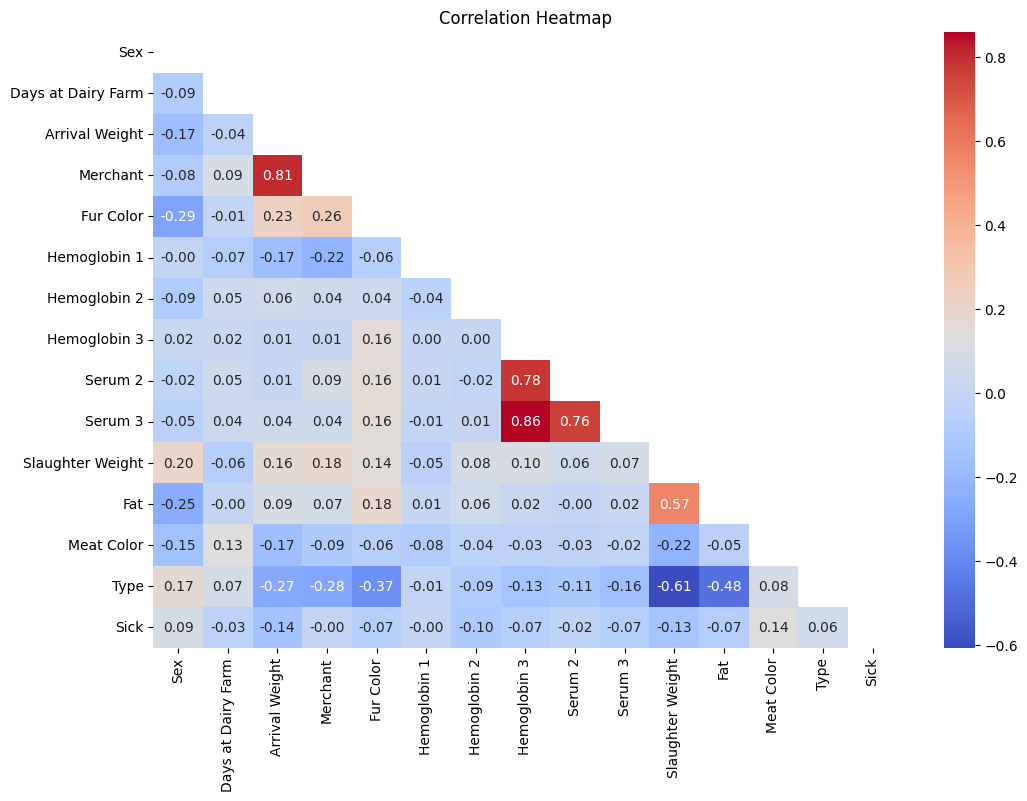

In [791]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat', 'Meat Color', 'Type', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

### Group 2151247 Pali

Will be part of the SlaughterhouseP (Pali) dataset.

The blood and slaughterhouse data are loaded using the following code:

In [792]:
df_blood_2151247, df_slh_2151247P = load_group_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx",
    name_blood='Group 2151247 - blood samples',
    name_slh='Group 2151247 SlaughterhouseP',
)

To identify (and count) identical calves in both datasets, the following code is used:

In [793]:
same_cows_2151247P = get_same_cows_ids(df_blood_2151247, df_slh_2151247P) 

In [794]:
len(same_cows_2151247P)

145

The blood sample data and slaughterhouse data are then combined:

In [795]:
df_combined_2151247 = combine_matching_cows(df_blood_2151247, df_slh_2151247P, same_cows_2151247P)
print(df_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen'],
      dtype='object')


The stallijst data is loaded next and combined with the previously merged data:

In [796]:
df_stallijst_2151247 = load_stallijst_data(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_stallijst='Group 2151247 Stallijst'
)

df_final_combined_2151247 = combine_stallijst(df_combined_2151247, df_stallijst_2151247)

print(df_final_combined_2151247.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country'],
      dtype='object')


The arrival weights are then loaded and added to the combined dataset:

In [797]:
df_arrival_weights = load_arrival_weights(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_arrival_weights='Arrival Weights'
)

df_final_with_weights = add_arrival_weight(df_final_combined_2151247, df_arrival_weights)

print(df_final_with_weights.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight'],
      dtype='object')


Individual treatments are loaded next and a status is added (to the combined dataset) whether a calf has been sick or not:

In [798]:
df_individual_treatments = load_individual_treatments(
    "C:/Users/wimva/OneDrive/Documenten/Semestersiete/Groep/Borne structured data.xlsx", 
    name_individual_treatments='Individual treatments'
)

df_final_with_sickness = add_sick_status(df_final_with_weights, df_individual_treatments)

print(df_final_with_sickness.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'HB4', 'HB5', 'S2', 'S3', 'S4',
       'S5', 'Haarkleur', 'cow_id', 'Volgnr.', 'Koppel', 'ID nummer', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Handelaar',
       'Arrival date', 'Arrival weight', 'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


Empty columns are checked for and removed:

In [799]:
df_cleaned_empty_columns = df_final_with_sickness.dropna(axis=1, how='all')

print(df_cleaned_empty_columns.columns)

Index(['Land', 'Levensnr', 'HB1', 'HB2', 'HB3', 'S2', 'S3', 'cow_id',
       'Volgnr.', 'Koppel', 'ID nummer', 'Type', 'Vetbedekking', 'Kleur',
       'Sexe', 'Gewicht', 'Correctie', 'UBN', 'Geboorte datum', 'Slacht datum',
       'Huisvesting', 'Categorie', 'Afwijkingen', 'Calf ID', 'X', 'County ID',
       'Birth Date', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Handelaar', 'Arrival date', 'Arrival weight', 'Lev.nr',
       'Sickness Date', 'Sick'],
      dtype='object')


The following code calculates and displays the **total number of sick calves** in the cleaned dataset. This is achieved by summing all the values in the 'Sick' column, where a value of 1 indicates a sick calf.

In [800]:
count_sick = df_cleaned_empty_columns['Sick'].sum()

print(f'Count of sick calves: {count_sick}')

Count of sick calves: 45


Matching columns in the dataset are identified:

In [801]:
matching_columns = []

columns = df_cleaned_empty_columns.columns

for i in range(len(columns)):
    for j in range(i + 1, len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        if df_cleaned_empty_columns[col1].equals(df_cleaned_empty_columns[col2]):
            matching_columns.append((col1, col2))

print(f"Total matching columns: {len(matching_columns)}")
for col1, col2 in matching_columns:
    print(f"{col1} matches {col2}")

Total matching columns: 7
Land matches County ID
Levensnr matches Calf ID
cow_id matches ID nummer
cow_id matches Calf ID + Country
ID nummer matches Calf ID + Country
Merchant matches Handelaar
Arrival Date at Veal Farm matches Arrival date


Identified matching columns are dropped:

In [802]:
columns_to_drop = ['Arrival date', 'Handelaar', 'ID nummer', 'cow_id', 'Levensnr', 'Land']
df_cleaned_duplicates = df_cleaned_empty_columns.drop(columns=columns_to_drop)

print(df_cleaned_duplicates.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Volgnr.', 'Koppel', 'Type',
       'Vetbedekking', 'Kleur', 'Sexe', 'Gewicht', 'Correctie', 'UBN',
       'Geboorte datum', 'Slacht datum', 'Huisvesting', 'Categorie',
       'Afwijkingen', 'Calf ID', 'X', 'County ID', 'Birth Date', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at diary farm', 'Calf ID + Country', 'Stable', 'Arrival weight',
       'Lev.nr', 'Sickness Date', 'Sick'],
      dtype='object')


The following 'useless' columns, or column duplicates with unmatched values for the same information, were dropped to refine the dataset:

In [803]:
additional_columns_to_drop = ['Volgnr.', 'Koppel', 'Correctie', 'UBN', 'Huisvesting', 'X', 'Categorie', 'Sexe', 'Lev.nr', 'Birth Date']

df_final_cleaned = df_cleaned_duplicates.drop(columns=additional_columns_to_drop)

print(df_final_cleaned.columns)

Index(['HB1', 'HB2', 'HB3', 'S2', 'S3', 'Type', 'Vetbedekking', 'Kleur',
       'Gewicht', 'Geboorte datum', 'Slacht datum', 'Afwijkingen', 'Calf ID',
       'County ID', 'Merchant', 'Sex', 'Color Letter', 'Fur Color',
       'Arrival Date at Veal Farm', 'Days at diary farm', 'Calf ID + Country',
       'Stable', 'Arrival weight', 'Sickness Date', 'Sick'],
      dtype='object')


This section calculates the count and percentage of **missing values (NaN)** for each column in the dataframe.

In [804]:
nan_counts = df_final_cleaned.isna().sum()
total_counts = len(df_final_cleaned)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
HB1                                0             0.000000
HB2                                1             0.689655
HB3                              141            97.241379
S2                                 1             0.689655
S3                               141            97.241379
Type                               0             0.000000
Vetbedekking                       0             0.000000
Kleur                              0             0.000000
Gewicht                            0             0.000000
Geboorte datum                     0             0.000000
Slacht datum                       0             0.000000
Afwijkingen                      109            75.172414
Calf ID                            0             0.000000
County ID                          0             0.000000
Merchant                           0             0.000000
Sex                                0             0.000000
Color Letter  

To address the missing values identified in the previous step, specific columns are filled with zeros or transformed. This step is essential to ensure that subsequent analyses are not biased or erroneous due to missing data.

- Columns `HB2`, `HB3`, `S2`, and `S3`: Filled with zeros where values were missing.
- Column `Afwijkingen`: Transformed to indicate whether abnormalities are present (1) or not (0).
- Column `Sex`: Encoded to numerical values, with 'S' (female) mapped to 1 and 'V' (male) mapped to 0.

In [805]:
df_final_cleaned['HB2'] = df_final_cleaned['HB2'].fillna(0)
df_final_cleaned['HB3'] = df_final_cleaned['HB3'].fillna(0)
df_final_cleaned['S2'] = df_final_cleaned['S2'].fillna(0)
df_final_cleaned['S3'] = df_final_cleaned['S3'].fillna(0)

df_final_cleaned['Afwijkingen'] = df_final_cleaned['Afwijkingen'].apply(lambda x: 0 if pd.isna(x) else 1)

df_final_cleaned['Sex'] = df_final_cleaned['Sex'].map({'S': 1, 'V': 0}).astype(int)

df_final_cleaned.head()

HB1  HB2  HB3   S2   S3 Type  Vetbedekking  Kleur  Gewicht Geboorte datum  \
0  5.3  6.5  0.0  0.0  0.0   O-            20      5    157.1     29-11-2021   
1  5.5  6.3  0.0  0.0  0.0   O-            20      5    140.1     27-11-2021   
2  6.0  5.8  0.0  0.0  0.0   O-            20      6    146.7     27-11-2021   
3  6.0  5.1  0.0  0.0  0.0   O-            20      6    142.5     28-11-2021   
4  5.7  5.6  0.0  0.0  0.0   O-            20      5    144.9      1-12-2021   

  Slacht datum  Afwijkingen     Calf ID County ID     Merchant  Sex  \
0     1-7-2022            0  1406595212        DE     lochimex    1   
1     1-7-2022            0  1604424000        DE     lochimex    1   
2     1-7-2022            0  1406533395        DE     lochimex    1   
3     1-7-2022            0  1406534595        DE     lochimex    1   
4     1-7-2022            0   681201068        NL  sloot, bert    1   

  Color Letter  Fur Color Arrival Date at Veal Farm  Days at diary farm  \
0           ZB  Zwartbont                2021-12-15                  16   
1           ZB  Zwartbont                2021-12-15                  18   
2           ZB  Zwartbont                2021-12-15                  18   
3           ZB  Zwartbont                2021-12-15                  17   
4           RB   Roodbont                2021-12-23                  22   

  Calf ID + Country    Stable  Arrival weight Sickness Date  Sick  
0     DE 1406595212  Vd Borne            42.0           NaT     0  
1     DE 1604424000  Vd Borne            42.0           NaT     0  
2     DE 1406533395  Vd Borne            42.0    2022-08-02     1  
3     DE 1406534595  Vd Borne            42.0           NaT     0  
4      NL 681201068  Vd Borne            44.0           NaT     0

This section provides a mapping of original column names to translated and more descriptive names for better clarity in data analysis (aids in understanding the dataset without requiring knowledge of the original naming conventions).

In [806]:
translation_dict = {
    'HB1': 'Hemoglobin 1',
    'HB2': 'Hemoglobin 2',
    'HB3': 'Hemoglobin 3',
    'S2': 'Serum 2',
    'S3': 'Serum 3',
    'Type': 'Type',
    'Vetbedekking': 'Fat Covering',
    'Kleur': 'Meat Color',
    'Gewicht': 'Slaughter Weight',
    'Geboorte datum': 'Birth Date',
    'Slacht datum': 'Slaughter Date',
    'Afwijkingen': 'Abnormalities',
    'Calf ID': 'Calf ID',
    'Calf ID + Country': 'Country ID + Calf ID',
    'County ID': 'Country ID',
    'Merchant': 'Merchant',
    'Sex': 'Sex',
    'Color Letter': 'Color Letter',
    'Fur Color': 'Fur Color',
    'Arrival Date at Veal Farm': 'Arrival Date at Veal Farm',
    'Days at diary farm': 'Days at Dairy Farm',
    'Stable': 'Stable',
    'Arrival weight': 'Arrival Weight',
    'Sickness Date': 'Sickness Date',
    'Sick': 'Sick'
}

df_final_cleaned.rename(columns=translation_dict, inplace=True)

print(df_final_cleaned.columns)

Index(['Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Type', 'Fat Covering', 'Meat Color', 'Slaughter Weight', 'Birth Date',
       'Slaughter Date', 'Abnormalities', 'Calf ID', 'Country ID', 'Merchant',
       'Sex', 'Color Letter', 'Fur Color', 'Arrival Date at Veal Farm',
       'Days at Dairy Farm', 'Country ID + Calf ID', 'Stable',
       'Arrival Weight', 'Sickness Date', 'Sick'],
      dtype='object')


Reordering the columns in the dataframe helps streamline the structure of the dataset for better readability and analysis. The sample function is used to display a few random rows. This quick inspection helps verify the integrity and structure of the dataset after preprocessing steps.

In [807]:
new_column_order = [
    'Country ID + Calf ID',
    'Country ID',
    'Calf ID',
    'Birth Date',
    'Sex',
    'Stable',
    'Days at Dairy Farm',
    'Arrival Date at Veal Farm',
    'Arrival Weight',
    'Merchant',
    'Fur Color',
    'Color Letter', 
    'Hemoglobin 1', 
    'Hemoglobin 2', 
    'Hemoglobin 3', 
    'Serum 2', 
    'Serum 3',
    'Sickness Date', 
    'Sick', 
    'Slaughter Date', 
    'Slaughter Weight',
    'Fat Covering', 
    'Meat Color',
    'Type', 
    'Abnormalities'
]

df_final_cleaned_2151247_pali = df_final_cleaned[new_column_order]

print(df_final_cleaned_2151247_pali.columns)

df_final_cleaned_2151247_pali.sample(5)

Index(['Country ID + Calf ID', 'Country ID', 'Calf ID', 'Birth Date', 'Sex',
       'Stable', 'Days at Dairy Farm', 'Arrival Date at Veal Farm',
       'Arrival Weight', 'Merchant', 'Fur Color', 'Color Letter',
       'Hemoglobin 1', 'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 'Serum 3',
       'Sickness Date', 'Sick', 'Slaughter Date', 'Slaughter Weight',
       'Fat Covering', 'Meat Color', 'Type', 'Abnormalities'],
      dtype='object')


Country ID + Calf ID Country ID     Calf ID Birth Date  Sex    Stable  \
14          NL 711718706         NL   711718706  9-12-2021    1  Vd Borne   
109         NL 632896891         NL   632896891  7-12-2021    1  Vd Borne   
111         NL 688895705         NL   688895705  6-12-2021    0  Vd Borne   
76         DE 1406528490         DE  1406528490  2-12-2021    1  Vd Borne   
136        DE 1604498400         DE  1604498400  4-12-2021    1  Vd Borne   

     Days at Dairy Farm Arrival Date at Veal Farm  Arrival Weight  \
14                   14                2021-12-23            44.0   
109                  16                2021-12-23            44.0   
111                  17                2021-12-23            44.0   
76                   20                2021-12-22            44.0   
136                  18                2021-12-22            44.0   

        Merchant  Fur Color Color Letter  Hemoglobin 1  Hemoglobin 2  \
14   sloot, bert   Roodbont           RB           6.9           7.0   
109  sloot, bert  Zwartbont           ZB           4.1           5.2   
111  sloot, bert  Zwartbont           ZB           7.2           7.3   
76      lochimex  Zwartbont           ZB           6.6           5.4   
136     lochimex  Zwartbont           ZB           6.2           5.8   

     Hemoglobin 3  Serum 2  Serum 3 Sickness Date  Sick Slaughter Date  \
14            0.0      0.0      0.0    2022-02-22     1      30-6-2022   
109           0.0      0.0      0.0           NaT     0      30-6-2022   
111           0.0      0.0      0.0           NaT     0      30-6-2022   
76            0.0      0.0      0.0           NaT     0      29-6-2022   
136           0.0      0.0      0.0           NaT     0      29-6-2022   

     Slaughter Weight  Fat Covering  Meat Color Type  Abnormalities  
14               99.7            10           8   P0              0  
109             129.3            20           5   P+              0  
111             124.7            30           7   O-              0  
76              122.6            20           9   O-              0  
136             147.9            20           5   O0              0

In this section, categorical variables such as `Fur Color`, `Type`, and `Merchant` are transformed into numerical representations using **factorization**. This transformation allows for better handling of these variables in subsequent analyses and model training.

In [808]:
df_final_cleaned['Fur Color'] = pd.factorize(df_final_cleaned['Fur Color'])[0]
df_final_cleaned['Type'] = pd.factorize(df_final_cleaned['Type'])[0]
df_final_cleaned['Merchant'] = pd.factorize(df_final_cleaned['Merchant'])[0]

print(df_final_cleaned[['Fur Color', 'Type', 'Merchant', 'Sex']].head(5))

   Fur Color  Type  Merchant  Sex
0          0     0         0    1
1          0     0         0    1
2          0     0         0    1
3          0     0         0    1
4          1     0         1    1


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

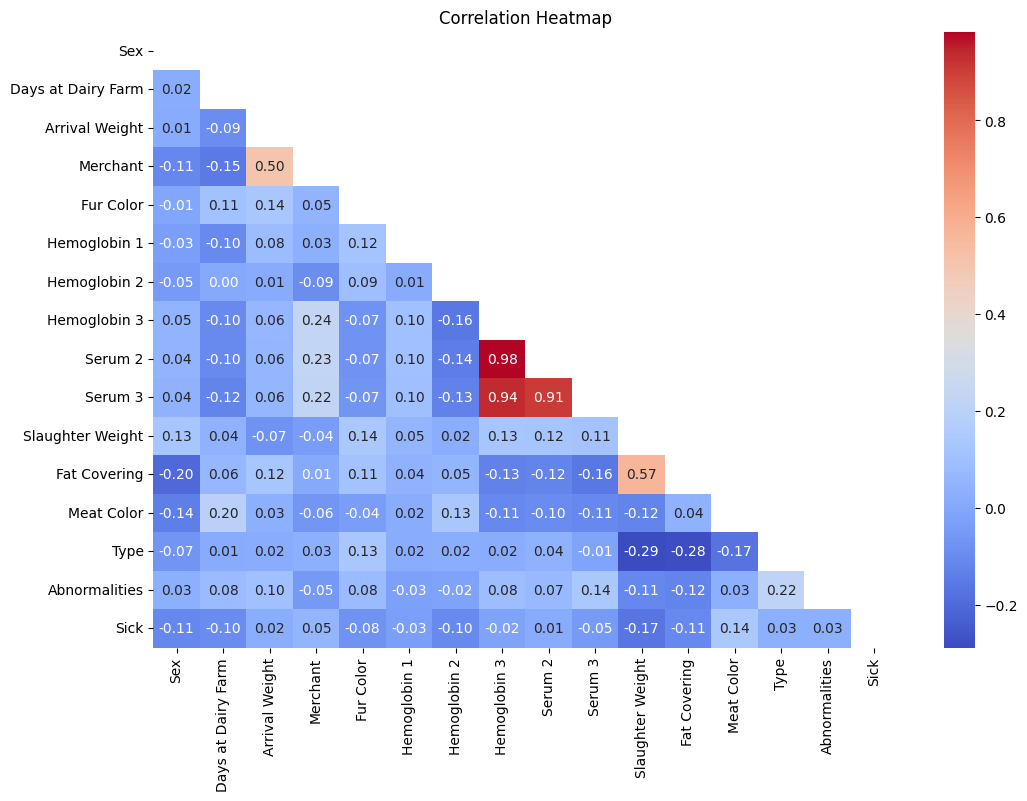

In [809]:
numeric_df = df_final_cleaned[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                               'Merchant', 'Fur Color', 'Hemoglobin 1', 
                               'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                               'Serum 3', 'Slaughter Weight', 
                               'Fat Covering', 'Meat Color', 'Type', 
                               'Abnormalities', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

## Combined Data (Borne farm)

### Data SlaughterhouseS

Two of the previously cleaned and analysed dataframes (from Group 2308249 S & Group 2229248 S) are merged into a single dataframe. This allows for a consolidated analysis of most of the (SlaughterhouseS) calf records.

Group 2151247 S is not merged since it is incomplete (slaughter date column missing).

Additionally, the total number of rows (calves) in the merged dataset is printed for reference, along with a count of sick calves, providing an initial overview of the data’s size and distribution.

In [810]:
combined_df = pd.concat([
    df_final_cleaned_2308249_s,
    df_final_cleaned_2229248_s
], ignore_index=True)

print(len(combined_df))

count_sick = combined_df['Sick'].sum()
print(f'Count of sick calves: {count_sick}')

849
Count of sick calves: 251


This cell introduces a new feature, `Season`, which categorizes each calf's birth season based on its birth month. The custom function `get_season()` defines the four seasons, and each calf is assigned a season accordingly. This is followed by converting the season labels into numeric values under the `Season_Born` column, facilitating potential model use.

A sample of the `Birth Date`, `Season`, and `Season_Born` columns is displayed to verify the transformation, and the distribution of calves by birth season is printed to assess seasonal data balance.

In [811]:
combined_df['Birth Date'] = pd.to_datetime(combined_df['Birth Date'], dayfirst=True)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

combined_df['Season'] = combined_df['Birth Date'].dt.month.apply(get_season)

combined_df['Season_Born'] = pd.factorize(combined_df['Season'])[0]

print(combined_df[['Birth Date', 'Season', 'Season_Born']].head())
season_counts = combined_df['Season'].value_counts()
print("Number of calves born in each season:")
print(season_counts)

  Birth Date  Season  Season_Born
0 2023-01-02  Winter            0
1 2023-07-02  Summer            1
2 2023-07-02  Summer            1
3 2023-07-02  Summer            1
4 2023-05-02  Spring            2
Number of calves born in each season:
Season
Winter    422
Summer    223
Spring    125
Autumn     79
Name: count, dtype: int64


This section calculates and presents **missing values (NaNs)** for each column. The output includes both the count and percentage of NaNs relative to the dataset's total size, providing insight into data completeness.

In [812]:
nan_counts = combined_df.isna().sum()
total_counts = len(combined_df)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
Country ID + Calf ID               0             0.000000
Country ID                         0             0.000000
Calf ID                            0             0.000000
Birth Date                         0             0.000000
Sex                                0             0.000000
Stable                             0             0.000000
Days at Dairy Farm                 0             0.000000
Arrival Date at Veal Farm          0             0.000000
Arrival Weight                     0             0.000000
Merchant                           0             0.000000
Fur Color                          0             0.000000
Color Letter                       0             0.000000
Hemoglobin 1                       0             0.000000
Hemoglobin 2                       0             0.000000
Hemoglobin 3                       0             0.000000
Serum 2                            0             0.000000
Serum 3       

The categorical columns `Fur Color`, `Merchant`, and `Country ID` are transformed into numerical codes to enable their use in correlation analysis and modeling. This factorization assigns unique integer values to each category in these columns. Following the transformation, the code prints the number of unique values in each of these columns to confirm the encoding. Additionally, a sample of the transformed values is displayed to verify that the encoding has been applied correctly.

In [813]:
combined_df['Fur Color'] = pd.factorize(combined_df['Fur Color'])[0]
combined_df['Merchant'] = pd.factorize(combined_df['Merchant'])[0]
combined_df['Country ID'] = pd.factorize(combined_df['Country ID'])[0]

unique_counts = {
    'Fur Color': combined_df['Fur Color'].nunique(),
    'Merchant': combined_df['Merchant'].nunique(),
    'Country ID': combined_df['Country ID'].nunique()
}

print(unique_counts)

print(combined_df[['Fur Color', 'Merchant', 'Country ID']].head(5))

{'Fur Color': 4, 'Merchant': 4, 'Country ID': 2}
   Fur Color  Merchant  Country ID
0          0         0           0
1          0         0           0
2          0         0           0
3          0         0           0
4          0         0           0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

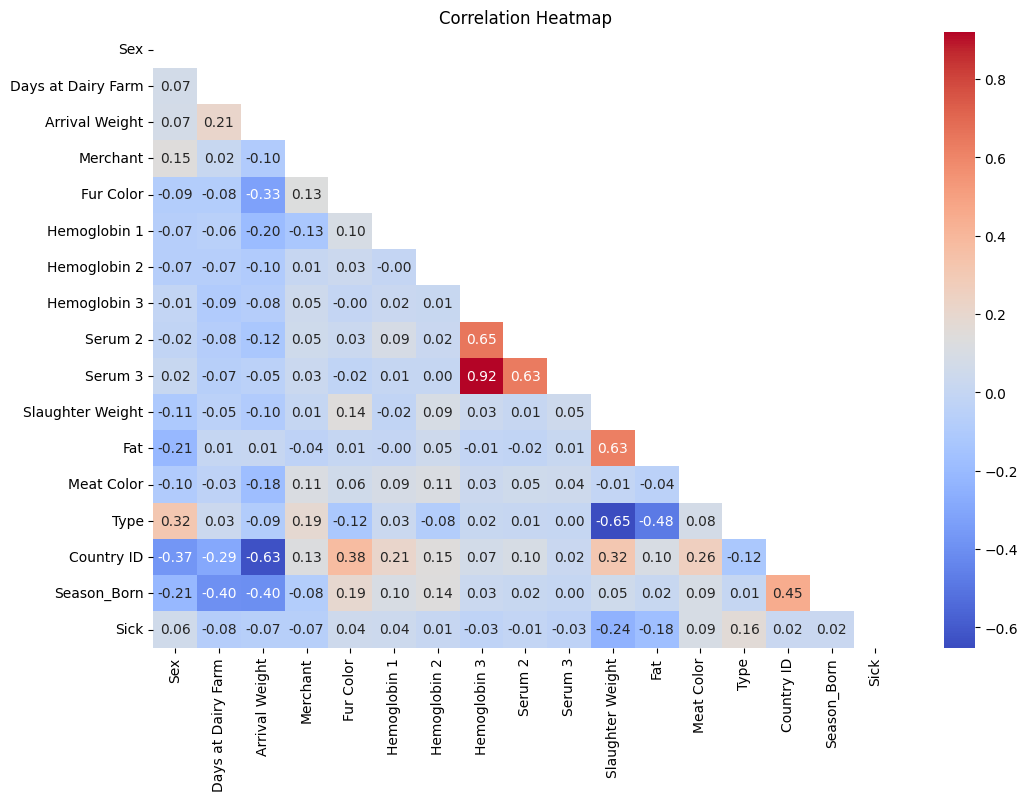

In [814]:
numeric_df = combined_df[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                          'Merchant', 'Fur Color', 'Hemoglobin 1', 
                          'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                          'Serum 3', 'Slaughter Weight', 
                          'Fat', 'Meat Color', 'Type', 'Country ID', 'Season_Born', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

#### Support Vector Machine (Regression) - Data SlaughterhouseS

This code cell performs several key steps to prepare the data, train the model, and evaluate its performance on predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the SVR model**  
   A Support Vector Regression (SVR) model is trained on the scaled training data. SVR is traditionally used for continuous target variables, it is explored here to see if it can help in predicting the `Sick` status, albeit as a regression task. 

5. **Model evaluation**  
   The `R²` score on the test set is calculated to determine the proportion of variance in `Sick` explained by the model. An `R²` score closer to 1 would indicate a strong model, whereas values near or below zero suggest weak predictive power. This initial score provides insight into the model's suitability for this task.

6. **Error metrics**  
   Two error metrics are computed: 
   - **Root Mean Squared Error (RMSE)**: Measures the average prediction error, with larger errors penalized more heavily.
   - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions, providing a straightforward measure of model accuracy.

7. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R²` score provides a robust indicator of model generalizability across different data splits.

There are in total 849 observations, of which 679 are now in the train set, and 170 in the test set.
Model R^2: -0.09
Root Mean Squared Error (RMSE): 0.48
Mean Absolute Error (MAE): 0.36


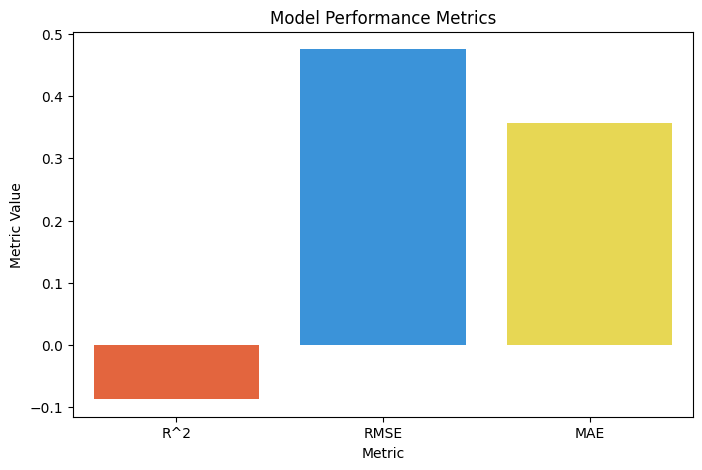

Cross-Validation R^2 scores: [-0.03774525 -0.15131111  0.01619503  0.04141453 -0.09841957]
Mean Cross-Validation R^2: -0.05


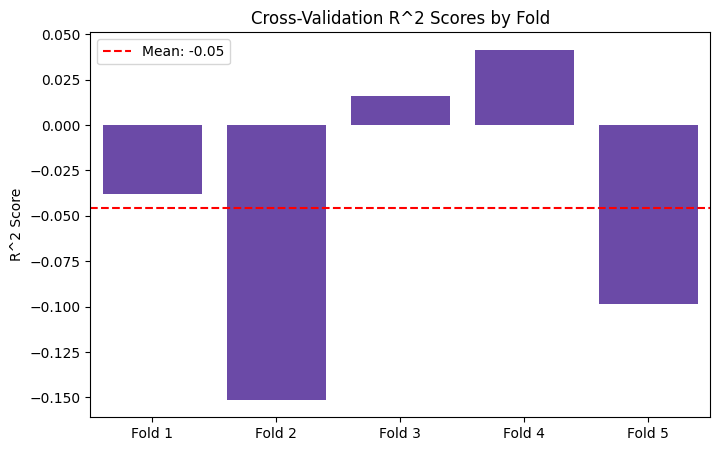

In [815]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results:**

- **R^2 score**:  
  The score of -0.09 indicates that the SVR model explains almost none of the variance in the target variable. This low score suggests the model may not be effectively capturing the patterns needed for reliable predictions.
  - Given the limited range of `Sick` (0 to 1), R² may be less informative on its own and should be interpreted alongside error metrics like RMSE and MAE.
  - A negative value may indicate feature noise, missing predictive features for sickness in the dataset, or an unsuitable model.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.48 and MAE of 0.36 represent substantial prediction errors, especially given the target’s range from 0 to 1. These metrics imply that the model's predictions often deviate significantly from the actual values, reinforcing the limitations in predictive accuracy indicated by the low R^2.
  - In this context, the errors are large relative to the target range, which suggests that the model might not be suitable for this regression task without further tuning or alternative approaches.

- **Cross-validation R^2 scores**:  
  The cross-validation scores, ranging from 0.05 to -0.15 with a mean of -0.05, are consistently negative. This indicates that the model performs poorly across different data folds, which highlights a lack of generalizability and further suggests that SVR may not be the most appropriate model for this prediction task.

In [816]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

     Actual  Predicted
245       0   0.082599
534       0   0.120055
626       0   0.026309
326       0  -0.021640
390       0   0.185272
663       1   0.220139
583       1   0.054669
131       1   0.252096
463       1   0.548495
488       1   0.058560


##### Undersampling

This code cell addresses class imbalance in the dataset by applying **undersampling** to the majority class, `Not sick`. Class imbalance, where one class has significantly more instances than the other, can bias the model, as it may overly focus on the majority class while underperforming on the minority class.

1. **Undersampling the majority class**  
   To balance the classes, we randomly sample a subset of "Healthy" instances to match the count of "Sick" instances. This process creates a new balanced dataset where both classes have equal representation, reducing potential model bias.

2. **Verifying class balance**  
   We print the counts of each class in the new balanced dataset (`balanced_df`) to confirm that both classes are equally represented.

3. **Redefining features and target**  
   Using the balanced dataset, we redefine the features (`X_balanced`) and target (`y_balanced`) to ensure that the model trains on this new, unbiased data.

Counts of each class in balanced_df:
Sick
0    251
1    251
Name: count, dtype: int64

There are in total 502 observations, of which 401 are now in the train set, and 101 in the test set.
Model R^2: -0.24
Root Mean Squared Error (RMSE): 0.56
Mean Absolute Error (MAE): 0.48


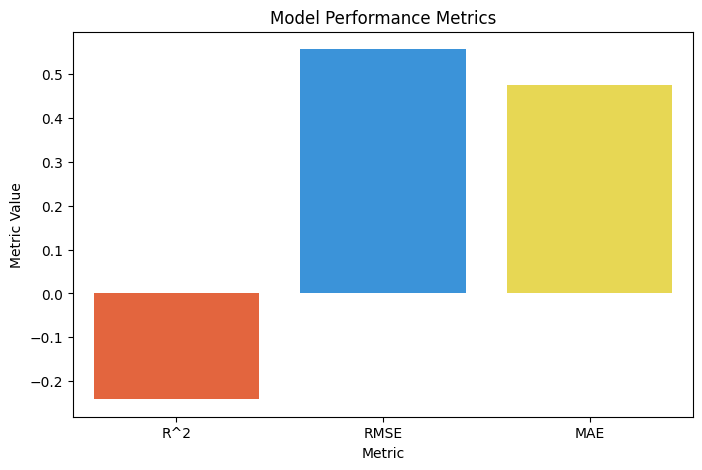

Cross-Validation R^2 scores: [-0.02860789 -0.19181085 -0.07467151  0.1411835   0.08384929]
Mean Cross-Validation R^2: -0.01


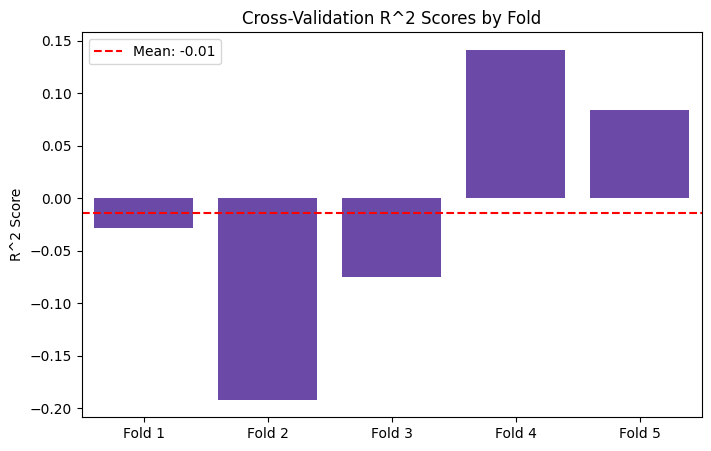

In [817]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

features = balanced_df.drop(columns="Sick").columns
target = "Sick"

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results (undersampling):**

- **Class balance**:  
  The dataset has been balanced, resulting in equal counts for both classes (251 instances of each). This step helps prevent class imbalance from impacting model performance, creating a more balanced distribution for training and testing.

- **R² score**:  
  The model's R² score of -0.24 suggests that it fails to capture variance in the target variable, indicating poor predictive performance. This negative value implies that the model's predictions are worse than a simple mean-based prediction.
  - This low score could suggest noise in the features, a lack of predictive features in the dataset for `Sick`, or that SVR may not be the best choice for this task.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.56 and MAE of 0.48 indicate considerable prediction errors relative to the target’s 0-1 range, with the model often deviating significantly from actual values. 
  - These errors reinforce that the model has limited predictive accuracy even after undersampling.

- **Cross-validation R² scores**:  
  Cross-validation R² scores range from -0.19 to 0.14, with a mean of -0.01. Although one fold achieved a slight positive R², the majority remain near or below zero, suggesting inconsistent performance across different folds. This result highlights poor generalizability, indicating that the model may not reliably capture meaningful patterns in the data.

In summary, even with undersampling, the model's low R² and high error metrics indicate limited predictive capability.

##### Undersampling + Feature selection

This code cell introduces **feature selection** to reduce potential noise from irrelevant features, which could be contributing to the model's poor performance and possibly resulting in a negative R² score.

1. **Calculating correlations**  
   To identify features most relevant to the target variable (`Sick`), we calculate the correlation of each feature with `Sick`. Features with an absolute correlation above 0.1 are selected, as they likely contain useful information for predicting the target. This threshold helps retain only those features with a meaningful relationship to the target.

2. **Dropping low-correlation features**  
   Features with correlations below 0.1 are considered to have minimal relevance to `Sick` and are removed. By excluding these low-correlation features, we aim to reduce noise in the data, improving model performance by focusing on more predictive variables.

3. **Feature set redefinition**  
   After filtering, we redefine `X_balanced_selected` as the dataset containing only the selected features. This reduced feature set is then used in training and testing.

If these changes do not remove the negative R², it may indicate that the current model is not suitable, or that the dataset lacks features capable of effectively predicting sickness.

Counts of each class in balanced_df:
Sick
0    251
1    251
Name: count, dtype: int64

Dropped features due to low correlation with target (Sick):
{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Serum 3', 'Sex', 'Serum 2', 'Arrival Weight', 'Country ID', 'Hemoglobin 3'}

Kept features with significant correlation to target (Sick):
{'Meat Color', 'Slaughter Weight', 'Type', 'Fat', 'Days at Dairy Farm'}

There are in total 502 observations, of which 401 are now in the train set, and 101 in the test set.
Model R^2: -0.10
Root Mean Squared Error (RMSE): 0.52
Mean Absolute Error (MAE): 0.42


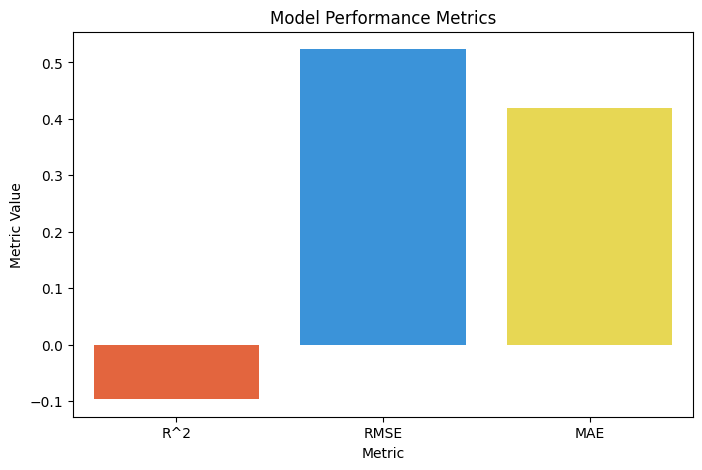

Cross-Validation R^2 scores: [-0.21394936 -0.0913217  -0.03908388  0.08690851 -0.00119263]
Mean Cross-Validation R^2: -0.05


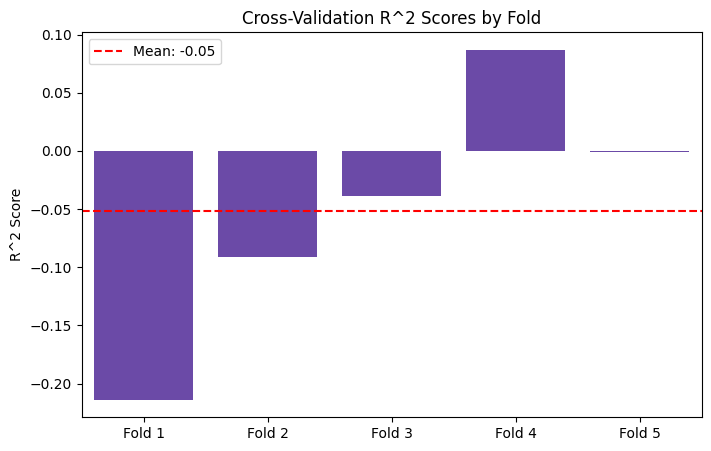

In [818]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

correlations = balanced_df.corr()["Sick"].sort_values(ascending=False)

selected_features = correlations[correlations.abs() > 0.1].index.drop("Sick")

dropped_features = set(balanced_df.columns) - set(selected_features) - {"Sick"}
kept_features = set(selected_features)

print("\nDropped features due to low correlation with target (Sick):")
print(dropped_features)

print("\nKept features with significant correlation to target (Sick):")
print(kept_features)

X_balanced_selected = balanced_df[selected_features]

y_balanced = balanced_df["Sick"]

X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced_selected), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results (undersampling & feature selection):**

- **Feature selection**:  
  Features with low correlation to the target variable `Sick` were removed to focus on those with potentially greater predictive power. The following features were dropped due to low correlation:
  - Dropped: `{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Serum 3', 'Sex', 'Serum 2', 'Arrival Weight', 'Country ID', 'Hemoglobin 3'}`
  - Kept (significantly correlated): `{'Meat Color', 'Slaughter Weight', 'Type', 'Fat', 'Days at Dairy Farm'}`

  These remaining features are hypothesized to be more relevant to predicting sickness based on their correlation with the target variable.

- **R² score**:  
  Despite feature selection, the model’s R² score is -0.10, indicating that the SVR model still explains almost none of the variance in the target variable. This suggests that even with targeted features, the model struggles to capture patterns related to sickness prediction.

- **Error metrics (RMSE and MAE)**:  
  - RMSE is 0.52 and MAE is 0.42, indicating considerable prediction errors relative to the 0-1 range of `Sick`. These metrics suggest that the model's predictions still deviate significantly from actual values, even with the refined feature set.

- **Cross-Validation R² scores**:  
  The cross-validation scores vary from -0.21 to 0.09, with a mean of -0.05. These results show that the model performs inconsistently across folds, reinforcing the lack of reliable predictive power.

The low R² and high error metrics, despite undersampling and feature selection, suggest that features capable of predicting sickness are likely absent from the dataset. This approach may therefore be unsuitable for predicting `Sick`. While it’s possible that an alternative model could yield better results, the current feature set and model combination do not appear sufficient for effective prediction.

#### Logistic Regression (Classification) - Data SlaughterhouseS

This code cell prepares the data, trains a class-balanced **Logistic Regression** model, and evaluate its performance in predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. By defining `Sick` as the target, the goal is to predict whether or not an observation is classified as "sick" based on other factors. 

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the logistic regression model**  
   A Logistic Regression model with `class_weight='balanced'` is used to account for class imbalance. This configuration assigns a higher weight to the minority class, potentially improving the model’s ability to correctly predict the "sick" class.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **ROC AUC Score**: The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) score measures the model’s ability to distinguish between the "sick" and "not sick" classes. An AUC score ranges from 0 to 1:
      - **1** indicates perfect discrimination, where the model accurately distinguishes between all "sick" and "not sick" cases.
      - **0.5** suggests no discriminatory power, equivalent to random guessing.
      - **Values closer to 1** indicate stronger model performance in correctly classifying cases, with higher scores representing a better balance between true positive and false positive rates across all possible thresholds.
   - **Confusion matrix**: Shows true positives, true negatives, false positives, and false negatives, providing insight into prediction errors.
   - **Classification report**: Displays precision, recall, and F1-score for both classes, essential for evaluating performance on imbalanced data.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The average cross-validation ROC AUC score serves as an indicator of the model’s consistency.

There are in total 849 observations, of which 679 are now in the train set, and 170 in the test set.
ROC AUC Score: 0.63


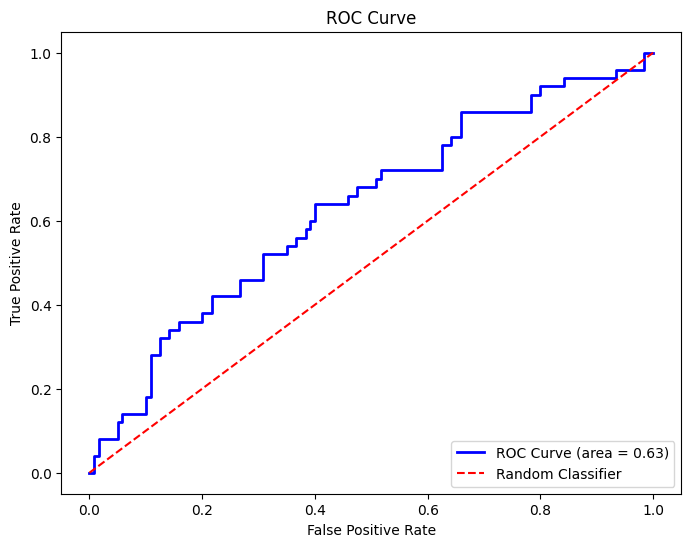

Confusion Matrix:
 [[71 49]
 [18 32]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.59      0.68       120
           1       0.40      0.64      0.49        50

    accuracy                           0.61       170
   macro avg       0.60      0.62      0.58       170
weighted avg       0.68      0.61      0.62       170



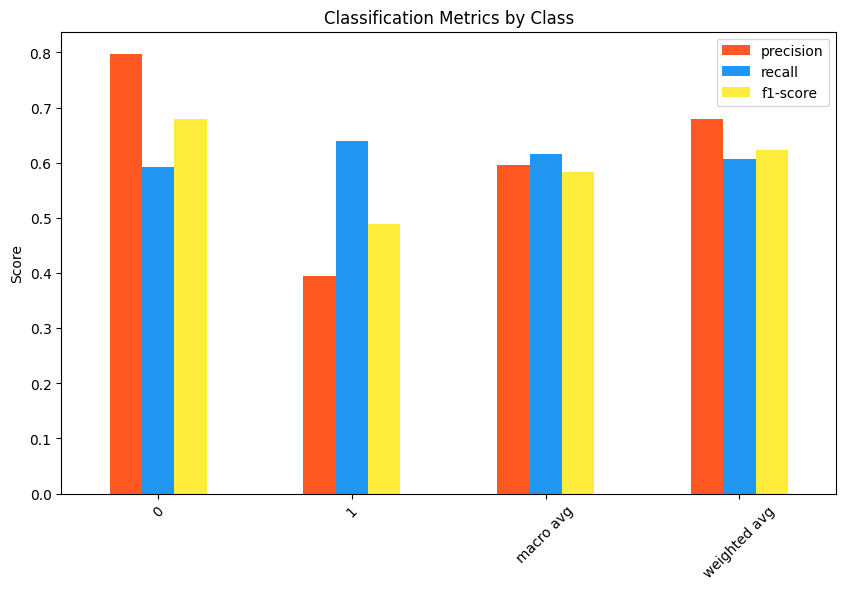

Cross-Validation AUC scores: [0.62682292 0.60364583 0.62161458 0.76816431 0.62842105]
Mean Cross-Validation AUC: 0.65


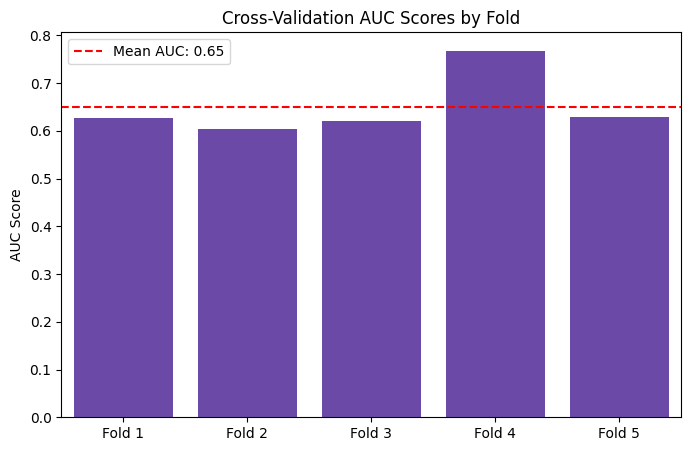

In [819]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

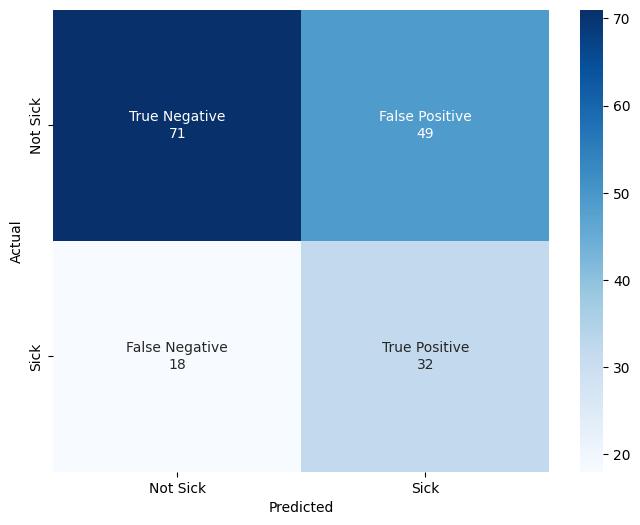

In [820]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results**  

- **ROC AUC score**:  
  The ROC AUC score of 0.63 indicates **low discrimination ability**, suggesting that the model's ability to distinguish between "sick" and "not sick" cases is weak.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 71 true negatives and 49 false positives for "not sick" cases.  
  - 18 false negatives and 32 true positives for "sick" cases.  

- **Classification report**:
  - **Class 0 ("Not Sick")**: Precision of 0.80 and recall of 0.59, indicating that the model has good precision but struggles with recall, misclassifying several "not sick" cases as "sick."
  - **Class 1 ("Sick")**: Precision of 0.40 and recall of 0.64, showing that the model struggles with predicting "sick" cases, as reflected in both the low precision and recall.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.60 to 0.77, with a mean AUC of 0.65. This variability suggests that while the model's performance is somewhat consistent, there is still significant room for improvement in terms of stability and generalization.

In [821]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

     Actual  Predicted
245       0          1
534       0          0
626       0          1
326       0          0
390       0          0
663       1          1
583       1          0
131       1          0
463       1          1
488       1          0


##### Undersampling

This code cell addresses class imbalance in the dataset by applying **undersampling** to the majority class, `Not sick`. Class imbalance, where one class has significantly more instances than the other, can bias the model, as it may overly focus on the majority class while underperforming on the minority class.

1. **Undersampling the majority class**  
   To balance the classes, we randomly sample a subset of "Healthy" instances to match the count of "Sick" instances. This process creates a new balanced dataset where both classes have equal representation, reducing potential model bias.

2. **Verifying class balance**  
   We print the counts of each class in the new balanced dataset (`balanced_df`) to confirm that both classes are equally represented.

3. **Redefining features and target**  
   Using the balanced dataset, we redefine the features (`X_balanced`) and target (`y_balanced`) to ensure that the model trains on this new, unbiased data.

Counts of each class in balanced_df:
Sick
0    251
1    251
Name: count, dtype: int64

There are in total 502 observations, of which 401 are now in the train set, and 101 in the test set.
ROC AUC Score: 0.67


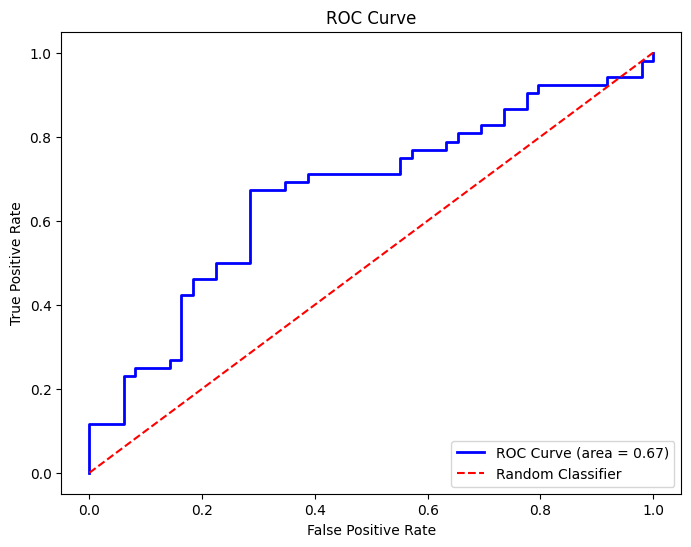

Confusion Matrix:
 [[26 23]
 [15 37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.53      0.58        49
           1       0.62      0.71      0.66        52

    accuracy                           0.62       101
   macro avg       0.63      0.62      0.62       101
weighted avg       0.63      0.62      0.62       101



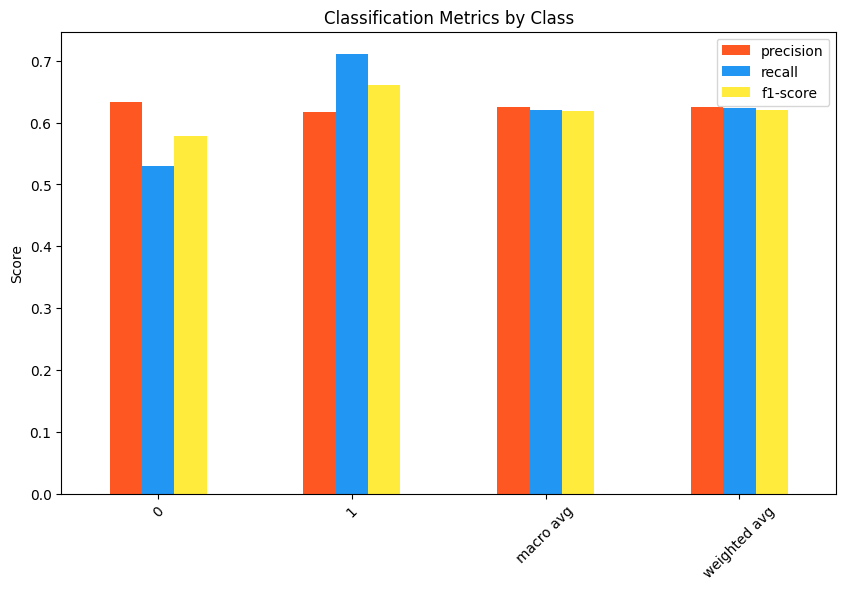

Cross-Validation AUC scores: [0.61890244 0.535625   0.68625    0.75875    0.72732958]
Mean Cross-Validation AUC: 0.67


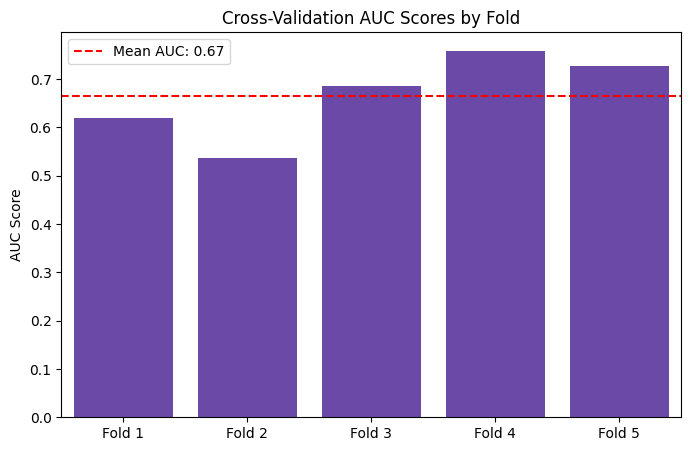

In [822]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

features = balanced_df.drop(columns="Sick").columns
target = "Sick"

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

cross_val_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

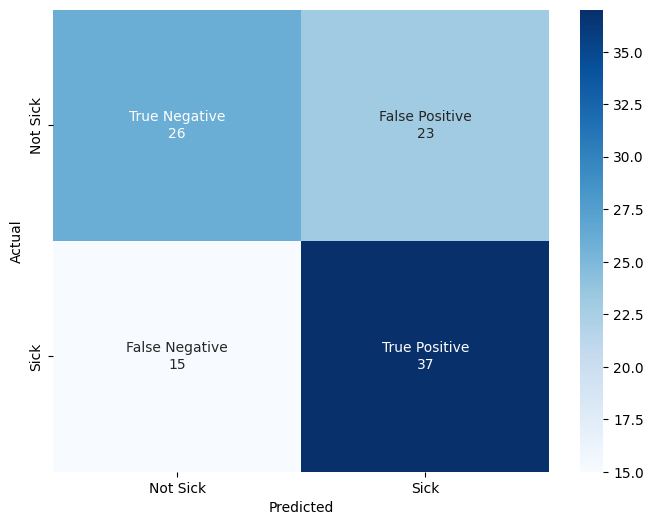

In [823]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results (undersampling)**  

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 251 instances of "sick" and "not sick" cases each. This helps mitigate the effects of class imbalance.

- **ROC AUC score**:  
  The ROC AUC score of 0.67 indicates **low discrimination ability**, slightly improving over the results without undersampling, but still showing that the model struggles to effectively distinguish between "sick" and "not sick" cases.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 26 true negatives and 23 false positives for "not sick" cases.  
  - 15 false negatives and 37 true positives for "sick" cases.  

- **Classification report**:  
  - **Class 0 ("Not Sick")**: Precision of 0.63 and recall of 0.53, indicating that the model still struggles with recall for the "not sick" class, misclassifying several "not sick" cases as "sick."  
  - **Class 1 ("Sick")**: Precision of 0.62 and recall of 0.71, suggesting that the model is somewhat better at identifying "sick" cases, but the improvement in recall is moderate, and precision remains low.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.54 to 0.76, with a mean AUC of 0.67. This shows a slight improvement over the model without undersampling, but the performance is still inconsistent and could benefit from further improvements in stability and generalization.

Compared to the results without undersampling (ROC AUC score of 0.63), undersampling slightly improved the model's performance (ROC AUC of 0.67). However, the model still struggles significantly with both "sick" and "not sick" cases, showing only modest improvement. The recall for "sick" cases (0.71) is better than the baseline (0.64), but precision remains low, and the model continues to misclassify a substantial number of cases. Overall, while undersampling helped balance the dataset, the model's performance remains suboptimal.

##### Undersampling + Feature selection

This code cell introduces **feature selection** to reduce potential noise from irrelevant features, which could be contributing to the model's poor performance.

1. **Calculating correlations**  
   To identify features most relevant to the target variable (`Sick`), we calculate the correlation of each feature with `Sick`. Features with an absolute correlation above 0.1 are selected, as they likely contain useful information for predicting the target. This threshold helps retain only those features with a meaningful relationship to the target.

2. **Dropping low-correlation features**  
   Features with correlations below 0.1 are considered to have minimal relevance to `Sick` and are removed. By excluding these low-correlation features, we aim to reduce noise in the data, improving model performance by focusing on more predictive variables.

3. **Feature set redefinition**  
   After filtering, we redefine `X_balanced_selected` as the dataset containing only the selected features. This reduced feature set is then used in training and testing.

If these changes do not improve the performance, it may indicate that the current model is not suitable, or that the dataset lacks features capable of effectively predicting sickness.

Counts of each class in balanced_df:
Sick
0    251
1    251
Name: count, dtype: int64

Dropped features due to low correlation with target (Sick):
{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Serum 3', 'Sex', 'Serum 2', 'Arrival Weight', 'Country ID', 'Hemoglobin 3'}

Kept features with significant correlation to target (Sick):
{'Meat Color', 'Slaughter Weight', 'Type', 'Fat', 'Days at Dairy Farm'}

There are in total 502 observations, of which 401 are now in the train set, and 101 in the test set.
ROC AUC Score: 0.67


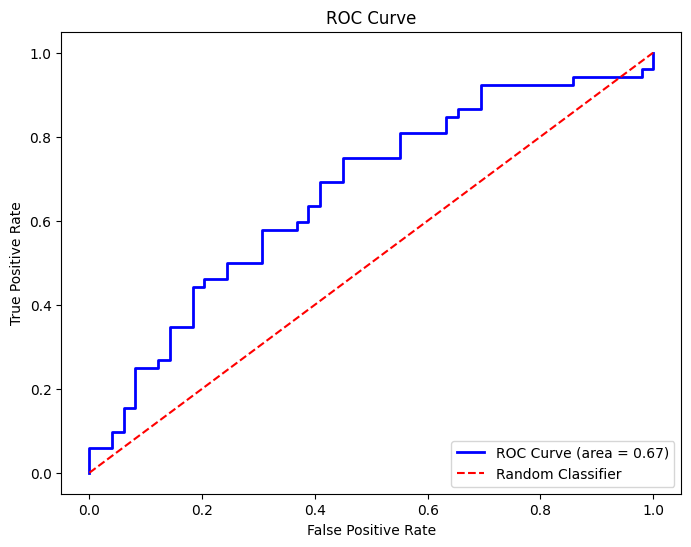

Confusion Matrix:
 [[29 20]
 [18 34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.59      0.60        49
           1       0.63      0.65      0.64        52

    accuracy                           0.62       101
   macro avg       0.62      0.62      0.62       101
weighted avg       0.62      0.62      0.62       101



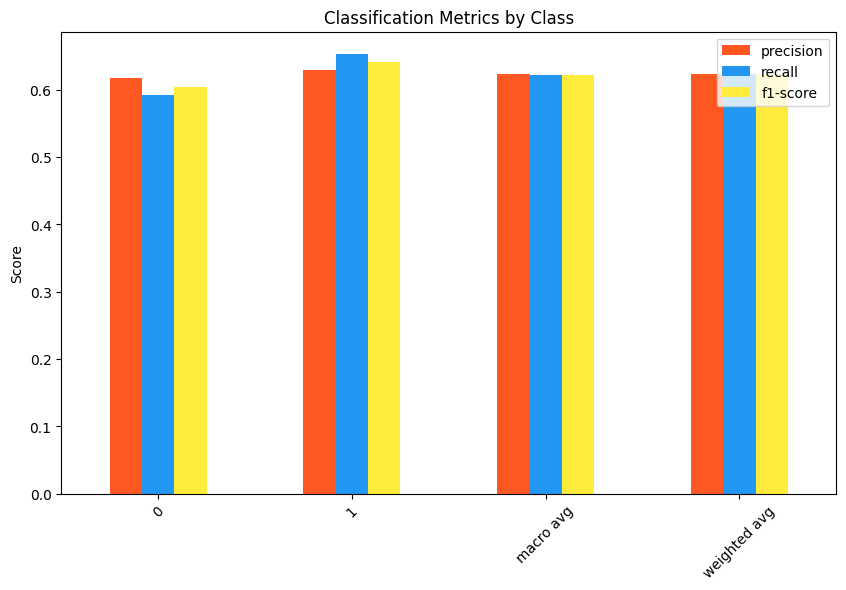

Cross-Validation AUC scores: [0.61707317 0.578125   0.693125   0.754375   0.72983114]
Mean Cross-Validation AUC: 0.67


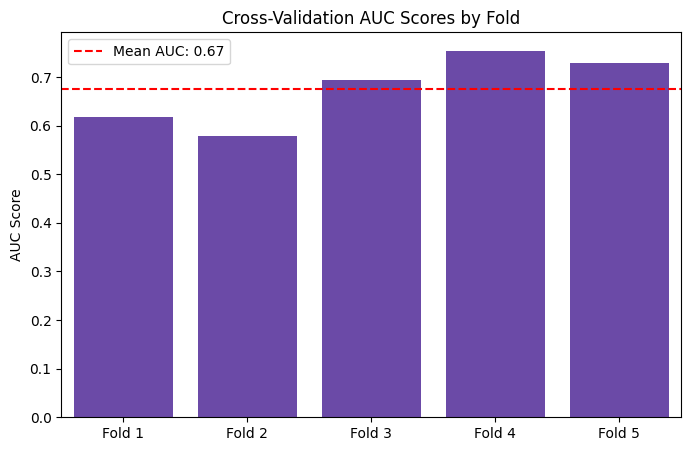

In [824]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

correlations = balanced_df.corr()["Sick"].sort_values(ascending=False)

selected_features = correlations[correlations.abs() > 0.1].index.drop("Sick")

dropped_features = set(balanced_df.columns) - set(selected_features) - {"Sick"}
kept_features = set(selected_features)

print("\nDropped features due to low correlation with target (Sick):")
print(dropped_features)

print("\nKept features with significant correlation to target (Sick):")
print(kept_features)

X_balanced_selected = balanced_df[selected_features]

y_balanced = balanced_df["Sick"]

X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced_selected), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

cross_val_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

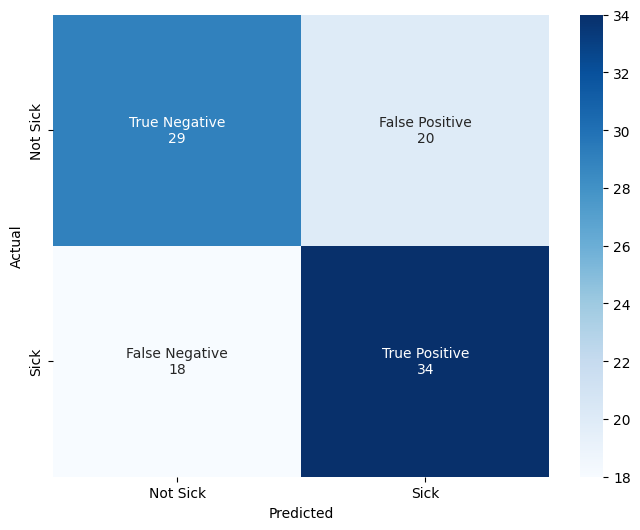

In [825]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results (undersampling & feature selection)**  

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 251 instances of "sick" and "not sick" cases each.

- **Feature selection**:  
  Features with low correlation to the target ("Sick") were dropped:  
  `{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Serum 3', 'Sex', 'Serum 2', 'Arrival Weight', 'Country ID', 'Hemoglobin 3'}`  
  The following features were retained due to their 'significant' correlation with the target:  
  `{'Meat Color', 'Slaughter Weight', 'Type', 'Fat', 'Days at Dairy Farm'}`

- **ROC AUC score**:  
  The ROC AUC score of 0.67 indicates **low discrimination ability**, showing no improvement over the model with only undersampling (ROC AUC of 0.67). The model still struggles to effectively distinguish between "sick" and "not sick" cases.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 29 true negatives and 20 false positives for "not sick" cases.  
  - 18 false negatives and 34 true positives for "sick" cases.  

- **Classification report**:  
  - **Class 0 ("Not Sick")**: Precision of 0.62 and recall of 0.59 both remain low.
  - **Class 1 ("Sick")**: Precision of 0.63 and recall of 0.65 both remain low.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.58 to 0.75, with a mean AUC of 0.67. This shows minimal improvement in stability and generalization over the model with undersampling.

Compared to the undersampling-only model (ROC AUC of 0.67), the feature selection did not result in any significant improvement. The ROC AUC remains at 0.67, showing that the model continues to struggle with distinguishing between the "sick" and "not sick" classes. The recall for "sick" cases (0.65) is still suboptimal, and while precision for "sick" cases (0.63) has slightly improved, it remains insufficient. The confusion matrix and classification report show that the model still misclassifies a substantial number of cases, particularly with false positives for "not sick" and false negatives for "sick" cases. Despite feature selection and undersampling, the model's performance remains largely unchanged and still underperforms in reliably predicting both classes.

#### Linear Regression (Regression) - Data SlaughterhouseS

This code cell prepares the data, trains a **Linear Regression** model, and evaluates its performance in predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the linear regression model**  
   A Linear Regression model is fitted on the scaled training data. The goal is to learn the relationship between the features and the target variable.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **R² Score**: Indicates how well the model explains the variance in the target variable. Values closer to 1 suggest better performance.
   - **Root Mean Squared Error (RMSE)**: Measures the average magnitude of the errors between predicted and actual values, providing insight into model accuracy.
   - **Mean Absolute Error (MAE)**: Represents the average absolute difference between predicted and actual values, giving a straightforward measure of prediction error.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.


There are in total 849 observations, of which 679 are now in the train set, and 170 in the test set.
Model R^2: 0.03
Root Mean Squared Error (RMSE): 0.45
Mean Absolute Error (MAE): 0.39


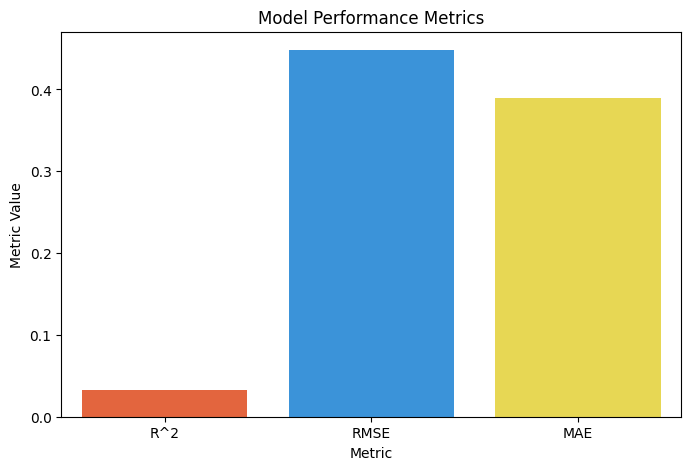

Cross-Validation R^2 scores: [ 0.00062582 -0.00307469 -0.00874788  0.16384589  0.02274224]
Mean Cross-Validation R^2: 0.04


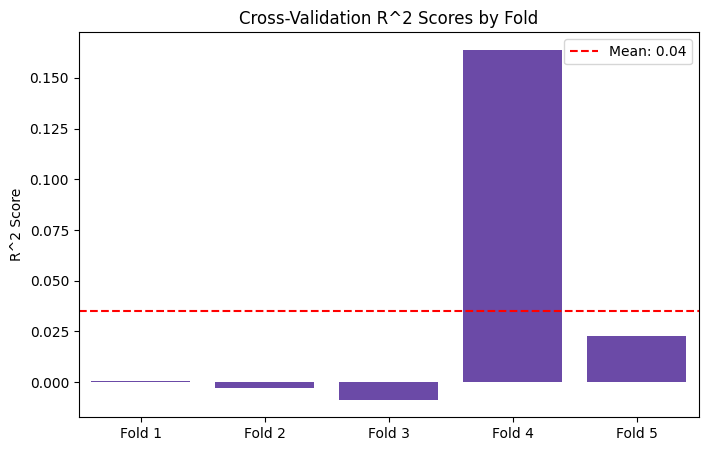

In [826]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results:**

- **R² score**:  
  The R² score of 0.03 indicates that the linear regression model explains only 8% of the variance in the target variable `Sick`. This low score suggests that the model may not be effectively capturing the underlying patterns in the data.
  - Given the limited range of `Sick` (0 to 1), R² may be less informative on its own and should be interpreted alongside error metrics like RMSE and MAE.
  - A negative value may indicate feature noise, missing predictive features for sickness in the dataset, or an unsuitable model.

- **Error metrics (RMSE and MAE)**:  
  - The **Root Mean Squared Error (RMSE)** of 0.45 and **Mean Absolute Error (MAE)** of 0.39 represent substantial prediction errors, especially considering the target's range from 0 to 1. These values indicate that the model's predictions frequently deviate significantly from the actual values, reinforcing the limitations suggested by the low R² score.
  - Given the target range, these errors are relatively large, suggesting that this linear regression model may not be suitable for the prediction task without further tuning or alternative modeling approaches.

- **Cross-validation R² scores**:  
  The cross-validation R² scores range from -0.01 to 0.16 with a mean of 0.04, which highlights that the model performs inconsistently across different data folds. The low and slightly negative scores in some folds imply limited generalizability, suggesting that the linear regression model may not be the most appropriate model for this prediction task.

In [827]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

     Actual  Predicted
245       0   0.326193
534       0   0.169964
626       0   0.328021
326       0  -0.015012
390       0   0.210655
663       1   0.357061
583       1   0.151767
131       1   0.261100
463       1   0.512085
488       1   0.246335


##### Undersampling

This code cell addresses class imbalance in the dataset by applying **undersampling** to the majority class, `Not sick`. Class imbalance, where one class has significantly more instances than the other, can bias the model, as it may overly focus on the majority class while underperforming on the minority class.

1. **Undersampling the majority class**  
   To balance the classes, we randomly sample a subset of "Healthy" instances to match the count of "Sick" instances. This process creates a new balanced dataset where both classes have equal representation, reducing potential model bias.

2. **Verifying class balance**  
   We print the counts of each class in the new balanced dataset (`balanced_df`) to confirm that both classes are equally represented.

3. **Redefining features and target**  
   Using the balanced dataset, we redefine the features (`X_balanced`) and target (`y_balanced`) to ensure that the model trains on this new, unbiased data.

Counts of each class in balanced_df:
Sick
0    251
1    251
Name: count, dtype: int64

There are in total 502 observations, of which 401 are now in the train set, and 101 in the test set.
Model R^2: 0.05
Root Mean Squared Error (RMSE): 0.49
Mean Absolute Error (MAE): 0.45


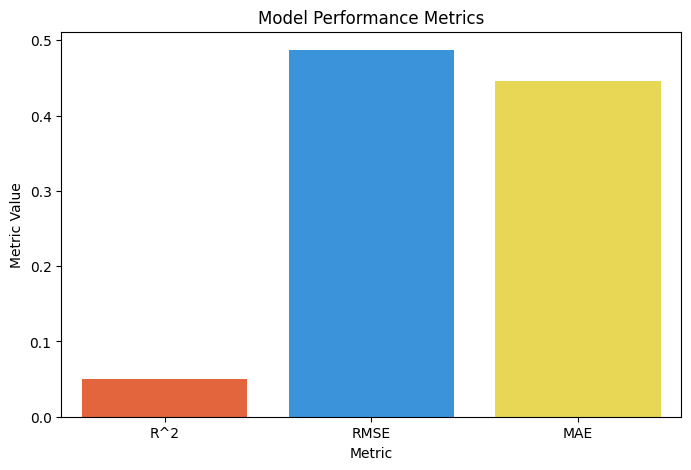

Cross-Validation R^2 scores: [ 0.03200637 -0.08810186 -0.03853837  0.17645614  0.08495115]
Mean Cross-Validation R^2: 0.03


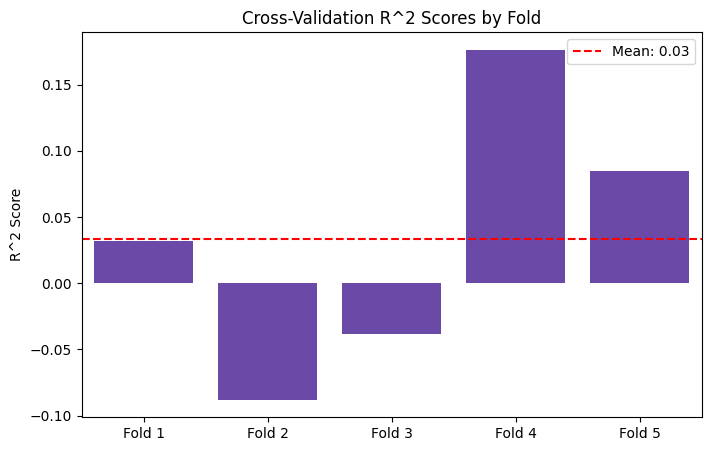

In [828]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

features = balanced_df.drop(columns="Sick").columns
target = "Sick"

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results (undersampling):**

- **Class balance**:  
  The dataset has been balanced, resulting in equal counts for both classes (251 instances of each). This step helps prevent class imbalance from impacting model performance, creating a more balanced distribution for training and testing.

- **R² score**:  
  The model's R² score of 0.05 suggests a very limited ability to explain variance in the target variable, indicating poor predictive performance. The low R² indicates that the model is not effectively capturing the underlying patterns in the data.
  - This score, although slightly positive, still reflects minimal improvement over a base model and suggests that linear regression may not be the best approach for this task.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.49 and MAE of 0.45 indicate considerable prediction errors, especially when the target variable ranges between 0 and 1. These metrics suggest that the model's predictions frequently deviate from the actual values, further supporting the idea that the model is not suitable for accurate predictions in this context.

- **Cross-validation R² scores**:  
  Cross-validation R² scores range from -0.09 to 0.18, with a mean of 0.03. The variability in the scores suggests inconsistent performance across the different data folds. The negative values in some folds highlight the model's failure to generalize and capture meaningful patterns, further suggesting that linear regression is not the most effective model for this task.

In summary, despite undersampling, the model's low R² score and high error metrics demonstrate limited predictive capability, indicating that further tuning or a different modeling approach is required for better performance.

##### Undersampling + Feature selection

This code cell introduces **feature selection** to reduce potential noise from irrelevant features, which could be contributing to the model's poor performance and possibly resulting in a negative R^2 score.

1. **Calculating correlations**  
   To identify features most relevant to the target variable (`Sick`), we calculate the correlation of each feature with `Sick`. Features with an absolute correlation above 0.1 are selected, as they likely contain useful information for predicting the target. This threshold helps retain only those features with a meaningful relationship to the target.

2. **Dropping low-correlation features**  
   Features with correlations below 0.1 are considered to have minimal relevance to `Sick` and are removed. By excluding these low-correlation features, we aim to reduce noise in the data, improving model performance by focusing on more predictive variables.

3. **Feature set redefinition**  
   After filtering, we redefine `X_balanced_selected` as the dataset containing only the selected features. This reduced feature set is then used in training and testing.

If these changes do not remove the negative R^2, it may indicate that the current model is not suitable, or that the dataset lacks features capable of effectively predicting sickness.

Counts of each class in balanced_df:
Sick
0    251
1    251
Name: count, dtype: int64

Dropped features due to low correlation with target (Sick):
{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Serum 3', 'Sex', 'Serum 2', 'Arrival Weight', 'Country ID', 'Hemoglobin 3'}

Kept features with significant correlation to target (Sick):
{'Meat Color', 'Slaughter Weight', 'Type', 'Fat', 'Days at Dairy Farm'}

There are in total 502 observations, of which 401 are now in the train set, and 101 in the test set.
Model R^2: 0.04
Root Mean Squared Error (RMSE): 0.49
Mean Absolute Error (MAE): 0.45


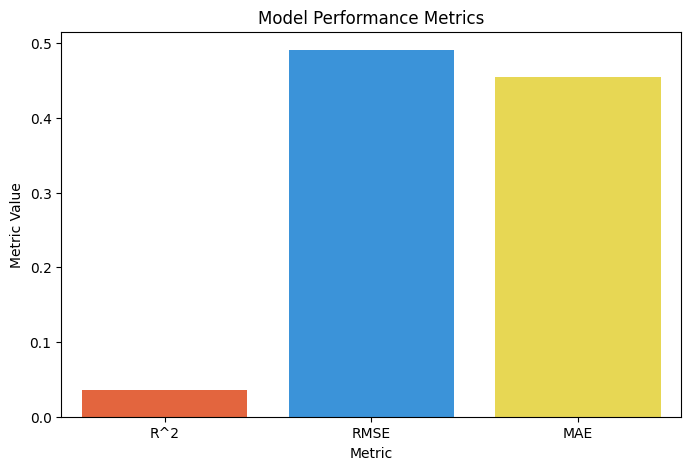

Cross-Validation R^2 scores: [ 0.02653963 -0.00843916  0.04591693  0.20239621  0.10840412]
Mean Cross-Validation R^2: 0.07


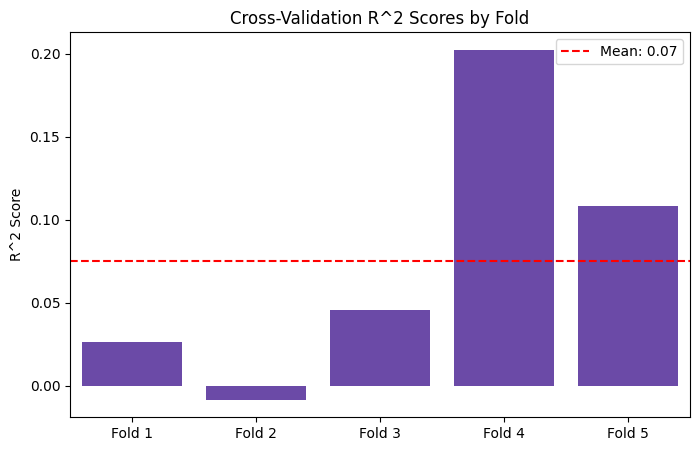

In [829]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

correlations = balanced_df.corr()["Sick"].sort_values(ascending=False)

selected_features = correlations[correlations.abs() > 0.1].index.drop("Sick")

dropped_features = set(balanced_df.columns) - set(selected_features) - {"Sick"}
kept_features = set(selected_features)

print("\nDropped features due to low correlation with target (Sick):")
print(dropped_features)

print("\nKept features with significant correlation to target (Sick):")
print(kept_features)

X_balanced_selected = balanced_df[selected_features]

y_balanced = balanced_df["Sick"]

X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced_selected), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results (undersampling & feature selection):**

- **Feature selection**:  
  Features with low correlation to the target variable `Sick` were removed to focus on those with potentially greater predictive power. The following features were dropped due to low correlation:
  - Dropped: `{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Serum 3', 'Sex', 'Serum 2', 'Arrival Weight', 'Country ID', 'Hemoglobin 3'}`
  - Kept (significantly correlated): `{'Meat Color', 'Slaughter Weight', 'Type', 'Fat', 'Days at Dairy Farm'}`

  These remaining features are hypothesized to be more relevant to predicting sickness based on their correlation with the target variable.

- **R² score**:  
  The model’s R² score of 0.04 indicates minimal explanatory power, suggesting that even after feature selection, the model still fails to capture significant variance in the target variable. The R² score remains low, reflecting the challenges in predicting sickness with the available features.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.49 and MAE of 0.45 indicate considerable prediction errors relative to the 0-1 range of `Sick`. These values suggest that the model continues to deviate significantly from actual values, even with a more focused set of features.

- **Cross-validation R² scores**:  
  The cross-validation R² scores range from -0.01 to 0.20, with a mean of 0.07. These results demonstrate some slight variation in performance across folds, but the overall model performance remains weak, with all folds showing poor generalizability.

In summary, despite feature selection and undersampling, the model’s low R² score and high error metrics suggest that the selected features still do not adequately capture the patterns necessary for predicting `Sick`. While the feature selection process improved the focus of the model, the overall performance remains suboptimal, indicating that a different modeling approach may be required to improve prediction accuracy.

#### K-Nearest Neighbors (Classification) - Data SlaughterhouseS

This code cell performs several key steps to prepare the data, train a K-Nearest Neighbors (KNN) model, and evaluate its performance on predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance. This step is especially useful for distance-based models like KNN.

4. **Training the K-Nearest Neighbors model**  
   A K-Nearest Neighbors (KNN) classifier with `n_neighbors=5` is trained on the scaled training data. KNN is a non-parametric model that classifies instances based on the majority class among the nearest neighbors in the feature space.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **ROC AUC Score**: The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) score measures the model’s ability to distinguish between the "sick" and "not sick" classes. An AUC score ranges from 0 to 1:
      - **1** indicates perfect discrimination, where the model accurately distinguishes between all "sick" and "not sick" cases.
      - **0.5** suggests no discriminatory power, equivalent to random guessing.
      - **Values closer to 1** indicate stronger model performance in correctly classifying cases, with higher scores representing a better balance between true positive and false positive rates across all possible thresholds.
   - **Confusion matrix**: Shows true positives, true negatives, false positives, and false negatives, providing insight into prediction errors.
   - **Classification report**: Displays precision, recall, and F1-score for both classes, essential for evaluating performance on imbalanced data.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The average cross-validation ROC AUC score serves as an indicator of the model’s consistency.

There are in total 849 observations, of which 679 are now in the train set, and 170 in the test set.
ROC AUC Score: 0.54


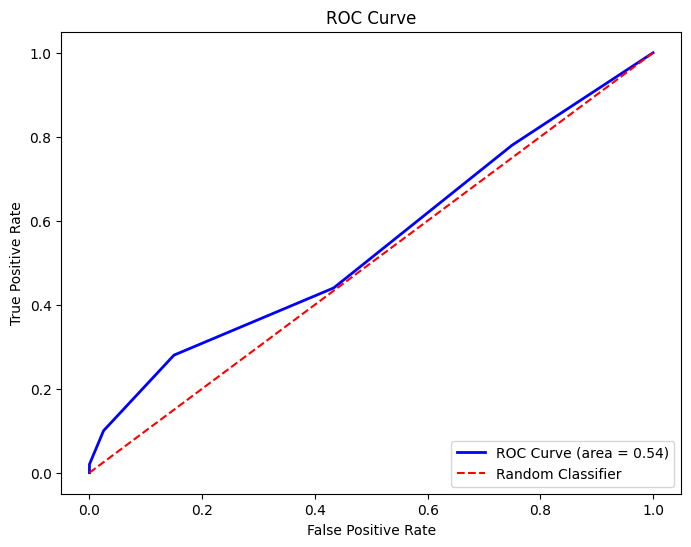

Confusion Matrix:
 [[102  18]
 [ 36  14]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.85      0.79       120
           1       0.44      0.28      0.34        50

    accuracy                           0.68       170
   macro avg       0.59      0.56      0.57       170
weighted avg       0.65      0.68      0.66       170



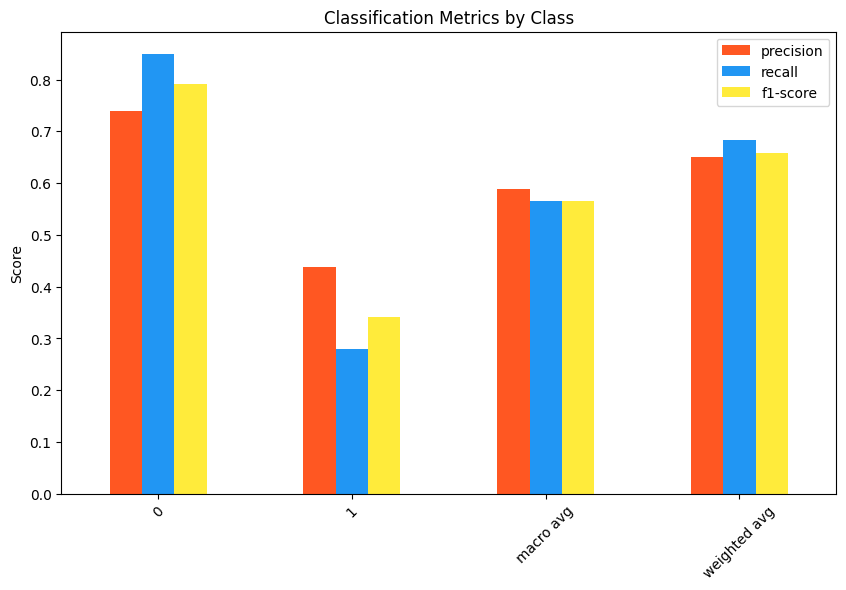

Cross-Validation AUC scores: [0.59309896 0.54166667 0.64270833 0.60706033 0.67144737]
Mean Cross-Validation AUC: 0.61


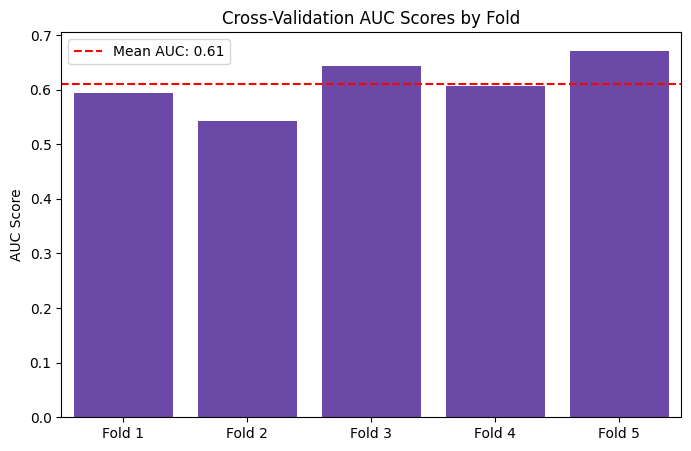

In [830]:
features = numeric_df.drop(columns="Sick").columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(knn, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

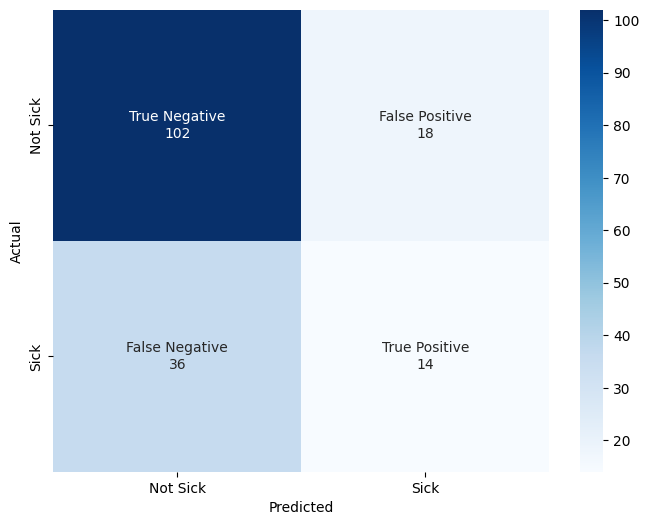

In [831]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results**

- **ROC AUC score**:  
  The ROC AUC score of 0.54 indicates **low discrimination ability**, suggesting that the model's ability to distinguish between "sick" and "not sick" cases is weak.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 102 true negatives and 18 false positives for "not sick" cases.  
  - 36 false negatives and 14 true positives for "sick" cases.  

- **Classification report**:
  - **Class 0 ("Not Sick")**: Precision of 0.74 and recall of 0.85, suggesting that the model is quite accurate in identifying "not sick" cases (while the dataset is heavily `imbalanced`).
  - **Class 1 ("Sick")**: Precision of 0.44 and recall of 0.28, showing that the model struggles significantly to predict "sick" cases, as reflected in both the low precision and recall.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.54 to 0.67, with a mean AUC of 0.61. This variability suggests that while the model's performance is somewhat consistent, there is significant room for improvement in stability and generalization.

In summary, the KNN model struggles to effectively distinguish between "sick" and "not sick" cases, with inconsistent performance overall. The model shows good results for "not sick" cases but struggles heavily with predicting "sick" cases, as indicated by its low precision and recall for that class. The cross-validation results show some variability, suggesting that the model could benefit from further tuning or a different approach to improve its performance.

##### Undersampling

This code cell addresses class imbalance in the dataset by applying **undersampling** to the majority class, `Not sick`. Class imbalance, where one class has significantly more instances than the other, can bias the model, as it may overly focus on the majority class while underperforming on the minority class.

1. **Undersampling the majority class**  
   To balance the classes, we randomly sample a subset of "Healthy" instances to match the count of "Sick" instances. This process creates a new balanced dataset where both classes have equal representation, reducing potential model bias.

2. **Verifying class balance**  
   We print the counts of each class in the new balanced dataset (`balanced_df`) to confirm that both classes are equally represented.

3. **Redefining features and target**  
   Using the balanced dataset, we redefine the features (`X_balanced`) and target (`y_balanced`) to ensure that the model trains on this new, unbiased data.

Counts of each class in balanced_df:
Sick
0    251
1    251
Name: count, dtype: int64

There are in total 502 observations, of which 401 are now in the train set, and 101 in the test set.
ROC AUC Score: 0.60


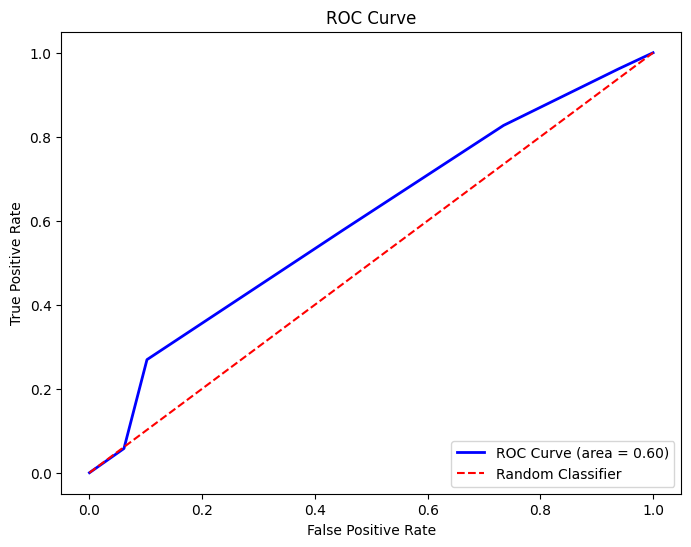

Confusion Matrix:
 [[27 22]
 [22 30]]
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.55      0.55        49
           1       0.58      0.58      0.58        52

    accuracy                           0.56       101
   macro avg       0.56      0.56      0.56       101
weighted avg       0.56      0.56      0.56       101



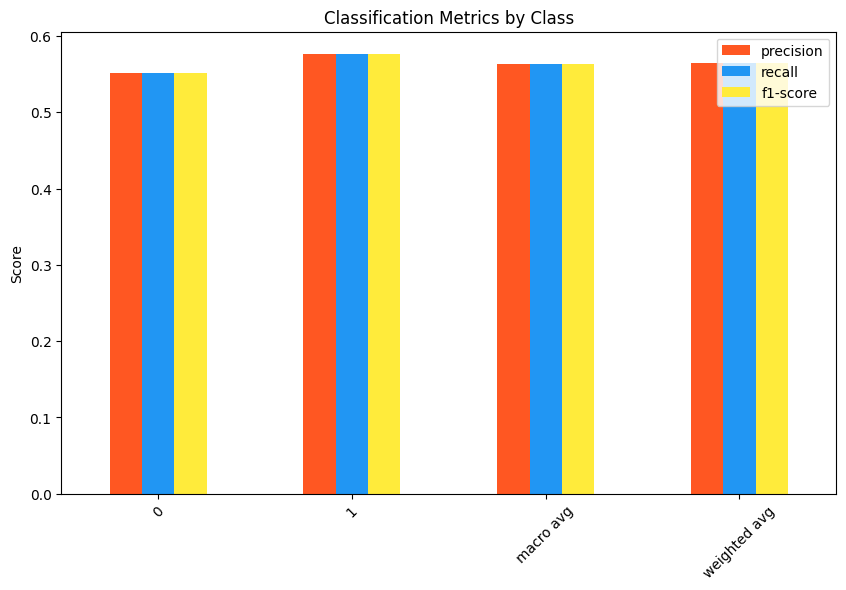

Cross-Validation AUC scores: [0.61432927 0.5821875  0.6296875  0.6175     0.62101313]
Mean Cross-Validation AUC: 0.61


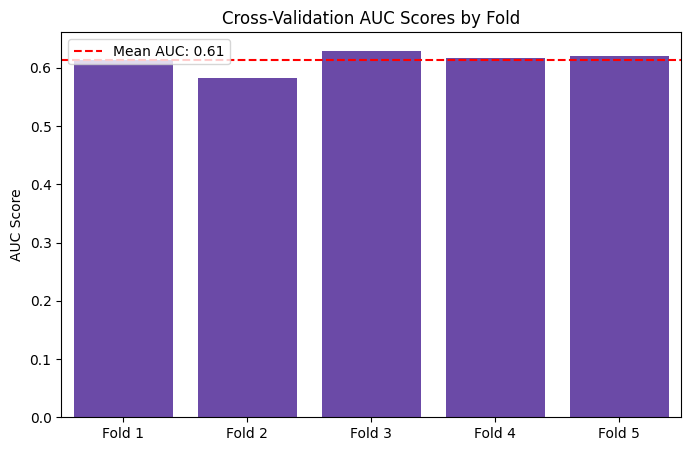

In [832]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

features = balanced_df.drop(columns="Sick").columns
target = "Sick"

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

cross_val_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

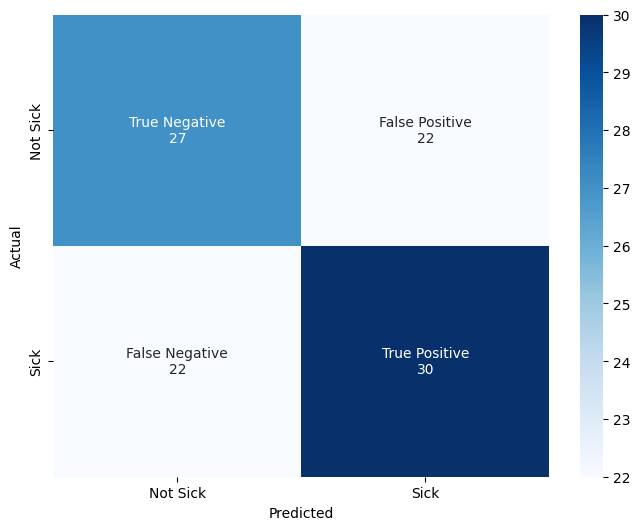

In [833]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results (undersampling)**

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 251 instances of "sick" and "not sick" cases each. This helps mitigate the effects of class imbalance.

- **ROC AUC score**:  
  The ROC AUC score of 0.60 indicates **low discrimination ability**, suggesting that the model still struggles to effectively distinguish between "sick" and "not sick" cases, despite the balancing of the dataset.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 27 true negatives and 22 false positives for "not sick" cases.  
  - 22 false negatives and 30 true positives for "sick" cases.  

- **Classification report**:  
  - **Class 0 ("Not Sick")**: Precision of 0.55 and recall of 0.55, indicating that the model has relatively balanced but low performance in identifying "not sick" cases, with equal likelihood of misclassifying these cases as "sick."  
  - **Class 1 ("Sick")**: Precision of 0.58 and recall of 0.58, showing that the model’s performance for predicting "sick" cases is low, with no significant advantage in identifying them correctly.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.53 to 0.63, with a mean AUC of 0.57. This indicates some variability in performance across folds, suggesting that the model’s ability to generalize is still limited and performance remains inconsistent.

Compared to the results without undersampling (ROC AUC score of 0.54), undersampling improved the model's ROC AUC score to 0.60. However, the model continues to struggle with both "sick" and "not sick" cases, with only modest improvements in performance. While the recall for both classes is somewhat better, precision remains low, and the model still misclassifies a substantial number of cases. Overall, while undersampling has balanced the dataset, the model's performance remains suboptimal.

##### Undersampling + Feature selection

This code cell introduces **feature selection** to reduce potential noise from irrelevant features, which could be contributing to the model's poor performance.

1. **Calculating correlations**  
   To identify features most relevant to the target variable (`Sick`), we calculate the correlation of each feature with `Sick`. Features with an absolute correlation above 0.1 are selected, as they likely contain useful information for predicting the target. This threshold helps retain only those features with a meaningful relationship to the target.

2. **Dropping low-correlation features**  
   Features with correlations below 0.1 are considered to have minimal relevance to `Sick` and are removed. By excluding these low-correlation features, we aim to reduce noise in the data, improving model performance by focusing on more predictive variables.

3. **Feature set redefinition**  
   After filtering, we redefine `X_balanced_selected` as the dataset containing only the selected features. This reduced feature set is then used in training and testing.

If these changes do not improve the performance, it may indicate that the current model is not suitable, or that the dataset lacks features capable of effectively predicting sickness.

Counts of each class in balanced_df:
Sick
0    251
1    251
Name: count, dtype: int64

Dropped features due to low correlation with target (Sick):
{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Serum 3', 'Sex', 'Serum 2', 'Arrival Weight', 'Country ID', 'Hemoglobin 3'}

Kept features with significant correlation to target (Sick):
{'Meat Color', 'Slaughter Weight', 'Type', 'Fat', 'Days at Dairy Farm'}

There are in total 502 observations, of which 401 are now in the train set, and 101 in the test set.
ROC AUC Score: 0.68


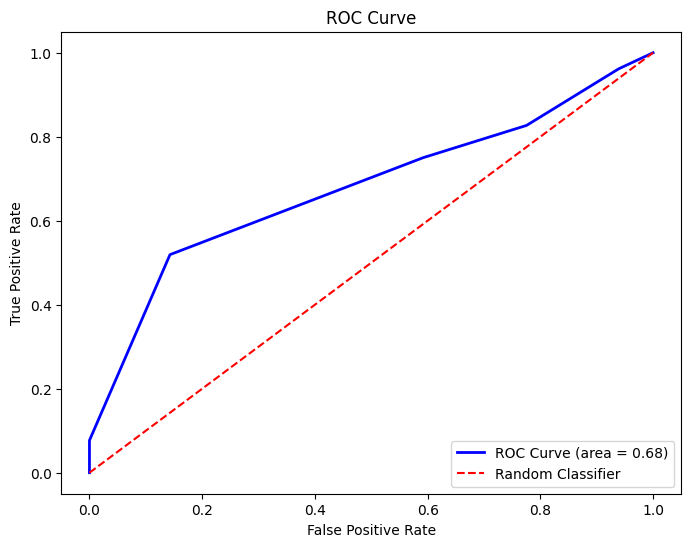

Confusion Matrix:
 [[20 29]
 [13 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.41      0.49        49
           1       0.57      0.75      0.65        52

    accuracy                           0.58       101
   macro avg       0.59      0.58      0.57       101
weighted avg       0.59      0.58      0.57       101



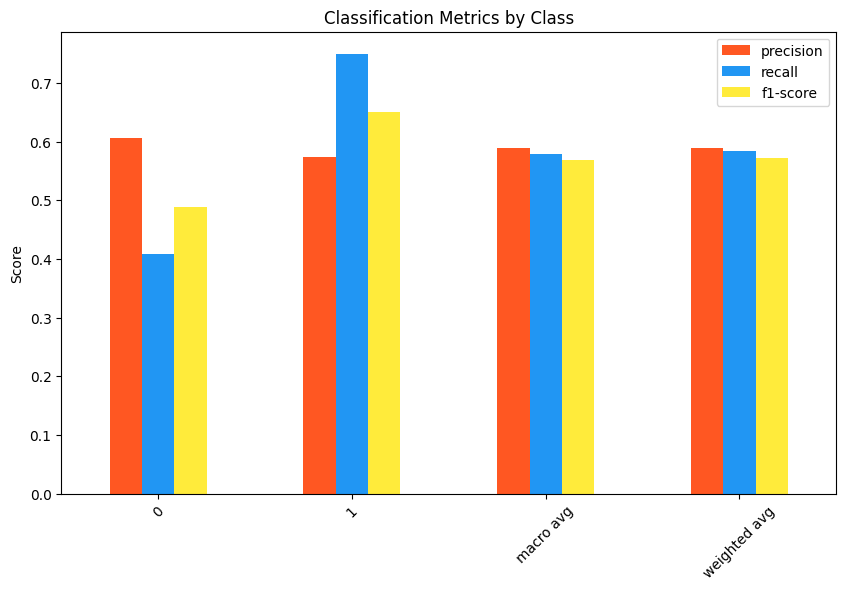

Cross-Validation AUC scores: [0.61676829 0.5453125  0.58625    0.7134375  0.70387742]
Mean Cross-Validation AUC: 0.63


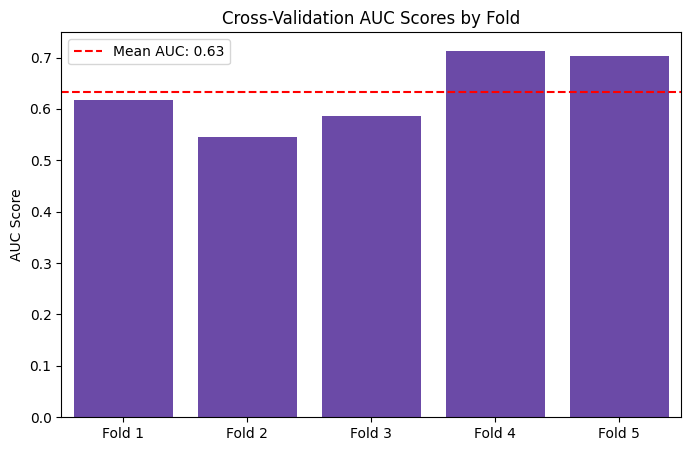

In [834]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

correlations = balanced_df.corr()["Sick"].sort_values(ascending=False)

selected_features = correlations[correlations.abs() > 0.1].index.drop("Sick")

dropped_features = set(balanced_df.columns) - set(selected_features) - {"Sick"}
kept_features = set(selected_features)

print("\nDropped features due to low correlation with target (Sick):")
print(dropped_features)

print("\nKept features with significant correlation to target (Sick):")
print(kept_features)

X_balanced_selected = balanced_df[selected_features]

y_balanced = balanced_df["Sick"]

X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced_selected), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

cross_val_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

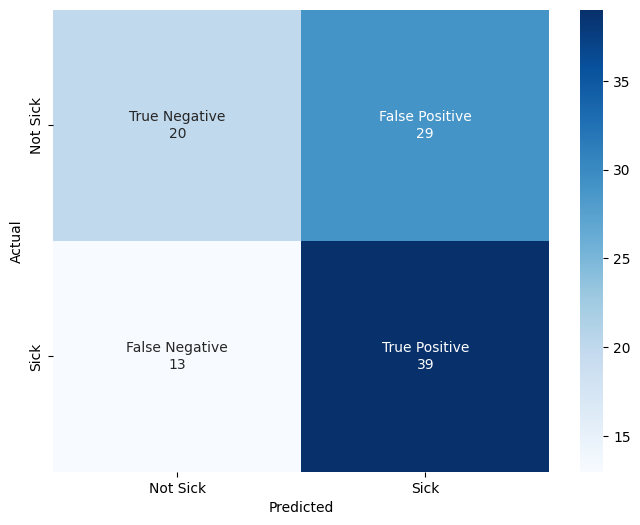

In [835]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results (undersampling & feature selection)**

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 251 instances of "sick" and "not sick" cases each.

- **Feature selection**:  
  Features with low correlation to the target ("Sick") were dropped:  
  `{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Serum 3', 'Sex', 'Serum 2', 'Arrival Weight', 'Country ID', 'Hemoglobin 3'}`  
  The following features were retained due to their significant correlation with the target:  
  `{'Meat Color', 'Slaughter Weight', 'Type', 'Fat', 'Days at Dairy Farm'}`

- **ROC AUC score**:  
  The ROC AUC score of 0.68 indicates **low discrimination ability**, showing an improvement over the model without feature selection and undersampling (ROC AUC of 0.54). However, the model still struggles to effectively distinguish between "sick" and "not sick" cases.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 20 true negatives and 29 false positives for "not sick" cases.  
  - 13 false negatives and 39 true positives for "sick" cases.  

- **Classification report**:  
  - **Class 0 ("Not Sick")**: Precision of 0.61 and recall of 0.41, indicating that the model struggles to identify "not sick" cases, with many being misclassified as "sick."  
  - **Class 1 ("Sick")**: Precision of 0.57 and recall of 0.75, suggesting that the model is better at identifying "sick" cases, but still misclassifies several as "not sick."

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.54 to 0.68, with a mean AUC of 0.63. This shows minimal improvement in stability and generalization over the model without feature selection and undersampling.

Compared to the undersampling-only model (ROC AUC of 0.60), feature selection slightly improved the model’s ROC AUC to 0.68, but the improvement is still modest. The recall for "sick" cases (0.75) is better, but precision remains low, particularly for "not sick" cases. Despite feature selection, the model still struggles with misclassification and underperforms in reliably distinguishing between "sick" and "not sick" cases.

### Data SlaughterhouseP

The five previously cleaned and analysed dataframes (from Group 2412242 Pali, Group 2336241 Pali, Group 2308249 Pali, Group 2229248 Pali & Group 2151247 Pali) are merged into a single dataframe. This allows for a consolidated analysis of all (SlaughterhouseP) calf records.

Additionally, the total number of rows (calves) in the merged dataset is printed for reference, along with a count of sick calves, providing an initial overview of the data’s size and distribution.

In [836]:
combined_df = pd.concat([
    df_final_cleaned_2412242_pali, 
    df_final_cleaned_2336241_pali,
    df_final_cleaned_2308249_pali, 
    df_final_cleaned_2229248_pali, 
    df_final_cleaned_2151247_pali
], ignore_index=True)

print(len(combined_df))

count_sick = combined_df['Sick'].sum()
print(f'Count of sick calves: {count_sick}')

2243
Count of sick calves: 381


This cell introduces a new feature, `Season`, which categorizes each calf's birth season based on its birth month. The custom function `get_season()` defines the four seasons, and each calf is assigned a season accordingly. This is followed by converting the season labels into numeric values under the `Season_Born` column, facilitating potential model use.

A sample of the `Birth Date`, `Season`, and `Season_Born` columns is displayed to verify the transformation, and the distribution of calves by birth season is printed to assess seasonal data balance.

In [837]:
combined_df['Birth Date'] = pd.to_datetime(combined_df['Birth Date'], dayfirst=True)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

combined_df['Season'] = combined_df['Birth Date'].dt.month.apply(get_season)

combined_df['Season_Born'] = pd.factorize(combined_df['Season'])[0]

print(combined_df[['Birth Date', 'Season', 'Season_Born']].head())
season_counts = combined_df['Season'].value_counts()
print("Number of calves born in each season:")
print(season_counts)

  Birth Date  Season  Season_Born
0 2024-02-20  Winter            0
1 2024-02-20  Winter            0
2 2024-02-24  Winter            0
3 2024-02-21  Winter            0
4 2024-02-20  Winter            0
Number of calves born in each season:
Season
Winter    1553
Summer     559
Spring      85
Autumn      46
Name: count, dtype: int64


This section calculates and presents **missing values (NaNs)** for each column. The output includes both the count and percentage of NaNs relative to the dataset's total size, providing insight into data completeness.

In [838]:
nan_counts = combined_df.isna().sum()
total_counts = len(combined_df)

nan_summary = pd.DataFrame({
    'NaN Count': nan_counts,
    'Percentage of Total': (nan_counts / total_counts) * 100
})

print(nan_summary)

                           NaN Count  Percentage of Total
Country ID + Calf ID               0             0.000000
Country ID                         0             0.000000
Calf ID                            0             0.000000
Birth Date                         0             0.000000
Sex                                0             0.000000
Stable                             0             0.000000
Days at Dairy Farm                 0             0.000000
Arrival Date at Veal Farm          0             0.000000
Arrival Weight                     0             0.000000
Merchant                           0             0.000000
Fur Color                          0             0.000000
Color Letter                       0             0.000000
Hemoglobin 1                       0             0.000000
Hemoglobin 2                       0             0.000000
Hemoglobin 3                       0             0.000000
Serum 2                            0             0.000000
Serum 3       

The categorical columns `Fur Color`, `Type`, `Merchant`, and `Country ID` are transformed into numerical codes to enable their use in correlation analysis and modeling. This factorization assigns unique integer values to each category in these columns. Following the transformation, the code prints the number of unique values in each of these columns to confirm the encoding. Additionally, a sample of the transformed values is displayed to verify that the encoding has been applied correctly.

In [839]:
combined_df['Fur Color'] = pd.factorize(combined_df['Fur Color'])[0]
combined_df['Type'] = pd.factorize(combined_df['Type'])[0]
combined_df['Merchant'] = pd.factorize(combined_df['Merchant'])[0]
combined_df['Country ID'] = pd.factorize(combined_df['Country ID'])[0]

unique_counts = {
    'Fur Color': combined_df['Fur Color'].nunique(),
    'Type': combined_df['Type'].nunique(),
    'Merchant': combined_df['Merchant'].nunique(),
    'Country ID': combined_df['Country ID'].nunique()
}

print(unique_counts)

print(combined_df[['Fur Color', 'Type', 'Merchant', 'Country ID']].head(5))

{'Fur Color': 6, 'Type': 9, 'Merchant': 9, 'Country ID': 5}
   Fur Color  Type  Merchant  Country ID
0          0     0         0           0
1          1     1         0           0
2          0     0         0           0
3          1     1         0           0
4          1     2         0           0


This code calculates the Pearson correlation coefficients for all numerical features, focusing on identifying linear relationships between them. A heatmap visualizes these correlations, with emphasis on detecting any initial relationships that might exist between the features and calf sickness (`Sick`). However, this approach only evaluates single-feature correlations, meaning complex relationships across multiple features are not captured. Further analysis through model training will be needed to explore potential multivariate relationships.

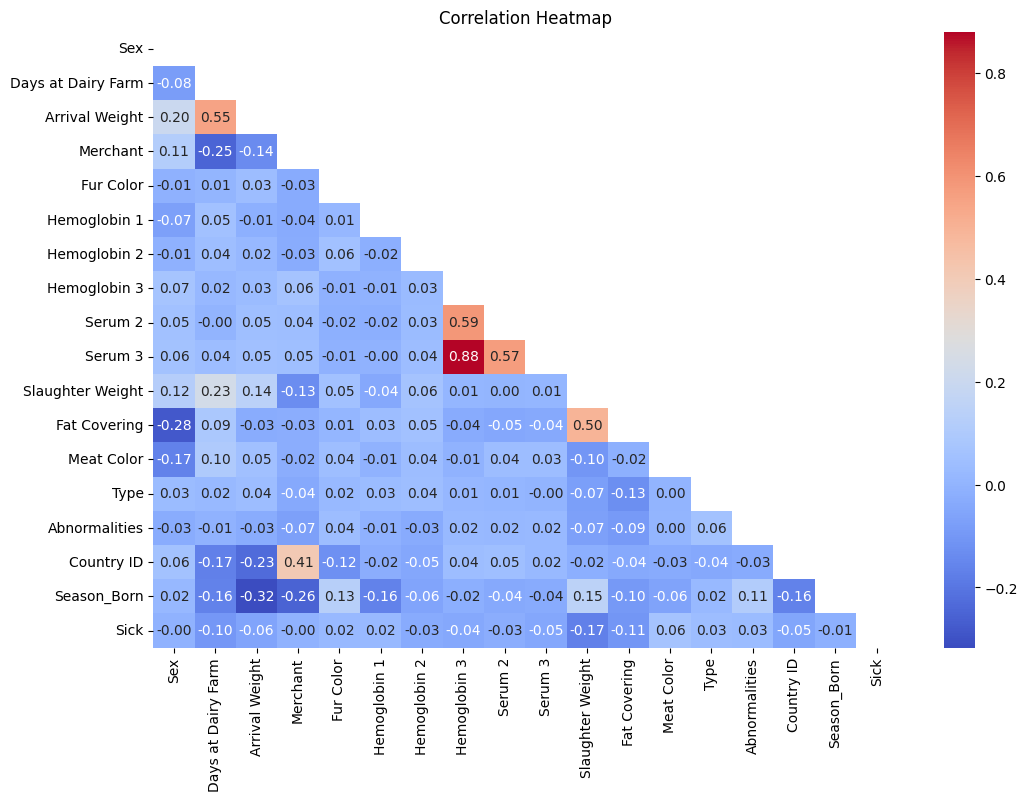

In [840]:
numeric_df = combined_df[['Sex', 'Days at Dairy Farm', 'Arrival Weight', 
                          'Merchant', 'Fur Color', 'Hemoglobin 1', 
                          'Hemoglobin 2', 'Hemoglobin 3', 'Serum 2', 
                          'Serum 3', 'Slaughter Weight', 
                          'Fat Covering', 'Meat Color', 'Type', 
                          'Abnormalities', 'Country ID', 'Season_Born', 'Sick']]

correlations = numeric_df.corr()

mask = np.triu(np.ones_like(correlations, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(correlations, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Heatmap')
plt.show()

The Pearson correlation analysis found **no strong correlations** between a calf getting sick and other features in the dataset. This suggests that, as mentioned earlier, modeling techniques are needed to explore possible interactions among **multiple** variables affecting calf health.

#### Support Vector Machine (Regression) - Data SlaughterhouseP

This code cell performs several key steps to prepare the data, train the model, and evaluate its performance on predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the SVR model**  
   A Support Vector Regression (SVR) model is trained on the scaled training data. SVR is traditionally used for continuous target variables, it is explored here to see if it can help in predicting the `Sick` status, albeit as a regression task. 

5. **Model evaluation**  
   The `R^2` score on the test set is calculated to determine the proportion of variance in `Sick` explained by the model. An `R^2` score closer to 1 would indicate a strong model, whereas values near or below zero suggest weak predictive power. This initial score provides insight into the model's suitability for this task.

6. **Error metrics**  
   Two error metrics are computed: 
   - **Root Mean Squared Error (RMSE)**: Measures the average prediction error, with larger errors penalized more heavily.
   - **Mean Absolute Error (MAE)**: Measures the average magnitude of errors in predictions, providing a straightforward measure of model accuracy.

7. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
Model R^2: 0.01
Root Mean Squared Error (RMSE): 0.37
Mean Absolute Error (MAE): 0.23


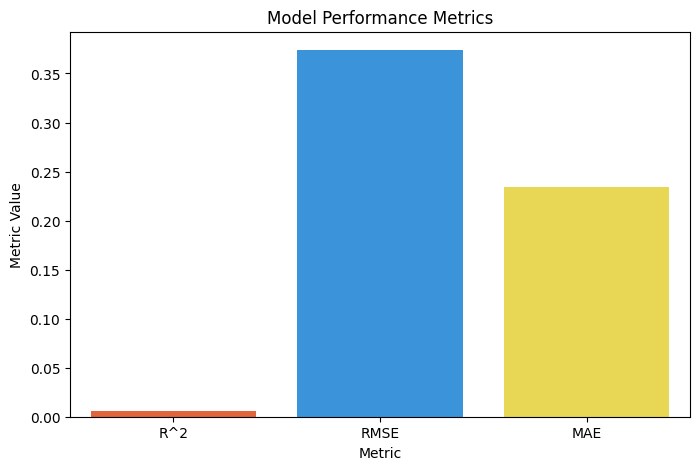

Cross-Validation R^2 scores: [ 0.05319707 -0.00749324 -0.00290507 -0.01651386  0.01707959]
Mean Cross-Validation R^2: 0.01


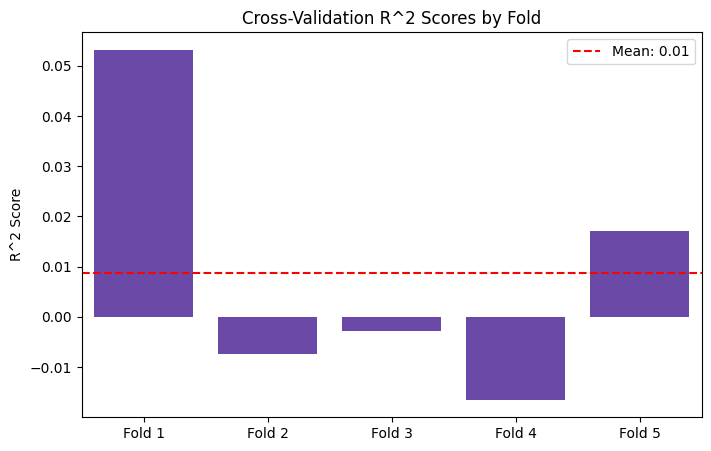

In [841]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results:**

- **R^2 score**:  
  The score of 0.01 indicates that the SVR model explains almost none of the variance in the target variable. This low score suggests the model may not be effectively capturing the patterns needed for reliable predictions.
  - Given the limited range of `Sick` (0 to 1), R² may be less informative on its own and should be interpreted alongside error metrics like RMSE and MAE.
  - A negative value may indicate feature noise, missing predictive features for sickness in the dataset, or an unsuitable model.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.37 and MAE of 0.23 represent substantial prediction errors, especially given the target’s range from 0 to 1. These metrics imply that the model's predictions often deviate significantly from the actual values, reinforcing the limitations in predictive accuracy indicated by the low R^2.
  - In this context, the errors are large relative to the target range, which suggests that the model might not be suitable for this regression task without further tuning or alternative approaches.

- **Cross-validation R^2 scores**:  
  The cross-validation scores, ranging from -0.016 to 0.05 with a mean of 0.01, are consistently negative. This indicates that the model performs poorly across different data folds, which highlights a lack of generalizability and further suggests that SVR may not be the most appropriate model for this prediction task.

In [842]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

      Actual  Predicted
1743       0   0.088565
217        0   0.082291
1007       0   0.094831
1865       0   0.106199
651        0   0.090787
1986       1   0.148472
2066       1   0.188924
39         1   0.023603
199        1   0.100652
277        1   0.866741


##### Undersampling

This code cell addresses class imbalance in the dataset by applying **undersampling** to the majority class, `Not sick`. Class imbalance, where one class has significantly more instances than the other, can bias the model, as it may overly focus on the majority class while underperforming on the minority class.

1. **Undersampling the majority class**  
   To balance the classes, we randomly sample a subset of "Healthy" instances to match the count of "Sick" instances. This process creates a new balanced dataset where both classes have equal representation, reducing potential model bias.

2. **Verifying class balance**  
   We print the counts of each class in the new balanced dataset (`balanced_df`) to confirm that both classes are equally represented.

3. **Redefining features and target**  
   Using the balanced dataset, we redefine the features (`X_balanced`) and target (`y_balanced`) to ensure that the model trains on this new, unbiased data.

Counts of each class in balanced_df:
Sick
0    381
1    381
Name: count, dtype: int64

There are in total 762 observations, of which 609 are now in the train set, and 153 in the test set.
Model R^2: 0.05
Root Mean Squared Error (RMSE): 0.49
Mean Absolute Error (MAE): 0.41


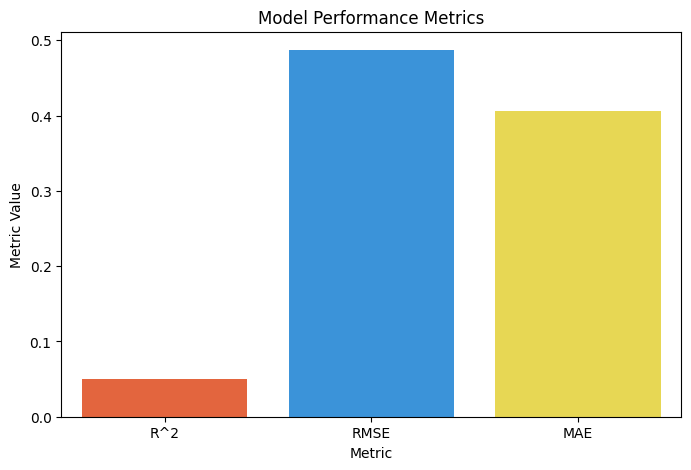

Cross-Validation R^2 scores: [-0.07956136 -0.08647341 -0.06623952 -0.03205426 -0.03966569]
Mean Cross-Validation R^2: -0.06


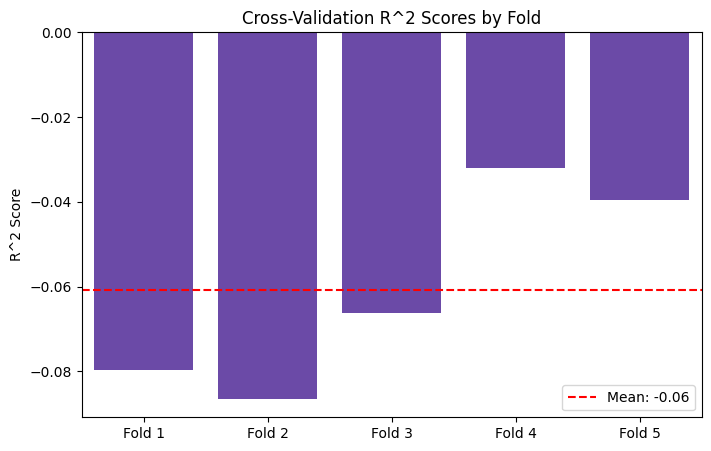

In [843]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

features = balanced_df.drop(columns="Sick").columns
target = "Sick"

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results (undersampling):**

- **Class balance**:  
  The dataset has been balanced, resulting in equal counts for both classes (381 instances of each). This step helps prevent class imbalance from impacting model performance, creating a more balanced distribution for training and testing.

- **R² score**:  
  The model's R² score of 0.05 suggests that it only explains a small fraction of the variance in the target variable. While this indicates some predictive power, the low score implies that the model is not effectively capturing the patterns needed to predict `Sick` with high accuracy.
  - This low score could suggest noise in the features, a lack of predictive features in the dataset for `Sick`, or that SVR may not be the best choice for this task.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.49 and MAE of 0.41 indicate substantial prediction errors relative to the target’s 0-1 range, with the model often deviating significantly from actual values. 
  - These errors reinforce that the model has limited predictive accuracy even after undersampling.

- **Cross-validation R² scores**:  
  Cross-validation R² scores range from -0.09 to -0.03, with a mean of -0.06. These consistently negative scores across the folds suggest poor model performance and highlight the model's inability to generalize well to different data splits. 

In summary, even with undersampling, the model's low R² and high error metrics indicate limited predictive capability.

##### Undersampling + Feature selection

This code cell introduces **feature selection** to reduce potential noise from irrelevant features, which could be contributing to the model's poor performance and possibly resulting in a negative R^2 score.

1. **Calculating correlations**  
   To identify features most relevant to the target variable (`Sick`), we calculate the correlation of each feature with `Sick`. Features with an absolute correlation above 0.1 are selected, as they likely contain useful information for predicting the target. This threshold helps retain only those features with a meaningful relationship to the target.

2. **Dropping low-correlation features**  
   Features with correlations below 0.1 are considered to have minimal relevance to `Sick` and are removed. By excluding these low-correlation features, we aim to reduce noise in the data, improving model performance by focusing on more predictive variables.

3. **Feature set redefinition**  
   After filtering, we redefine `X_balanced_selected` as the dataset containing only the selected features. This reduced feature set is then used in training and testing.

If these changes do not remove the negative R^2, it may indicate that the current model is not suitable, or that the dataset lacks features capable of effectively predicting sickness.

Counts of each class in balanced_df:
Sick
0    381
1    381
Name: count, dtype: int64

Dropped features due to low correlation with target (Sick):
{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Type', 'Serum 3', 'Sex', 'Abnormalities', 'Serum 2', 'Arrival Weight', 'Hemoglobin 3'}

Kept features with significant correlation to target (Sick):
{'Meat Color', 'Slaughter Weight', 'Fat Covering', 'Country ID', 'Days at Dairy Farm'}

There are in total 762 observations, of which 609 are now in the train set, and 153 in the test set.
Model R^2: -0.02
Root Mean Squared Error (RMSE): 0.51
Mean Absolute Error (MAE): 0.40


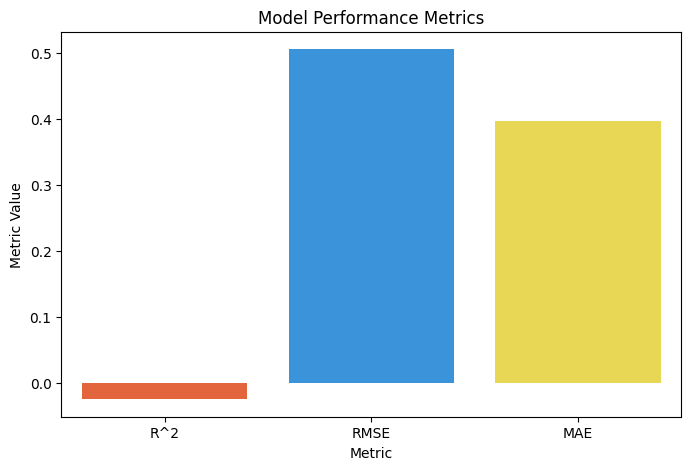

Cross-Validation R^2 scores: [-0.0697777  -0.12058229  0.05366692 -0.14667914 -0.0754559 ]
Mean Cross-Validation R^2: -0.07


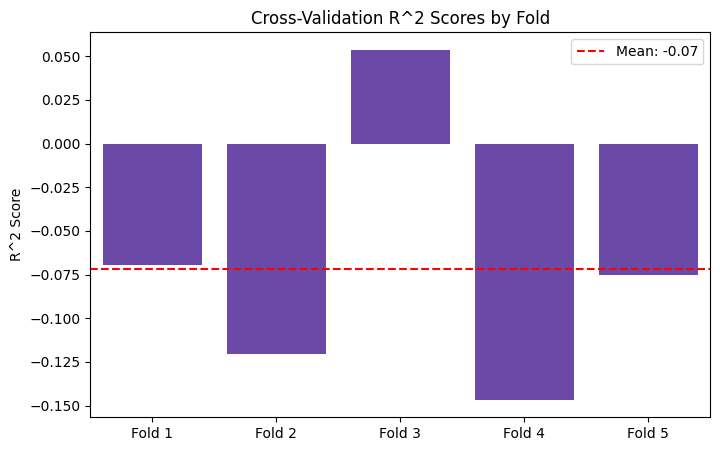

In [844]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

correlations = balanced_df.corr()["Sick"].sort_values(ascending=False)

selected_features = correlations[correlations.abs() > 0.1].index.drop("Sick")

dropped_features = set(balanced_df.columns) - set(selected_features) - {"Sick"}
kept_features = set(selected_features)

print("\nDropped features due to low correlation with target (Sick):")
print(dropped_features)

print("\nKept features with significant correlation to target (Sick):")
print(kept_features)

X_balanced_selected = balanced_df[selected_features]

y_balanced = balanced_df["Sick"]

X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced_selected), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = SVR()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results (undersampling & feature selection):**

- **Feature selection**:  
  Features with low correlation to the target variable `Sick` were removed to focus on those with potentially greater predictive power. The following features were dropped due to low correlation:
  - Dropped: `{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Type', 'Serum 3', 'Sex', 'Abnormalities', 'Serum 2', 'Arrival Weight', 'Hemoglobin 3'}`
  - Kept (significantly correlated): `{'Meat Color', 'Slaughter Weight', 'Fat Covering', 'Country ID', 'Days at Dairy Farm'}`

  These remaining features are hypothesized to be more relevant to predicting sickness based on their correlation with the target variable.

- **R² score**:  
  Despite feature selection, the model’s R² score is -0.02, indicating that the SVR model still explains almost none of the variance in the target variable. This suggests that even with targeted features, the model struggles to capture patterns related to sickness prediction.

- **Error metrics (RMSE and MAE)**:  
  - RMSE is 0.51 and MAE is 0.40, indicating considerable prediction errors relative to the 0-1 range of `Sick`. These metrics suggest that the model's predictions still deviate significantly from actual values, even with the refined feature set.

- **Cross-validation R² scores**:  
  The cross-validation scores vary from -0.12 to 0.05, with a mean of -0.07. These results show that the model performs inconsistently across folds, reinforcing the lack of reliable predictive power.

The low R² and high error metrics, despite undersampling and feature selection, suggest that features capable of predicting sickness are likely absent from the dataset. This approach may therefore be unsuitable for predicting `Sick`. While it’s possible that an alternative model could yield better results, the current feature set and model combination do not appear sufficient for effective prediction.

#### Logistic Regression (Classification) - Data SlaughterhouseP

This code cell prepares the data, trains a class-balanced **Logistic Regression** model, and evaluate its performance in predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. By defining `Sick` as the target, the goal is to predict whether or not an observation is classified as "sick" based on other factors. 

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the logistic regression model**  
   A Logistic Regression model with `class_weight='balanced'` is used to account for class imbalance. This configuration assigns a higher weight to the minority class, potentially improving the model’s ability to correctly predict the "sick" class.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **ROC AUC Score**: The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) score measures the model’s ability to distinguish between the "sick" and "not sick" classes. An AUC score ranges from 0 to 1:
      - **1** indicates perfect discrimination, where the model accurately distinguishes between all "sick" and "not sick" cases.
      - **0.5** suggests no discriminatory power, equivalent to random guessing.
      - **Values closer to 1** indicate stronger model performance in correctly classifying cases, with higher scores representing a better balance between true positive and false positive rates across all possible thresholds.
   - **Confusion matrix**: Shows true positives, true negatives, false positives, and false negatives, providing insight into prediction errors.
   - **Classification report**: Displays precision, recall, and F1-score for both classes, essential for evaluating performance on imbalanced data.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The average cross-validation ROC AUC score serves as an indicator of the model’s consistency.

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
ROC AUC Score: 0.63


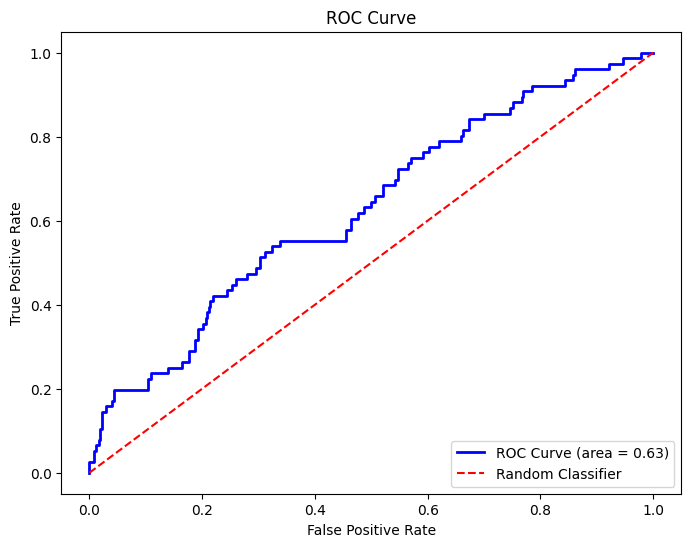

Confusion Matrix:
 [[228 145]
 [ 34  42]]
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.61      0.72       373
           1       0.22      0.55      0.32        76

    accuracy                           0.60       449
   macro avg       0.55      0.58      0.52       449
weighted avg       0.76      0.60      0.65       449



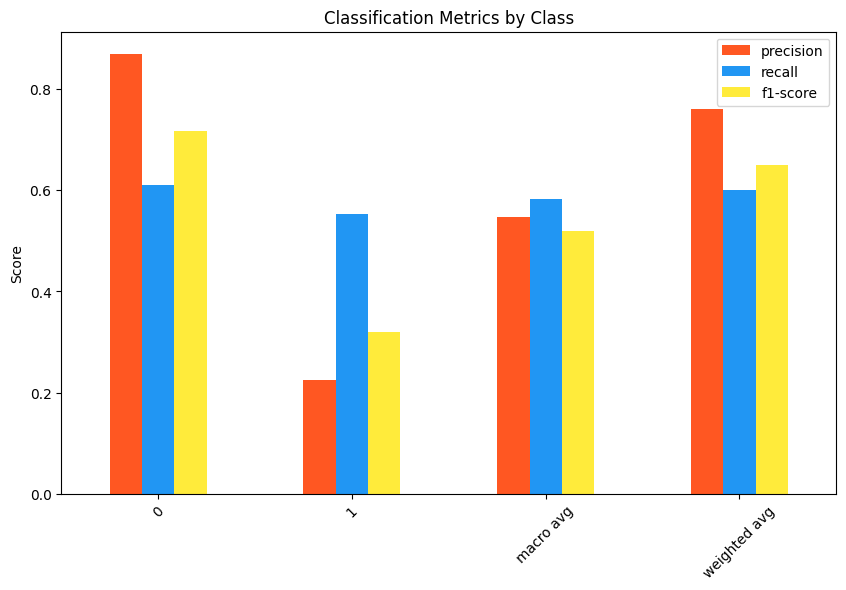

Cross-Validation AUC scores: [0.61535923 0.57773132 0.66767521 0.63516338 0.64480874]
Mean Cross-Validation AUC: 0.63


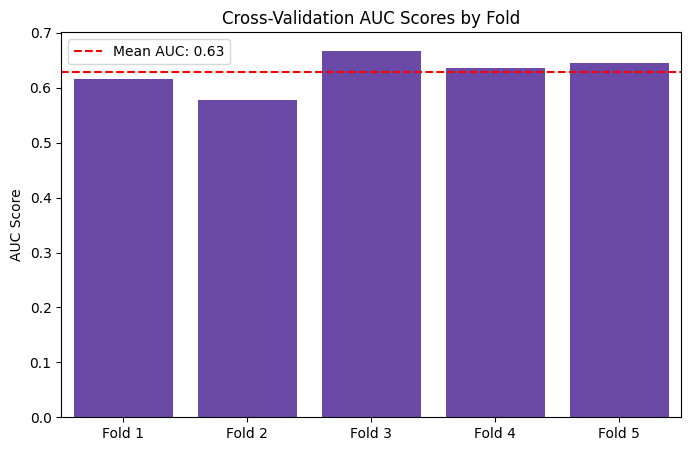

In [845]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

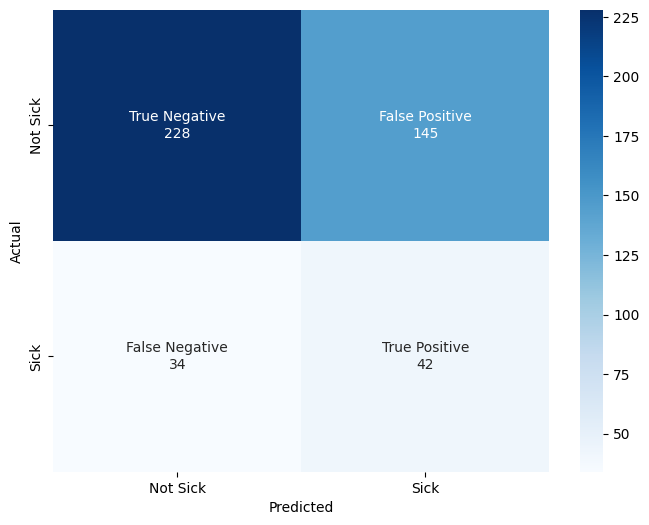

In [846]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results**  

- **ROC AUC score**:  
  The ROC AUC score of 0.63 indicates **low discrimination ability**, suggesting that the model's ability to distinguish between "sick" and "not sick" cases is weak.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 228 true negatives and 145 false positives for "not sick" cases.  
  - 34 false negatives and 42 true positives for "sick" cases.  

- **Classification report**:
  - **Class 0 ("Not Sick")**: Precision of 0.87 and recall of 0.61, indicating that the model has good precision but struggles with recall, misclassifying several "not sick" cases as "sick."
  - **Class 1 ("Sick")**: Precision of 0.22 and recall of 0.55, showing that the model struggles with predicting "sick" cases, as reflected in both the low precision and recall.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.58 to 0.67, with a mean AUC of 0.63. This variability suggests that while the model's performance is somewhat consistent, there is still significant room for improvement in terms of stability and generalization.

In [847]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

      Actual  Predicted
1743       0          0
217        0          0
1007       0          0
1865       0          1
651        0          0
1986       1          0
2066       1          1
39         1          0
199        1          0
277        1          1


##### Undersampling

This code cell addresses class imbalance in the dataset by applying **undersampling** to the majority class, `Not sick`. Class imbalance, where one class has significantly more instances than the other, can bias the model, as it may overly focus on the majority class while underperforming on the minority class.

1. **Undersampling the majority class**  
   To balance the classes, we randomly sample a subset of "Healthy" instances to match the count of "Sick" instances. This process creates a new balanced dataset where both classes have equal representation, reducing potential model bias.

2. **Verifying class balance**  
   We print the counts of each class in the new balanced dataset (`balanced_df`) to confirm that both classes are equally represented.

3. **Redefining features and target**  
   Using the balanced dataset, we redefine the features (`X_balanced`) and target (`y_balanced`) to ensure that the model trains on this new, unbiased data.

Counts of each class in balanced_df:
Sick
0    381
1    381
Name: count, dtype: int64

There are in total 762 observations, of which 609 are now in the train set, and 153 in the test set.
ROC AUC Score: 0.66


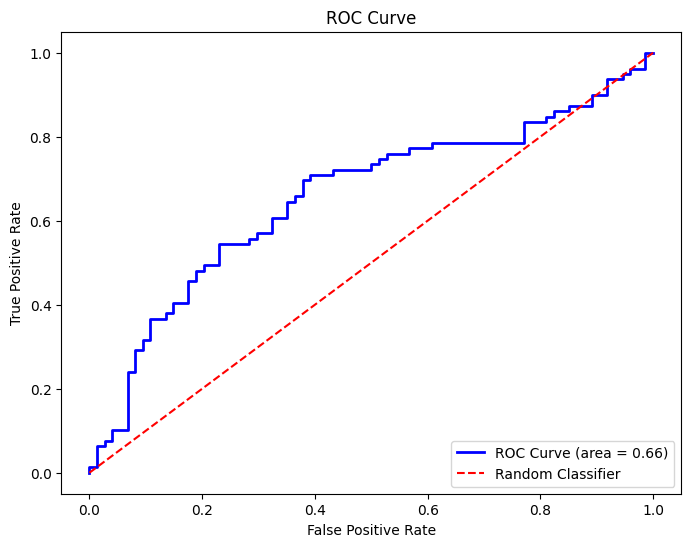

Confusion Matrix:
 [[47 27]
 [28 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.64      0.63        74
           1       0.65      0.65      0.65        79

    accuracy                           0.64       153
   macro avg       0.64      0.64      0.64       153
weighted avg       0.64      0.64      0.64       153



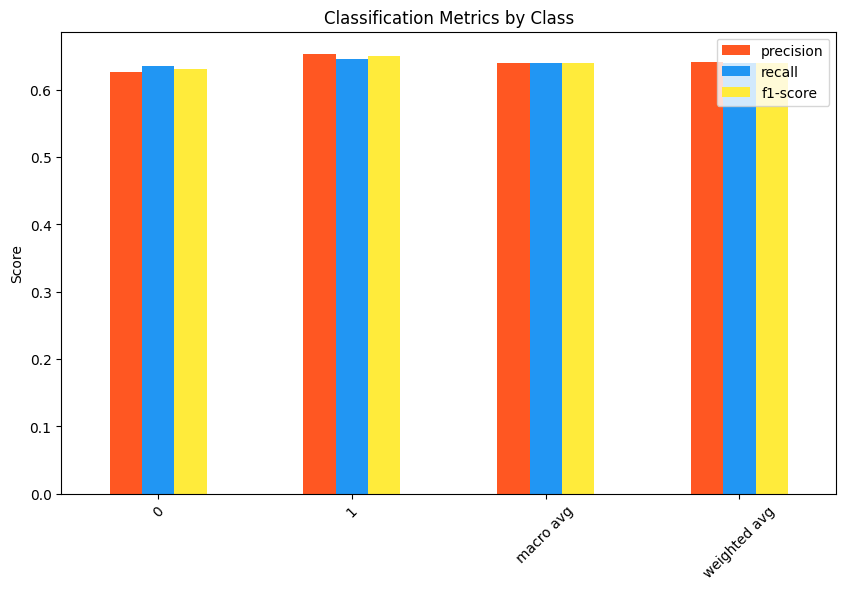

Cross-Validation AUC scores: [0.59354839 0.61989247 0.69201827 0.64149422 0.61284153]
Mean Cross-Validation AUC: 0.63


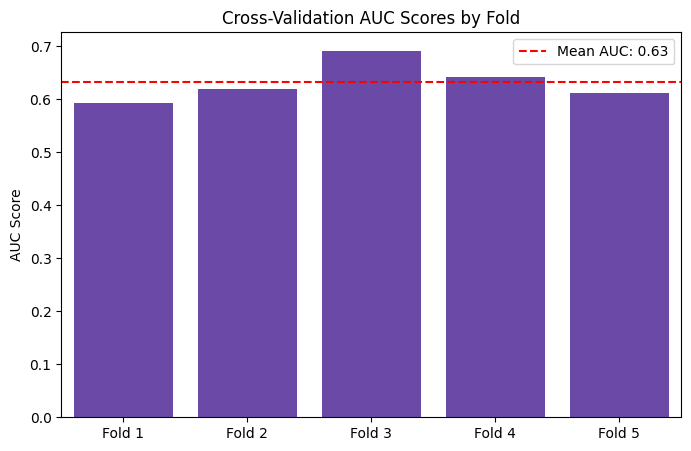

In [848]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

features = balanced_df.drop(columns="Sick").columns
target = "Sick"

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

cross_val_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

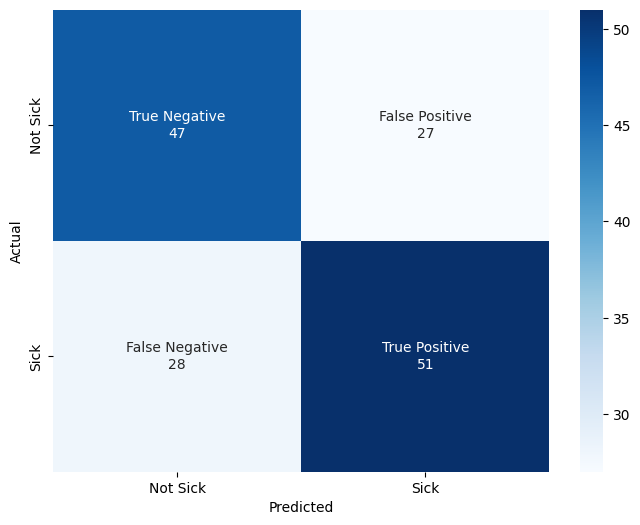

In [849]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results (undersampling)**  

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 381 instances of "sick" and "not sick" cases each. This helps mitigate the effects of class imbalance.

- **ROC AUC score**:  
  The ROC AUC score of 0.66 indicates **low discrimination ability**, slightly improving over the results without undersampling, but still showing that the model struggles to effectively distinguish between "sick" and "not sick" cases.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 47 true negatives and 27 false positives for "not sick" cases.  
  - 28 false negatives and 51 true positives for "sick" cases.  

- **Classification report**:  
  - **Class 0 ("Not Sick")**: Precision of 0.63 and recall of 0.64, indicating that both precision and recall are **low to moderate**, with the model misclassifying some "not sick" cases as "sick."  
  - **Class 1 ("Sick")**: Precision of 0.65 and recall of 0.65, showing that the model performs somewhat better at identifying "sick" cases, but both precision and recall remain moderate.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.59 to 0.69, with a mean AUC of 0.63. This shows only a slight improvement over the model without undersampling, but the performance remains inconsistent, with room for further improvement.

Compared to the results without undersampling (ROC AUC score of 0.63), undersampling slightly improved the model's performance (ROC AUC of 0.66). However, the model still struggles significantly with both "sick" and "not sick" cases, showing only modest improvement. The recall and precision for "sick" cases (both 0.65) have improved but are still not sufficient. Overall, while undersampling helped balance the dataset, the model's performance remains suboptimal.

##### Undersampling + Feature selection

This code cell introduces **feature selection** to reduce potential noise from irrelevant features, which could be contributing to the model's poor performance.

1. **Calculating correlations**  
   To identify features most relevant to the target variable (`Sick`), we calculate the correlation of each feature with `Sick`. Features with an absolute correlation above 0.1 are selected, as they likely contain useful information for predicting the target. This threshold helps retain only those features with a meaningful relationship to the target.

2. **Dropping low-correlation features**  
   Features with correlations below 0.1 are considered to have minimal relevance to `Sick` and are removed. By excluding these low-correlation features, we aim to reduce noise in the data, improving model performance by focusing on more predictive variables.

3. **Feature set redefinition**  
   After filtering, we redefine `X_balanced_selected` as the dataset containing only the selected features. This reduced feature set is then used in training and testing.

If these changes do not improve the performance, it may indicate that the current model is not suitable, or that the dataset lacks features capable of effectively predicting sickness.

Counts of each class in balanced_df:
Sick
0    381
1    381
Name: count, dtype: int64

Dropped features due to low correlation with target (Sick):
{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Type', 'Serum 3', 'Sex', 'Abnormalities', 'Serum 2', 'Arrival Weight', 'Hemoglobin 3'}

Kept features with significant correlation to target (Sick):
{'Meat Color', 'Slaughter Weight', 'Fat Covering', 'Country ID', 'Days at Dairy Farm'}

There are in total 762 observations, of which 609 are now in the train set, and 153 in the test set.
ROC AUC Score: 0.68


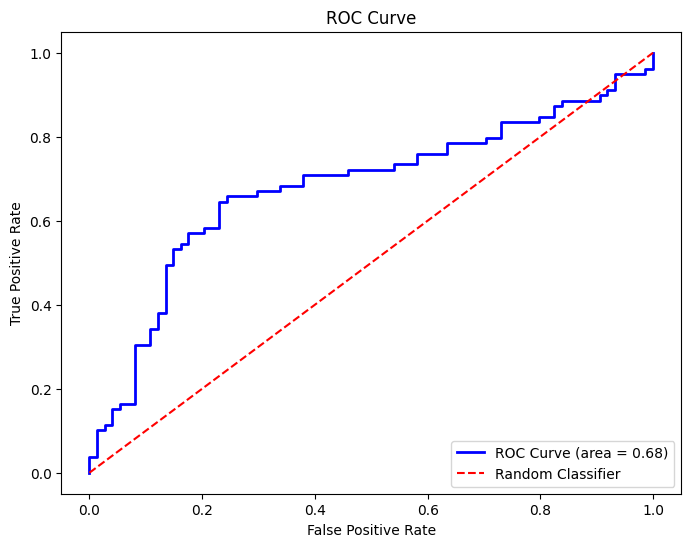

Confusion Matrix:
 [[50 24]
 [26 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.68      0.67        74
           1       0.69      0.67      0.68        79

    accuracy                           0.67       153
   macro avg       0.67      0.67      0.67       153
weighted avg       0.67      0.67      0.67       153



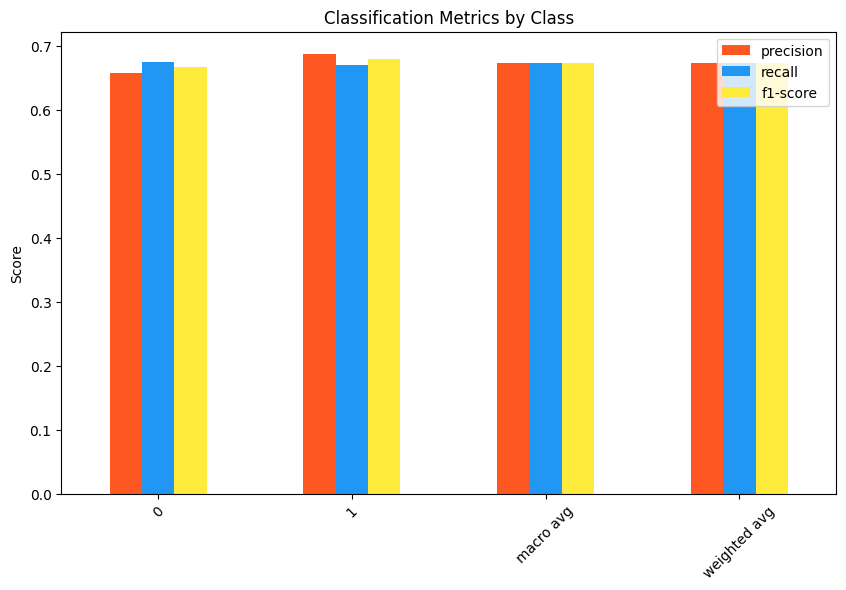

Cross-Validation AUC scores: [0.62768817 0.61827957 0.76619188 0.63692556 0.63989071]
Mean Cross-Validation AUC: 0.66


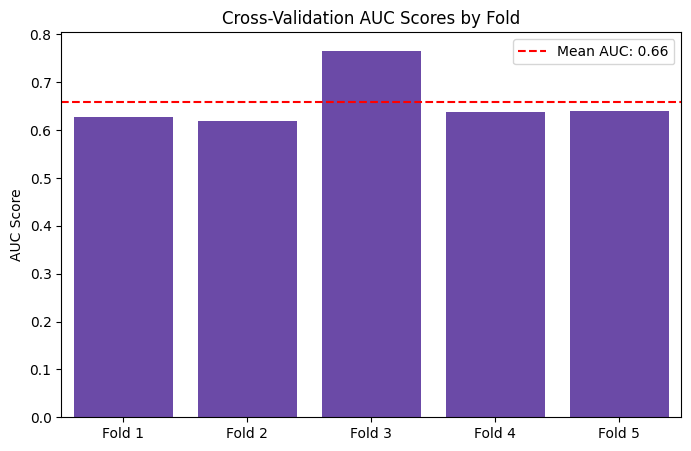

In [850]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

correlations = balanced_df.corr()["Sick"].sort_values(ascending=False)

selected_features = correlations[correlations.abs() > 0.1].index.drop("Sick")

dropped_features = set(balanced_df.columns) - set(selected_features) - {"Sick"}
kept_features = set(selected_features)

print("\nDropped features due to low correlation with target (Sick):")
print(dropped_features)

print("\nKept features with significant correlation to target (Sick):")
print(kept_features)

X_balanced_selected = balanced_df[selected_features]

y_balanced = balanced_df["Sick"]

X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced_selected), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

cross_val_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

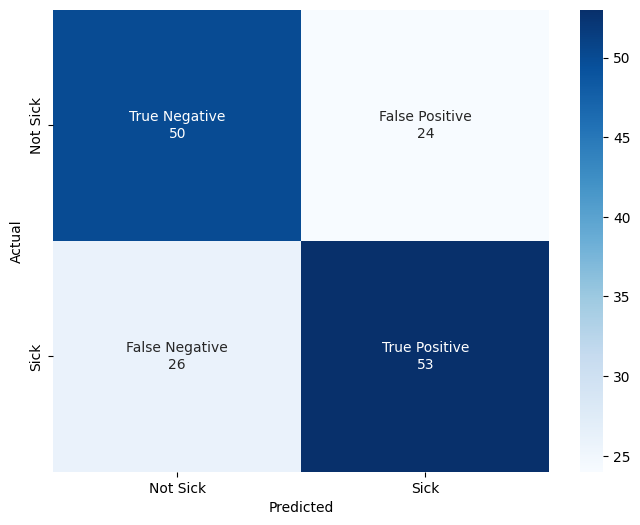

In [851]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results (undersampling & feature selection)**  

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 381 instances of "sick" and "not sick" cases each.

- **Feature selection**:  
  Features with low correlation to the target ("Sick") were dropped:  
  `{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Type', 'Serum 3', 'Sex', 'Abnormalities', 'Serum 2', 'Arrival Weight', 'Hemoglobin 3'}`  
  The following features were retained due to their 'significant' correlation with the target:  
  `{'Meat Color', 'Slaughter Weight', 'Fat Covering', 'Country ID', 'Days at Dairy Farm'}`

- **ROC AUC score**:  
  The ROC AUC score of 0.68 indicates **low discrimination ability**, showing a slight improvement over the model with only undersampling (ROC AUC of 0.67). The model still struggles to effectively distinguish between "sick" and "not sick" cases.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 50 true negatives and 24 false positives for "not sick" cases.  
  - 26 false negatives and 53 true positives for "sick" cases.  

- **Classification report**:  
  - **Class 0 ("Not Sick")**: Precision of 0.66 and recall of 0.68, indicating that both precision and recall are **moderate**, with the model misclassifying a number of "not sick" cases as "sick."  
  - **Class 1 ("Sick")**: Precision of 0.69 and recall of 0.67, showing that both precision and recall for "sick" cases are **moderate**.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.63 to 0.77, with a mean AUC of 0.66. This shows a slight improvement in stability and generalization over the model with undersampling, but the performance remains relatively inconsistent.

While feature selection slightly improved the model's ROC AUC score from 0.67 to 0.68, the overall performance remains modest. The model continues to struggle with both precision and recall, particularly for distinguishing between "sick" and "not sick" cases. Despite balancing the dataset and refining the feature set, the recall for "sick" cases (0.67) and precision (0.69) remain suboptimal, and misclassifications persist.

#### Linear Regression (Regression) - Data SlaughterhouseP

This code cell prepares the data, trains a **Linear regression** model, and evaluates its performance in predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance.

4. **Training the linear regression model**  
   A Linear Regression model is fitted on the scaled training data. The goal is to learn the relationship between the features and the target variable.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **R² Score**: Indicates how well the model explains the variance in the target variable. Values closer to 1 suggest better performance.
   - **Root Mean Squared Error (RMSE)**: Measures the average magnitude of the errors between predicted and actual values, providing insight into model accuracy.
   - **Mean Absolute Error (MAE)**: Represents the average absolute difference between predicted and actual values, giving a straightforward measure of prediction error.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The mean cross-validation `R^2` score provides a robust indicator of model generalizability across different data splits.

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
Model R^2: 0.04
Root Mean Squared Error (RMSE): 0.37
Mean Absolute Error (MAE): 0.27


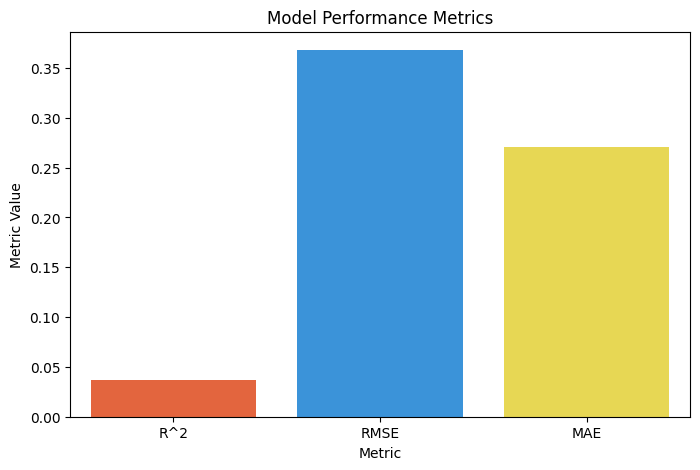

Cross-Validation R^2 scores: [0.02046749 0.00715721 0.04463991 0.01919496 0.0333001 ]
Mean Cross-Validation R^2: 0.02


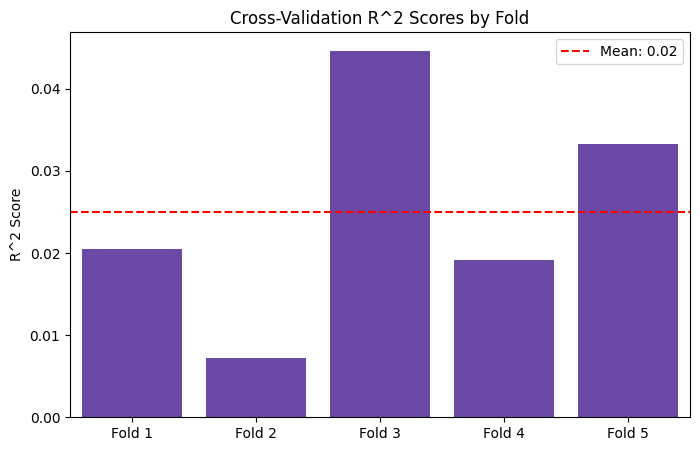

In [852]:
features = numeric_df.drop(columns='Sick').columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='r2')
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results:**

- **R² score**:  
  The R² score of 0.04 indicates that the linear regression model explains only 4% of the variance in the target variable `Sick`. This low score suggests that the model may not be effectively capturing the underlying patterns in the data.
  - Given the limited range of `Sick` (0 to 1), R² may be less informative on its own and should be interpreted alongside error metrics like RMSE and MAE.
  - A negative value may indicate feature noise, missing predictive features for sickness in the dataset, or an unsuitable model.

- **Error metrics (RMSE and MAE)**:  
  - The **Root Mean Squared Error (RMSE)** of 0.37 and **Mean Absolute Error (MAE)** of 0.27 represent substantial prediction errors, particularly considering that the target variable ranges from 0 to 1. These metrics imply that the model's predictions often significantly deviate from the actual values, which is consistent with the low R² score.
  - In this context, these relatively large errors indicate that the linear regression model may not be optimal for this prediction task, and further tuning or alternative approaches may be necessary.

- **Cross-validation R² scores**:  
  The cross-validation R² scores range from 0.01 to 0.04 with a mean of 0.02. These low scores across different folds show that the model's performance remains consistently weak and lacks generalizability across various data subsets. This further suggests that the linear regression model might not be well-suited for this particular dataset.

In [853]:
predictions_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
})

zero_predictions = predictions_df[predictions_df['Actual'] == 0].head(5)

one_predictions = predictions_df[predictions_df['Actual'] == 1].head(5)

result_df = pd.concat([zero_predictions, one_predictions])

print(result_df)

      Actual  Predicted
1743       0   0.130168
217        0   0.075623
1007       0   0.171409
1865       0   0.279624
651        0   0.119516
1986       1   0.135877
2066       1   0.227732
39         1   0.163911
199        1   0.157666
277        1   0.340263


##### Undersampling

This code cell addresses class imbalance in the dataset by applying **undersampling** to the majority class, `Not sick`. Class imbalance, where one class has significantly more instances than the other, can bias the model, as it may overly focus on the majority class while underperforming on the minority class.

1. **Undersampling the majority class**  
   To balance the classes, we randomly sample a subset of "Healthy" instances to match the count of "Sick" instances. This process creates a new balanced dataset where both classes have equal representation, reducing potential model bias.

2. **Verifying class balance**  
   We print the counts of each class in the new balanced dataset (`balanced_df`) to confirm that both classes are equally represented.

3. **Redefining features and target**  
   Using the balanced dataset, we redefine the features (`X_balanced`) and target (`y_balanced`) to ensure that the model trains on this new, unbiased data.

Counts of each class in balanced_df:
Sick
0    381
1    381
Name: count, dtype: int64

There are in total 762 observations, of which 609 are now in the train set, and 153 in the test set.
Model R^2: 0.04
Root Mean Squared Error (RMSE): 0.49
Mean Absolute Error (MAE): 0.46


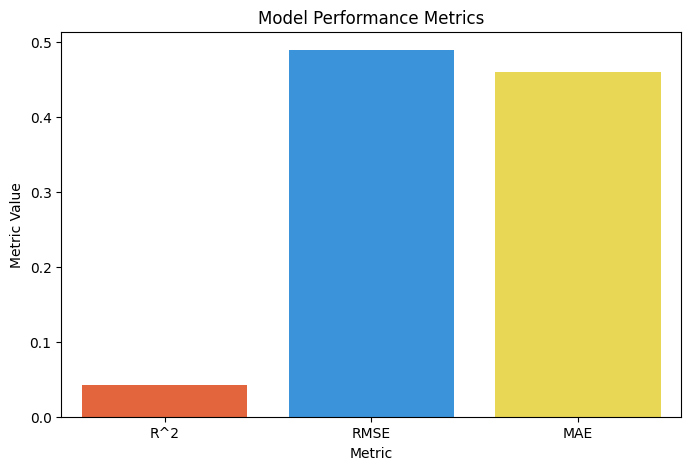

Cross-Validation R^2 scores: [-0.0357604   0.05085009  0.09979812 -0.00089876  0.02965054]
Mean Cross-Validation R^2: 0.03


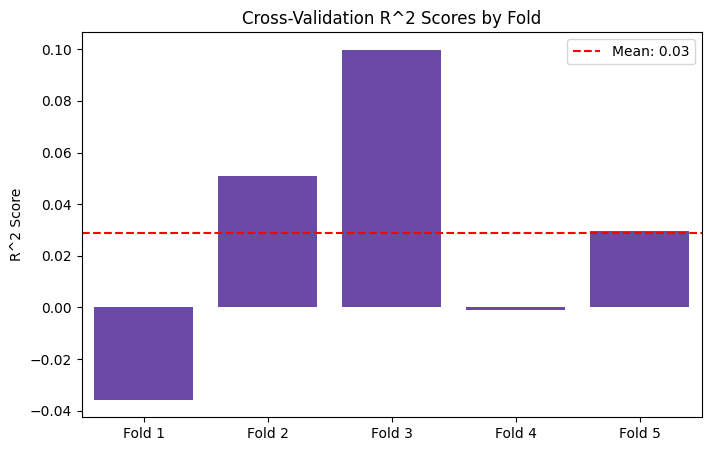

In [854]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

features = balanced_df.drop(columns="Sick").columns
target = "Sick"

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results (undersampling):**

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 381 instances of "sick" and "not sick" cases each. This helps mitigate the effects of class imbalance.

- **R² score**:  
  The model’s R² score of 0.04 indicates minimal explanatory power, suggesting that undersampling did not lead to significant improvement in capturing variance in the target variable. The R² score remains low, reflecting the challenges in predicting sickness.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.49 and MAE of 0.46 indicate considerable prediction errors, especially considering the target's range from 0 to 1. These values suggest that the model’s predictions still deviate significantly from actual values, even after balancing the classes.

- **Cross-validation R² scores**:  
  The cross-validation R² scores range from -0.04 to 0.10, with a mean of 0.03. These results show slight variation in performance across folds, but the overall model performance remains weak, with all folds showing poor generalizability.

In summary, despite undersampling to address class imbalance, the model's performance remains suboptimal. The low R² score and high error metrics suggest that the model struggles to effectively predict the target variable `Sick`. Further improvements or a different modeling approach may be necessary to improve accuracy.

##### Undersampling + Feature selection

This code cell introduces **feature selection** to reduce potential noise from irrelevant features, which could be contributing to the model's poor performance and possibly resulting in a negative R^2 score.

1. **Calculating correlations**  
   To identify features most relevant to the target variable (`Sick`), we calculate the correlation of each feature with `Sick`. Features with an absolute correlation above 0.1 are selected, as they likely contain useful information for predicting the target. This threshold helps retain only those features with a meaningful relationship to the target.

2. **Dropping low-correlation features**  
   Features with correlations below 0.1 are considered to have minimal relevance to `Sick` and are removed. By excluding these low-correlation features, we aim to reduce noise in the data, improving model performance by focusing on more predictive variables.

3. **Feature set redefinition**  
   After filtering, we redefine `X_balanced_selected` as the dataset containing only the selected features. This reduced feature set is then used in training and testing.

If these changes do not remove the negative R^2, it may indicate that the current model is not suitable, or that the dataset lacks features capable of effectively predicting sickness.

Counts of each class in balanced_df:
Sick
0    381
1    381
Name: count, dtype: int64

Dropped features due to low correlation with target (Sick):
{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Type', 'Serum 3', 'Sex', 'Abnormalities', 'Serum 2', 'Arrival Weight', 'Hemoglobin 3'}

Kept features with significant correlation to target (Sick):
{'Meat Color', 'Slaughter Weight', 'Fat Covering', 'Country ID', 'Days at Dairy Farm'}

There are in total 762 observations, of which 609 are now in the train set, and 153 in the test set.
Model R^2: 0.06
Root Mean Squared Error (RMSE): 0.48
Mean Absolute Error (MAE): 0.46


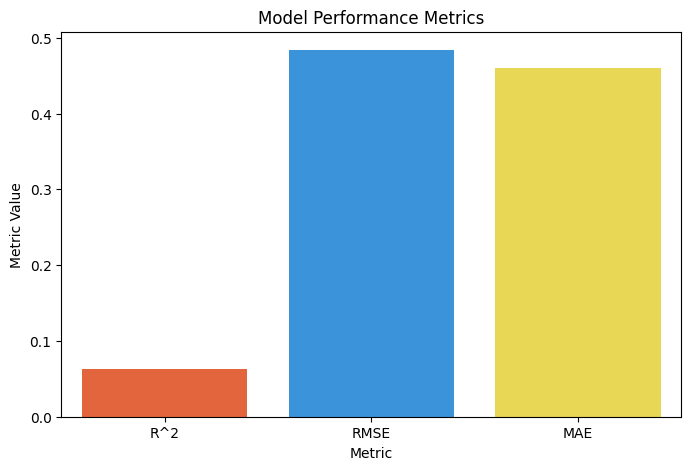

Cross-Validation R^2 scores: [-0.01196535  0.08101092  0.1396686   0.00451428  0.07090152]
Mean Cross-Validation R^2: 0.06


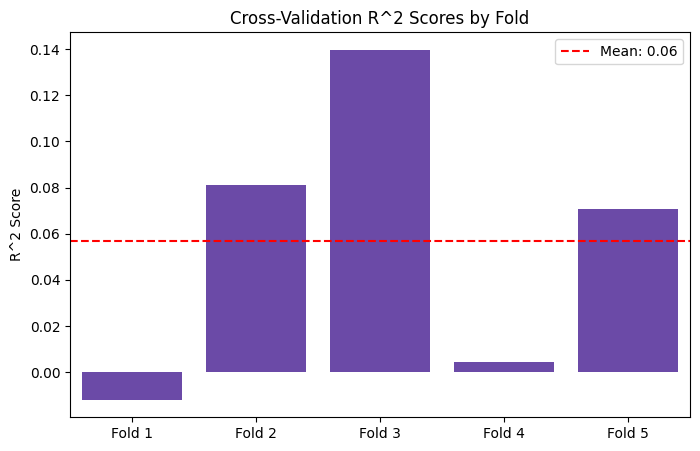

In [855]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

correlations = balanced_df.corr()["Sick"].sort_values(ascending=False)

selected_features = correlations[correlations.abs() > 0.1].index.drop("Sick")

dropped_features = set(balanced_df.columns) - set(selected_features) - {"Sick"}
kept_features = set(selected_features)

print("\nDropped features due to low correlation with target (Sick):")
print(dropped_features)

print("\nKept features with significant correlation to target (Sick):")
print(kept_features)

X_balanced_selected = balanced_df[selected_features]

y_balanced = balanced_df["Sick"]

X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced_selected), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

accuracy = model.score(X_test_scaled, y_test)
print(f"Model R^2: {accuracy:.2f}")

y_pred = model.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

metrics_df = pd.DataFrame({
    'Metric': ['R^2', 'RMSE', 'MAE'],
    'Value': [accuracy, rmse, mae]
})

plt.figure(figsize=(8, 5))
sns.barplot(data=metrics_df, x='Metric', y='Value', hue='Metric', dodge=False, palette=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.show()

cross_val_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="r2")
print(f"Cross-Validation R^2 scores: {cross_val_scores}")
print(f"Mean Cross-Validation R^2: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation R^2 Scores by Fold')
plt.ylabel('R^2 Score')
plt.legend()
plt.show()

**Results (undersampling & feature selection):**

- **Feature selection**:  
  Features with low correlation to the target variable `Sick` were removed to focus on those with potentially greater predictive power. The following features were dropped due to low correlation:
  - Dropped: `{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Type', 'Serum 3', 'Sex', 'Abnormalities', 'Serum 2', 'Arrival Weight', 'Hemoglobin 3'}`
  - Kept (significantly correlated): `{'Meat Color', 'Slaughter Weight', 'Fat Covering', 'Country ID', 'Days at Dairy Farm'}`

  These remaining features are hypothesized to be more relevant to predicting sickness based on their correlation with the target variable.

- **R² score**:  
  The model’s R² score of 0.06 indicates very limited explanatory power, suggesting that even after feature selection, the model still fails to capture meaningful variance in the target variable. This low R² score reflects ongoing challenges in predicting sickness with the available features.

- **Error metrics (RMSE and MAE)**:  
  - The RMSE of 0.48 and MAE of 0.46 indicate considerable prediction errors relative to the 0-1 range of `Sick`. These values suggest that the model still deviates significantly from actual values, even with the refined feature set.

- **Cross-validation R² scores**:  
  The cross-validation R² scores range from -0.01 to 0.14, with a mean of 0.06. These results show some variation in performance across folds, but the model’s generalizability remains poor, with all folds showing low performance.

In summary, despite feature selection and undersampling, the model’s low R² score and high error metrics suggest that the selected features still do not adequately capture the patterns necessary for predicting `Sick`. The overall performance remains suboptimal, and alternative modeling approaches may be needed to improve prediction accuracy.

#### K-Nearest Neighbors (Classification) - Data SlaughterhouseP

This code cell performs several key steps to prepare the data, train a K-Nearest Neighbors (KNN) model, and evaluate its performance on predicting the target variable `Sick`. Below is a breakdown of each step:

1. **Defining features and target variable**  
   The feature set (`X`) includes all columns except `Sick`, while the target variable (`y`) is `Sick`. The goal is to predict the continuous value of `Sick` based on other factors.

2. **Splitting the data**  
   The data is split into training and test sets with an 80-20 ratio. The `stratify=y` parameter preserves the distribution of the target variable `Sick` across both sets, which helps ensure that each set has a similar proportion of "sick" and "not sick" cases (prevents class imbalance).

3. **Feature scaling**  
   A `StandardScaler` is applied to normalize the training and test features. Standardizing features ensures that each feature has a mean of 0 and a standard deviation of 1, reducing the impact of feature scales on model performance. This step is especially useful for distance-based models like KNN.

4. **Training the K-Nearest Neighbors model**  
   A K-Nearest Neighbors (KNN) classifier with `n_neighbors=5` is trained on the scaled training data. KNN is a non-parametric model that classifies instances based on the majority class among the nearest neighbors in the feature space.

5. **Model evaluation**  
   Multiple metrics are used to evaluate the model:
   - **ROC AUC Score**: The ROC AUC (Receiver Operating Characteristic - Area Under the Curve) score measures the model’s ability to distinguish between the "sick" and "not sick" classes. An AUC score ranges from 0 to 1:
      - **1** indicates perfect discrimination, where the model accurately distinguishes between all "sick" and "not sick" cases.
      - **0.5** suggests no discriminatory power, equivalent to random guessing.
      - **Values closer to 1** indicate stronger model performance in correctly classifying cases, with higher scores representing a better balance between true positive and false positive rates across all possible thresholds.
   - **Confusion matrix**: Shows true positives, true negatives, false positives, and false negatives, providing insight into prediction errors.
   - **Classification report**: Displays precision, recall, and F1-score for both classes, essential for evaluating performance on imbalanced data.

6. **Cross-validation for model stability**  
   To assess the model's consistency, a 5-fold cross-validation is conducted. `StratifiedKFold` ensures that each fold has a similar distribution of the target variable `Sick`. The average cross-validation ROC AUC score serves as an indicator of the model’s consistency.

There are in total 2243 observations, of which 1794 are now in the train set, and 449 in the test set.
ROC AUC Score: 0.60


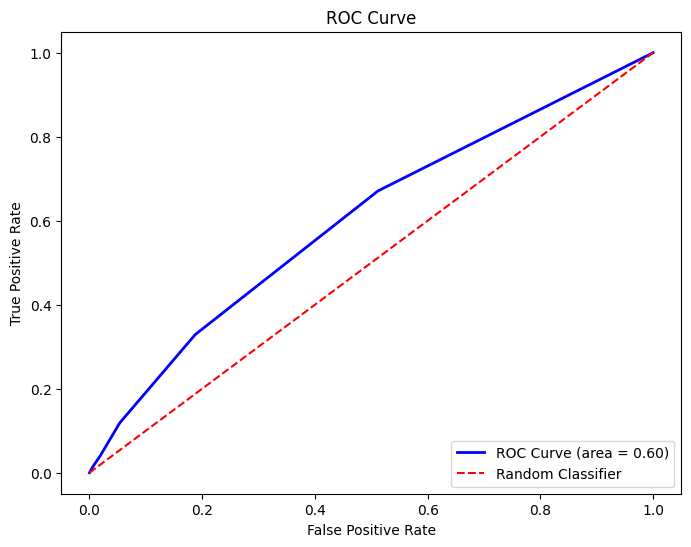

Confusion Matrix:
 [[353  20]
 [ 67   9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89       373
           1       0.31      0.12      0.17        76

    accuracy                           0.81       449
   macro avg       0.58      0.53      0.53       449
weighted avg       0.75      0.81      0.77       449



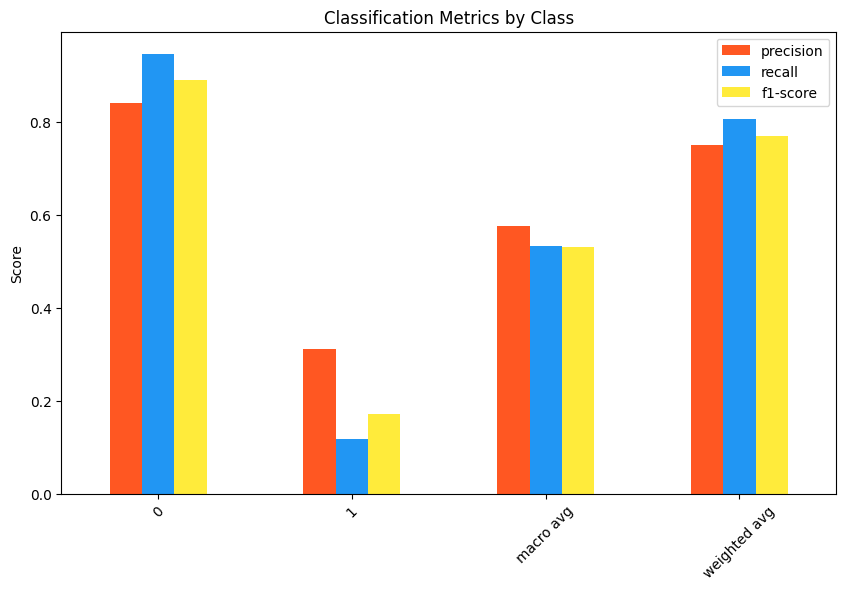

Cross-Validation AUC scores: [0.56846188 0.53848058 0.5771262  0.54819012 0.66545234]
Mean Cross-Validation AUC: 0.58


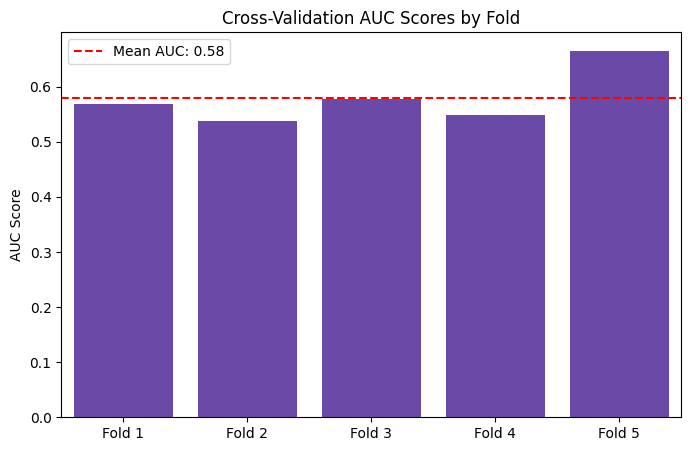

In [856]:
features = numeric_df.drop(columns="Sick").columns
target = "Sick"

X = numeric_df[features]
y = numeric_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(knn, X_train_scaled, y_train, cv=skf, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

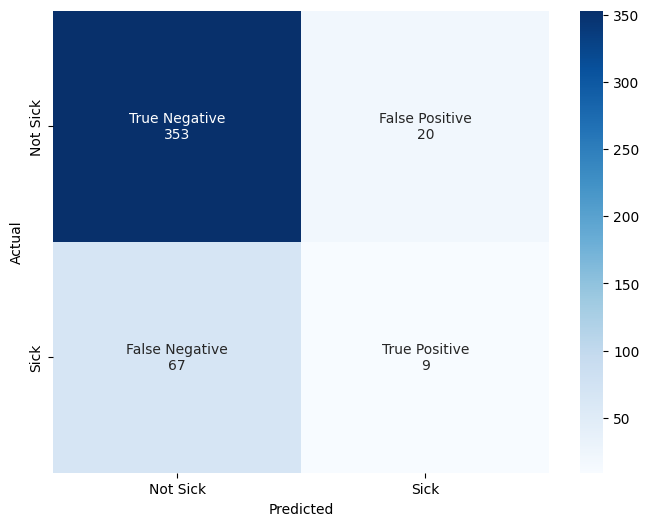

In [857]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results**

- **ROC AUC score**:  
  The ROC AUC score of 0.60 indicates **low discrimination ability**, suggesting that the model's ability to distinguish between "sick" and "not sick" cases is weak.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 353 true negatives and 20 false positives for "not sick" cases.  
  - 67 false negatives and 9 true positives for "sick" cases.  

- **Classification report**:
  - **Class 0 ("Not Sick")**: Precision of 0.84 and recall of 0.95, suggesting that the model is quite accurate in identifying "not sick" cases (while the dataset is heavily `imbalanced`).
  - **Class 1 ("Sick")**: Precision of 0.31 and recall of 0.12, showing that the model struggles significantly to predict "sick" cases, as reflected in both the low precision and recall.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.54 to 0.67, with a mean AUC of 0.58. This variability suggests that while the model's performance is somewhat consistent, there is significant room for improvement in stability and generalization.

In summary, the KNN model struggles to effectively distinguish between "sick" and "not sick" cases, with inconsistent performance overall. The model shows good results for "not sick" cases but struggles heavily with predicting "sick" cases, as indicated by its low precision and recall for that class. The cross-validation results show some variability, suggesting that the model could benefit from further tuning or a different approach to improve its performance.

##### Undersampling

This code cell addresses class imbalance in the dataset by applying **undersampling** to the majority class, `Not sick`. Class imbalance, where one class has significantly more instances than the other, can bias the model, as it may overly focus on the majority class while underperforming on the minority class.

1. **Undersampling the majority class**  
   To balance the classes, we randomly sample a subset of "Healthy" instances to match the count of "Sick" instances. This process creates a new balanced dataset where both classes have equal representation, reducing potential model bias.

2. **Verifying class balance**  
   We print the counts of each class in the new balanced dataset (`balanced_df`) to confirm that both classes are equally represented.

3. **Redefining features and target**  
   Using the balanced dataset, we redefine the features (`X_balanced`) and target (`y_balanced`) to ensure that the model trains on this new, unbiased data.

Counts of each class in balanced_df:
Sick
0    381
1    381
Name: count, dtype: int64

There are in total 762 observations, of which 609 are now in the train set, and 153 in the test set.
ROC AUC Score: 0.68


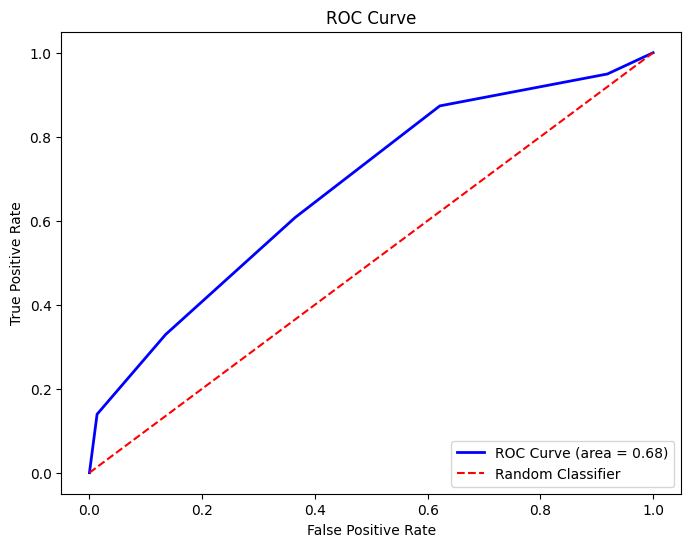

Confusion Matrix:
 [[47 27]
 [31 48]]
Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        74
           1       0.64      0.61      0.62        79

    accuracy                           0.62       153
   macro avg       0.62      0.62      0.62       153
weighted avg       0.62      0.62      0.62       153



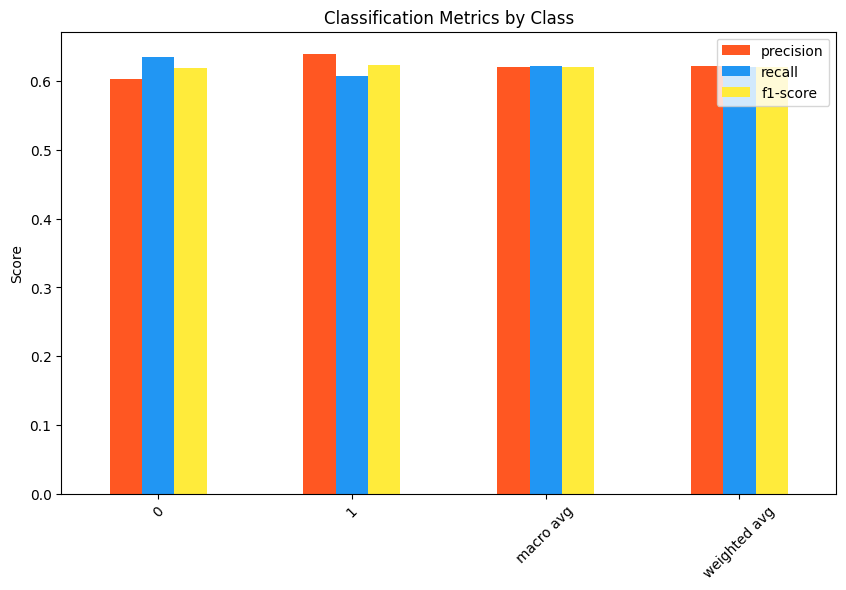

Cross-Validation AUC scores: [0.63655914 0.57634409 0.5825047  0.6308788  0.62131148]
Mean Cross-Validation AUC: 0.61


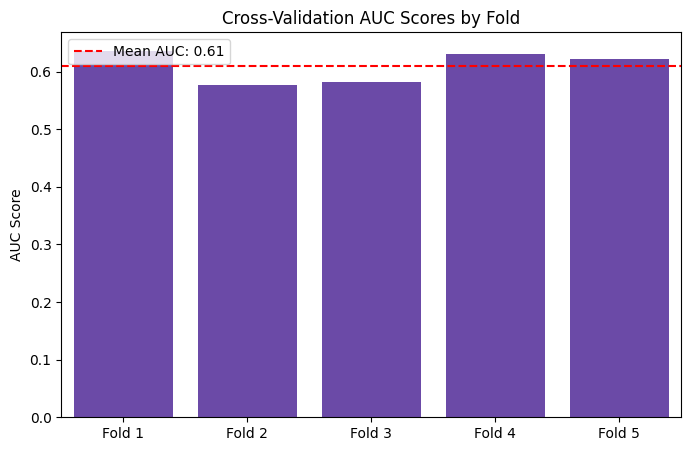

In [858]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

features = balanced_df.drop(columns="Sick").columns
target = "Sick"

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

cross_val_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

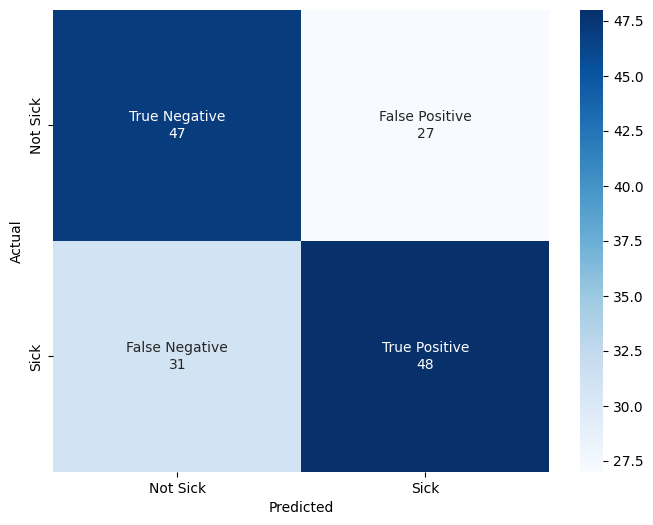

In [859]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results (undersampling)**

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 381 instances of "sick" and "not sick" cases each. This helps mitigate the effects of class imbalance.

- **ROC AUC score**:  
  The ROC AUC score of 0.68 indicates **moderate discrimination ability**, suggesting that the model has a better ability to distinguish between "sick" and "not sick" cases compared to previous results, though still not optimal.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 47 true negatives and 27 false positives for "not sick" cases.  
  - 31 false negatives and 48 true positives for "sick" cases.  

- **Classification report**:  
  - **Class 0 ("Not Sick")**: Precision of 0.60 and recall of 0.64, indicating that the model has relatively balanced but low performance in identifying "not sick" cases, with some misclassifications of "sick" cases as "not sick."  
  - **Class 1 ("Sick")**: Precision of 0.64 and recall of 0.61, showing that the model's performance for predicting "sick" cases is similar, with balanced precision and recall but still room for improvement.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.60 to 0.63, with a mean AUC of 0.61. This shows some improvement in stability and generalization compared to the baseline but still highlights that the model's performance varies across folds.

Compared to the results without undersampling (ROC AUC score of 0.60), undersampling improved the model's ROC AUC score to 0.68. However, the model continues to struggle with both "sick" and "not sick" cases, showing only modest improvements in performance. While the precision and recall for both classes are more balanced, the model still misclassifies a substantial number of cases. Overall, undersampling has balanced the dataset and slightly improved model performance, but further improvements are necessary.

##### Undersampling + Feature selection

This code cell introduces **feature selection** to reduce potential noise from irrelevant features, which could be contributing to the model's poor performance.

1. **Calculating correlations**  
   To identify features most relevant to the target variable (`Sick`), we calculate the correlation of each feature with `Sick`. Features with an absolute correlation above 0.1 are selected, as they likely contain useful information for predicting the target. This threshold helps retain only those features with a meaningful relationship to the target.

2. **Dropping low-correlation features**  
   Features with correlations below 0.1 are considered to have minimal relevance to `Sick` and are removed. By excluding these low-correlation features, we aim to reduce noise in the data, improving model performance by focusing on more predictive variables.

3. **Feature set redefinition**  
   After filtering, we redefine `X_balanced_selected` as the dataset containing only the selected features. This reduced feature set is then used in training and testing.

If these changes do not improve the performance, it may indicate that the current model is not suitable, or that the dataset lacks features capable of effectively predicting sickness.

Counts of each class in balanced_df:
Sick
0    381
1    381
Name: count, dtype: int64

Dropped features due to low correlation with target (Sick):
{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Type', 'Serum 3', 'Sex', 'Abnormalities', 'Serum 2', 'Arrival Weight', 'Hemoglobin 3'}

Kept features with significant correlation to target (Sick):
{'Meat Color', 'Slaughter Weight', 'Fat Covering', 'Country ID', 'Days at Dairy Farm'}

There are in total 762 observations, of which 609 are now in the train set, and 153 in the test set.
ROC AUC Score: 0.60


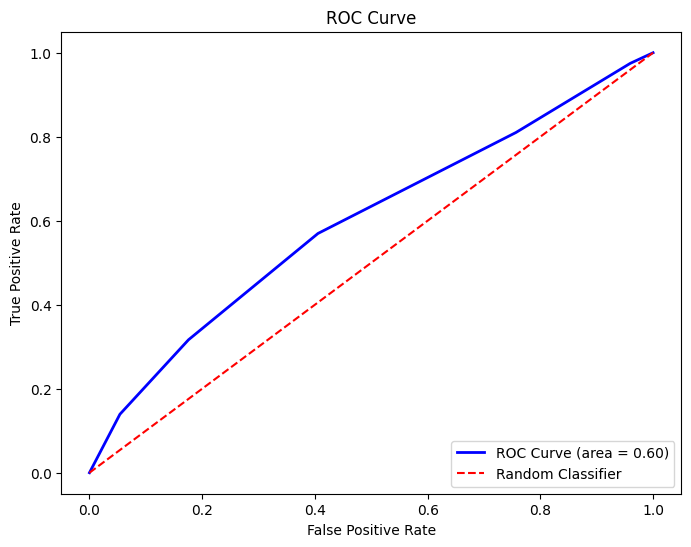

Confusion Matrix:
 [[44 30]
 [34 45]]
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.58        74
           1       0.60      0.57      0.58        79

    accuracy                           0.58       153
   macro avg       0.58      0.58      0.58       153
weighted avg       0.58      0.58      0.58       153



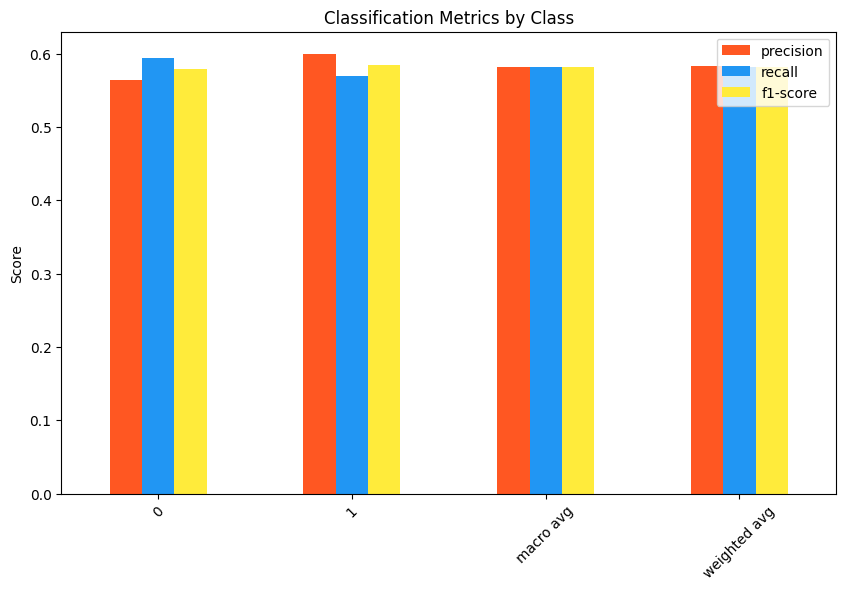

Cross-Validation AUC scores: [0.67069892 0.60591398 0.61744155 0.59997313 0.64685792]
Mean Cross-Validation AUC: 0.63


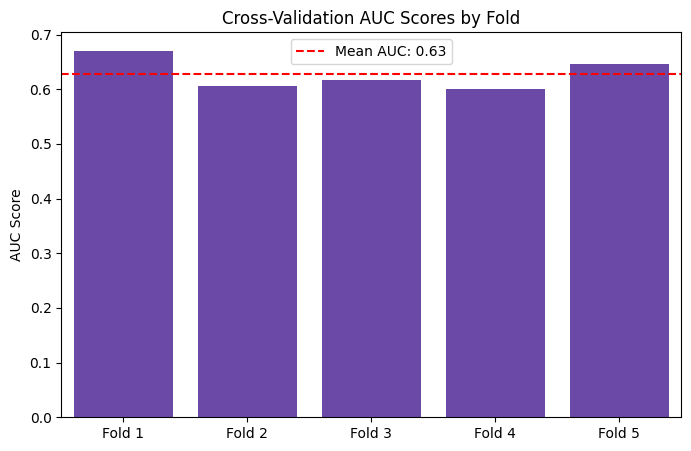

In [860]:
healthy_df = numeric_df[numeric_df["Sick"] == 0]
sick_df = numeric_df[numeric_df["Sick"] == 1]

healthy_df_undersampled = healthy_df.sample(n=len(sick_df), random_state=42)

balanced_df = pd.concat([healthy_df_undersampled, sick_df], ignore_index=True)

print("Counts of each class in balanced_df:")
print(balanced_df["Sick"].value_counts())

X_balanced = balanced_df[features]
y_balanced = balanced_df[target]

correlations = balanced_df.corr()["Sick"].sort_values(ascending=False)

selected_features = correlations[correlations.abs() > 0.1].index.drop("Sick")

dropped_features = set(balanced_df.columns) - set(selected_features) - {"Sick"}
kept_features = set(selected_features)

print("\nDropped features due to low correlation with target (Sick):")
print(dropped_features)

print("\nKept features with significant correlation to target (Sick):")
print(kept_features)

X_balanced_selected = balanced_df[selected_features]

y_balanced = balanced_df["Sick"]

X_train, X_test, y_train, y_test = train_test_split(X_balanced_selected, y_balanced, test_size=0.2, random_state=42)
print("\nThere are in total", len(X_balanced_selected), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
print(f"ROC AUC Score: {roc_auc:.2f}")

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

report = classification_report(y_test, y_pred, output_dict=True)
metrics_df = pd.DataFrame(report).T[['precision', 'recall', 'f1-score']].drop('accuracy')

metrics_df.plot(kind='bar', figsize=(10, 6), color=['#FF5722', '#2196F3', '#FFEB3B'])
plt.title('Classification Metrics by Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

cross_val_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC scores: {cross_val_scores}")
print(f"Mean Cross-Validation AUC: {cross_val_scores.mean():.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[f'Fold {i+1}' for i in range(len(cross_val_scores))], y=cross_val_scores, color='#673AB7')
plt.axhline(y=cross_val_scores.mean(), color='red', linestyle='--', label=f'Mean AUC: {cross_val_scores.mean():.2f}')
plt.title('Cross-Validation AUC Scores by Fold')
plt.ylabel('AUC Score')
plt.legend()
plt.show()

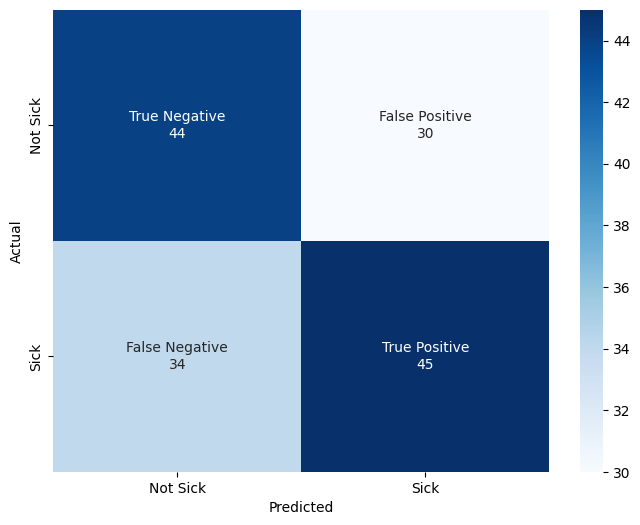

In [861]:
conf_matrix = confusion_matrix(y_test, y_pred)

labels = [
    ["True Negative\n{}".format(conf_matrix[0, 0]), "False Positive\n{}".format(conf_matrix[0, 1])],
    ["False Negative\n{}".format(conf_matrix[1, 0]), "True Positive\n{}".format(conf_matrix[1, 1])]
]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Blues', xticklabels=['Not Sick', 'Sick'], yticklabels=['Not Sick', 'Sick'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Results (undersampling & feature selection)**

- **Class balance**:  
  The dataset was balanced through undersampling, resulting in equal counts for both classes, with 381 instances of "sick" and "not sick" cases each.

- **Feature selection**:  
  Features with low correlation to the target ("Sick") were dropped:  
  `{'Hemoglobin 2', 'Season_Born', 'Fur Color', 'Hemoglobin 1', 'Merchant', 'Type', 'Serum 3', 'Sex', 'Abnormalities', 'Serum 2', 'Arrival Weight', 'Hemoglobin 3'}`  
  The following features were retained due to their significant correlation with the target:  
  `{'Meat Color', 'Slaughter Weight', 'Fat Covering', 'Country ID', 'Days at Dairy Farm'}`

- **ROC AUC score**:  
  The ROC AUC score of 0.60 indicates **low discrimination ability**, which is lower than the ROC AUC score of 0.68 achieved with undersampling alone. This suggests that feature selection may have reduced the model's ability to effectively distinguish between "sick" and "not sick" cases.

- **Confusion matrix**:  
  The confusion matrix shows:  
  - 44 true negatives and 30 false positives for "not sick" cases.  
  - 34 false negatives and 45 true positives for "sick" cases.  

- **Classification report**:  
  - **Class 0 ("Not Sick")**: Precision of 0.56 and recall of 0.59, indicating that the model has low performance in identifying "not sick" cases and misclassifies a substantial number as "sick."  
  - **Class 1 ("Sick")**: Precision of 0.60 and recall of 0.57, showing that the model’s performance for predicting "sick" cases is still low.

- **Cross-validation AUC scores**:  
  The cross-validation AUC scores range from 0.59 to 0.71, with a mean AUC of 0.63. This range reflects inconsistent performance across folds, indicating that the model's generalization ability is limited and that stability is a concern.

Compared to the undersampling-only model (ROC AUC of 0.68), adding feature selection slightly reduced the model’s ROC AUC score to 0.60. The recall for "sick" cases (0.57) and precision for "not sick" cases (0.56) remain low. Despite feature selection, the model still struggles with misclassification, indicating that further tuning is necessary to improve its ability to reliably distinguish between "sick" and "not sick" cases.